# Модуль A

## Импорт библиотек

In [51]:
import pandas as pd
from datetime import datetime, date
from tqdm import tqdm
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import shapiro, skew
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')
tqdm.pandas()

## Загрузка данных

In [2]:
expenses = pd.read_csv("expenses.csv")

expenses.head()

dt   Channel  costs
0  2022-05-01  FaceBoom  113.3
1  2022-05-02  FaceBoom   78.1
2  2022-05-03  FaceBoom   85.8
3  2022-05-04  FaceBoom  136.4
4  2022-05-05  FaceBoom  122.1

In [3]:
expenses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [4]:
orders = pd.read_csv("orders.csv")

orders.head()

User Id             Event Dt  Revenue
0  188246423999  2022-05-01 23:09:52     4.99
1  174361394180  2022-05-01 12:24:04     4.99
2  529610067795  2022-05-01 11:34:04     4.99
3  319939546352  2022-05-01 15:34:40     4.99
4  366000285810  2022-05-01 13:59:51     4.99

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
visitation = pd.read_csv("visitation.csv")

visitation.head()

User Id  Region   Device  Channel        Session Start  \
0  981449118918  Russia   iPhone  organic  2022-05-01 02:36:01   
1  278965908054  Russia   iPhone  organic  2022-05-01 04:46:31   
2  590706206550  Russia      Mac  organic  2022-05-01 14:09:25   
3  326433527971  Russia  Android   TipTop  2022-05-01 00:29:59   
4  349773784594  Russia      Mac  organic  2022-05-01 03:33:35   

           Session End  
0  2022-05-01 02:45:01  
1  2022-05-01 04:47:35  
2  2022-05-01 15:32:08  
3  2022-05-01 00:54:25  
4  2022-05-01 03:57:40

In [7]:
visitation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


## Кластеры клиентов

In [8]:
print("Самая ранняя дата: ", visitation["Session Start"].min())
print("Самая поздняя дата: ", visitation["Session End"].max())

Самая ранняя дата:  2022-05-01 00:00:41
Самая поздняя дата:  2022-11-01 01:38:46


### Преобразование дат в тип datetime

In [9]:
expenses["dt"] = pd.to_datetime(expenses["dt"])
orders["Event Dt"] = pd.to_datetime(orders["Event Dt"])
visitation["Session Start"] = pd.to_datetime(visitation["Session Start"])
visitation["Session End"] = pd.to_datetime(visitation["Session End"])

### Извлечение месяца из даты

In [10]:
visitation["month"] = visitation["Session Start"].dt.month

### Создание дополнительных атрибутов

In [11]:
def get_user_revenue(row):
    user_id = row["User Id"]
    session_start = row["Session Start"]
    session_end = row["Session End"]
    
    try:
        revenue = orders[(orders["User Id"] == user_id) &
        (orders["Event Dt"] >= session_start) &
        (orders["Event Dt"] <= session_end)]["Revenue"].iloc[0]
    except IndexError:
        return None

    return revenue

In [12]:
visitation["Revenue"] = visitation[["User Id", "Session Start", "Session End"]].progress_apply(
    get_user_revenue, axis=1)

100%|██████████| 309901/309901 [03:25<00:00, 1507.25it/s]


In [13]:
visitation["Revenue"] = visitation["Revenue"].fillna(0)

In [14]:
visitation["Channel"].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [15]:
visitation

User Id    Region   Device         Channel       Session Start  \
0       981449118918    Russia   iPhone         organic 2022-05-01 02:36:01   
1       278965908054    Russia   iPhone         organic 2022-05-01 04:46:31   
2       590706206550    Russia      Mac         organic 2022-05-01 14:09:25   
3       326433527971    Russia  Android          TipTop 2022-05-01 00:29:59   
4       349773784594    Russia      Mac         organic 2022-05-01 03:33:35   
...              ...       ...      ...             ...                 ...   
309896  329994900775    Turkey       PC         LeapBob 2022-10-31 13:28:12   
309897  334903592310  Thailand       PC  lambdaMediaAds 2022-10-31 22:14:52   
309898  540102010126     China       PC         organic 2022-10-31 01:40:48   
309899  308736936846     China      Mac         organic 2022-10-31 07:37:34   
309900  109329042535     China       PC  lambdaMediaAds 2022-10-31 14:17:43   

               Session End  month  Revenue  
0      2022-05-01 02:45:01      5     0.00  
1      2022-05-01 04:47:35      5     0.00  
2      2022-05-01 15:32:08      5     0.00  
3      2022-05-01 00:54:25      5     0.00  
4      2022-05-01 03:57:40      5     0.00  
...                    ...    ...      ...  
309896 2022-10-31 14:39:29     10     4.99  
309897 2022-10-31 22:39:36     10     0.00  
309898 2022-10-31 01:41:31     10     0.00  
309899 2022-10-31 07:37:55     10     0.00  
309900 2022-10-31 15:17:04     10     0.00  

[309901 rows x 8 columns]

In [16]:
visitation["Session Duration"] = visitation["Session End"] - visitation["Session Start"]

In [17]:
def get_user_expenses(row):
    channel = row["Channel"]
    session_start = row["Session Start"].date()

    try:
        expenses_cost = expenses[(expenses["dt"].dt.date == session_start) &
        (expenses["Channel"] == channel)]["costs"].iloc[0]
    except IndexError:
        return 0

    return expenses_cost



In [18]:
visitation["Expenses"] = visitation[["Channel", "Session Start"]].progress_apply(
    get_user_expenses, axis=1)

100%|██████████| 309901/309901 [03:40<00:00, 1402.63it/s]


In [19]:
def get_stat_attrs(col):
    result_df = visitation.groupby("User Id")[col].agg(["sum", "mean", "min", "max", "std"])
    result_df = result_df.rename(columns={"sum": f"{col}_sum", "mean": f"{col}_mean", "min": f"{col}_min", "max": f"{col}_max", "std": f"{col}_std"})

    return result_df

In [20]:
user_data = pd.DataFrame()

for col in ["Revenue", "Expenses"]:
    user_data = pd.concat([user_data, get_stat_attrs(col)], axis=1)

In [21]:
visitation = pd.get_dummies(visitation, columns=["Region", "Device", "Channel"], dtype=int)

In [22]:
user_data = pd.concat([user_data, visitation.groupby("User Id").count().iloc[:, 6:]], axis=1)

In [23]:
user_data["Session_duration_mean"] = visitation.groupby("User Id")["Session Duration"].mean()

In [24]:
def get_minutes(row):
    minutes = row.seconds // 60

    return minutes

In [25]:
user_data["Session_duration_mean"] = user_data["Session_duration_mean"].progress_apply(get_minutes)

100%|██████████| 150008/150008 [00:00<00:00, 726594.39it/s]


In [26]:
count_of_visits = visitation.groupby(["User Id", "month"])["Session Start"].count().reset_index()

user_data["Month_visits_mean"] = count_of_visits.groupby("User Id")["Session Start"].mean()

In [27]:
user_data = user_data.fillna(0)

<b>Вывод</b>

В данном разделе были созданы новые признаки: выручка и затраты на клиента (среднее, мин, макс, сумма, стандартное отклонение), кол-во заходов через конкретное устройство, кол-во заходов в конкретной стране, кол-во сессий (начавшихся благодаря конретной рекламе), среднее кол-во сессий за месяц, средняя продолжительность сессии.

### Кластеризация и отбор признаков

In [28]:
K = range(2,8)
wss = []
for k in K:
    kmeans=cluster.KMeans(n_clusters=k,init="k-means++", random_state=42)
    kmeans=kmeans.fit(user_data)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

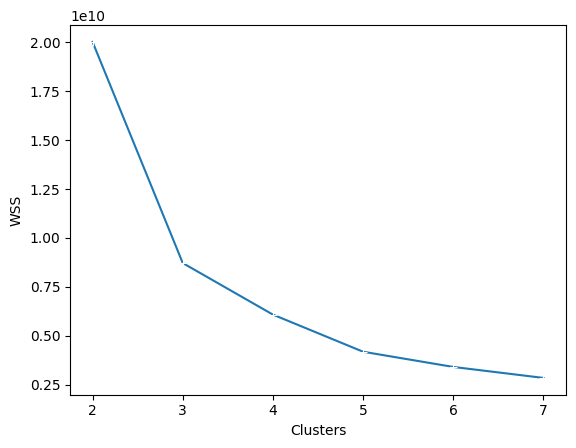

In [29]:
mycenters = pd.DataFrame({'Clusters' : K, 'WSS' : wss})

sns.lineplot(x = 'Clusters', y = 'WSS', data = mycenters, marker="+")
plt.show()

Вывод: будем использовать 3 кластера и отберём для них лучшие признаки

In [30]:
kmeans=cluster.KMeans(n_clusters=3,init="k-means++", random_state=42)

kmeans.fit(user_data)

clusters = kmeans.predict(user_data)

In [31]:
x_shuffled, y_shuffled = shuffle(user_data, clusters, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(x_shuffled, y_shuffled, test_size = 0.25, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

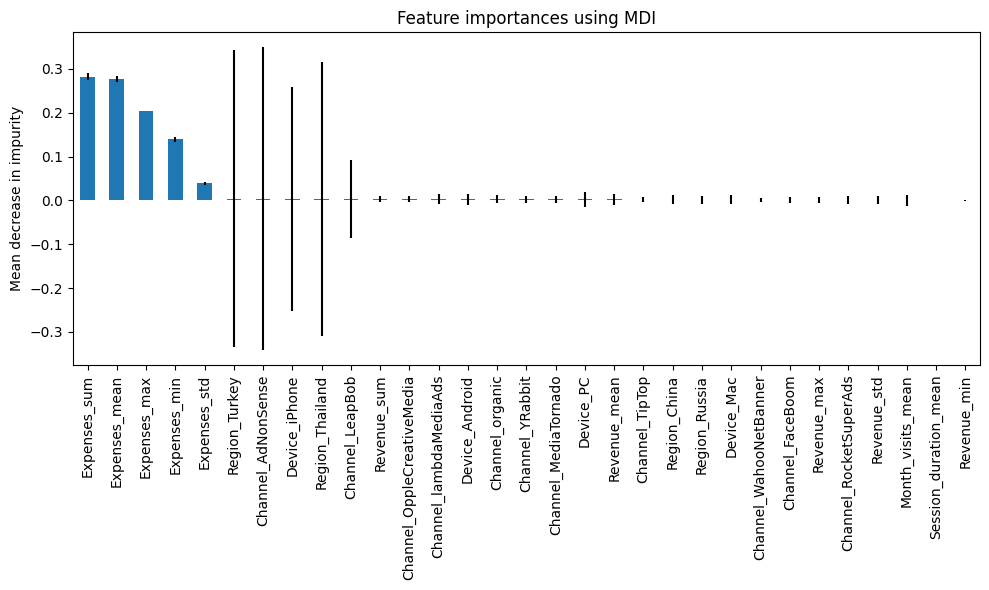

In [32]:
importances = clf.feature_importances_

std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=user_data.columns).sort_values(ascending=False)


fig, ax = plt.subplots(figsize=(10, 6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<b>Вывод</b>

Оставим следующие признаки: Expenses_sum, Expenses_mean, Expenses_max, Expenses_min, Expenses_std, Region_Turkey, Channel_AdNonSense, Device_iPhone, Region_Thailand, Channel_LeapBob.

Причина такого выбора: часто использовались моделью для предсказания кластера, остальные имеют низкую частоту использования и маленький разброс.

Что означают кластеры: скорее всего, это то, насколько сложно и дорого привлекать того или иного клиента.

In [33]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150008 entries, 599326 to 999999563947
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Revenue_sum                 150008 non-null  float64
 1   Revenue_mean                150008 non-null  float64
 2   Revenue_min                 150008 non-null  float64
 3   Revenue_max                 150008 non-null  float64
 4   Revenue_std                 150008 non-null  float64
 5   Expenses_sum                150008 non-null  float64
 6   Expenses_mean               150008 non-null  float64
 7   Expenses_min                150008 non-null  float64
 8   Expenses_max                150008 non-null  float64
 9   Expenses_std                150008 non-null  float64
 10  Region_China                150008 non-null  int64  
 11  Region_Russia               150008 non-null  int64  
 12  Region_Thailand             150008 non-null  int64  
 13  Region_T

## Описание и анализ признаков

1. Таблица expenses (Затраты)

* dt - дата рекламы
* Channel - канал, где выпускалась реклама
* costs - стоимость рекламы

2. Таблица orders (Заказы)

* User Id - уникальный идентификатор пользователя
* Event Dt - дата оформления заказа
* Revenue - прибыль, полученная с заказа

3. Таблица visitation (Посещения)

* User Id - уникальный идентификатор пользователя
* Region - регион (страна), с которой был осуществлён вход на сайт (переведён в One-Hot-Encoding)
* Device - устройство, c которого был осуществлён вход на сайт (переведён в One-Hot-Encoding)
* Channel - канал, через который пользователь зашёл на сайт (organic - самостоятельно) (переведён в One-Hot-Encoding)
* Session Start - дата и время начала сессии
* Session End - дата и время окончания сессии
* Session Duration - продолжительность сессии
* Month - месяц, в котором осуществлялась сессия
* Revenue - прибыль, полученная с сессии
* Expenses - затраты (за день), потраченные на рекламу в канале, через который перешёл пользователь

4. Таблица user_data (Данные о пользователях)

* Revenue (sum, mean, max, min, std) -  Прибыль (сумма, средняя, максимальная, минимальная, станд. откл.), полученная с пользователя
* Expenses (sum, mean, max, min, std) -  Затраты (за день) (сумма, средняя, максимальная, минимальная, станд. откл.), потраченные на рекламу в каналах, через которые переходил пользователь
* Region - кол-во сессий пользователя, осуществлённых в определённом регионе (переведён в One-Hot-Encoding)
* Device - кол-во сессий пользователя, осуществлённых через определённое устройство (переведён в One-Hot-Encoding)
* Channel - кол-во сессий пользователя, осуществлённных путем переходе через рекламу в определённых каналах (переведён в One-Hot-Encoding)
* Session_duration_mean - средняя продолжительность одной сессии пользователя
* Month_visits_mean - среднее кол-во сессий пользователя за месяц

### Проверка на нормальность распределения и скошенность признаков

In [34]:
def execute_shapiro_test(data):
    result = shapiro(data)
    p_value = result[1]
    
    return p_value

def get_assymetry(data):
    result = skew(data)

    if result > 0.1:
        return "Влево"
    elif result < -0.1:
        return "Вправо"
    return "Не выявлено"

def visual_distribution(data, column):

    fig, ax = plt.subplots(figsize=(12, 5))
    sns.kdeplot(data=data, x=column, ax=ax)
    ax.set_title(f"Распределение для признака: {column}")

    fig.tight_layout()
    plt.show()

    shapiro_p_value = execute_shapiro_test(data[column])
    print(f"По тесту Шапиро нормальность {column}: {shapiro_p_value > 0.05}, p_value: {shapiro_p_value}")

    assymetry = get_assymetry(data[column])
    print(f"Скошенность распределения {column}: {assymetry}")

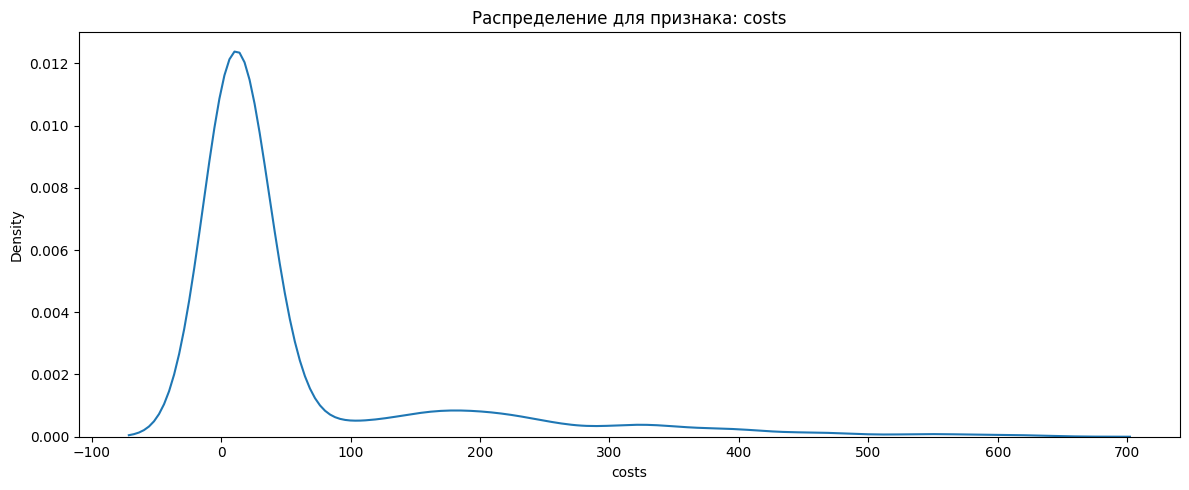

По тесту Шапиро нормальность costs: False, p_value: 3.345320970804944e-55
Скошенность распределения costs: Влево


In [35]:
visual_distribution(expenses, "costs")

Возможные распределения:

* costs - Распределение Фишера

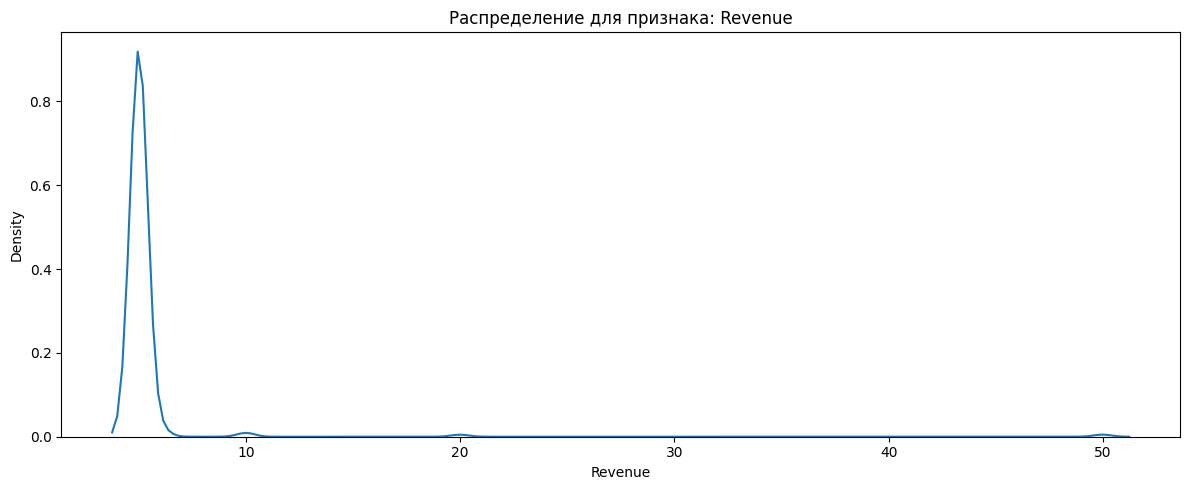

По тесту Шапиро нормальность Revenue: False, p_value: 2.6184719835300424e-154
Скошенность распределения Revenue: Влево


In [36]:
visual_distribution(orders, "Revenue")

Возможные распределения:

* Revenue - распределение Фишера

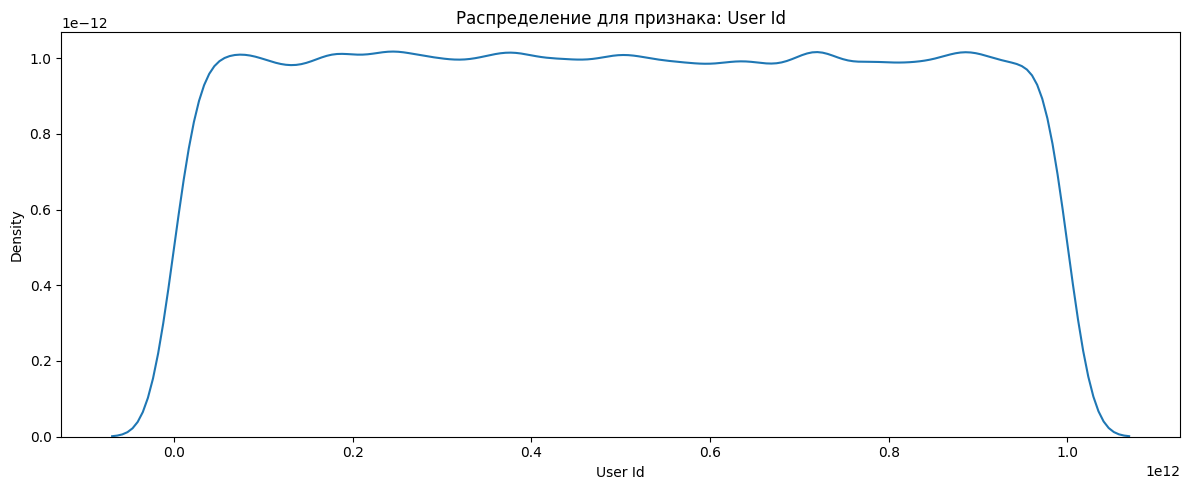

По тесту Шапиро нормальность User Id: False, p_value: 2.3260023853914022e-112
Скошенность распределения User Id: Не выявлено


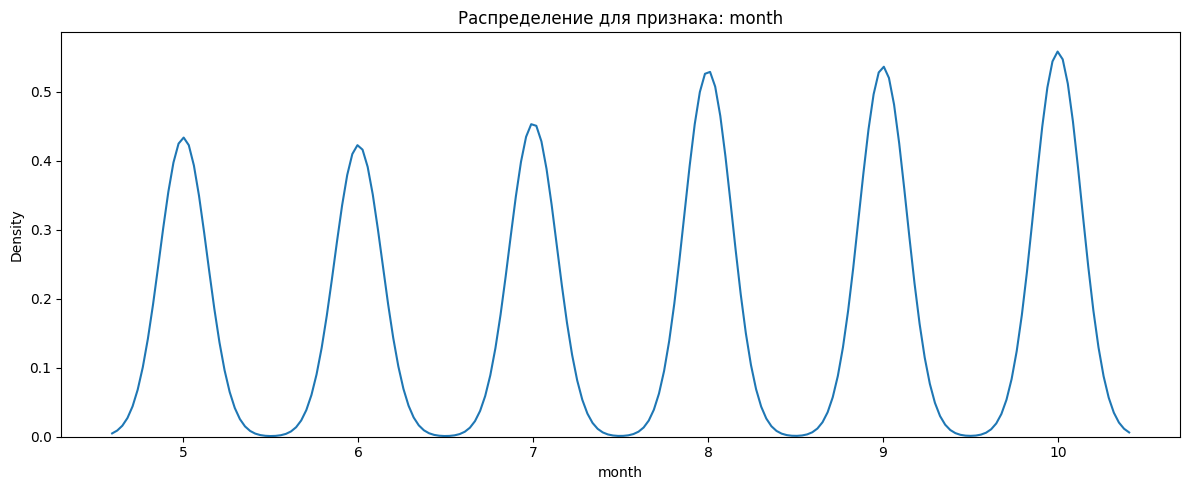

По тесту Шапиро нормальность month: False, p_value: 4.2077667073401536e-134
Скошенность распределения month: Вправо


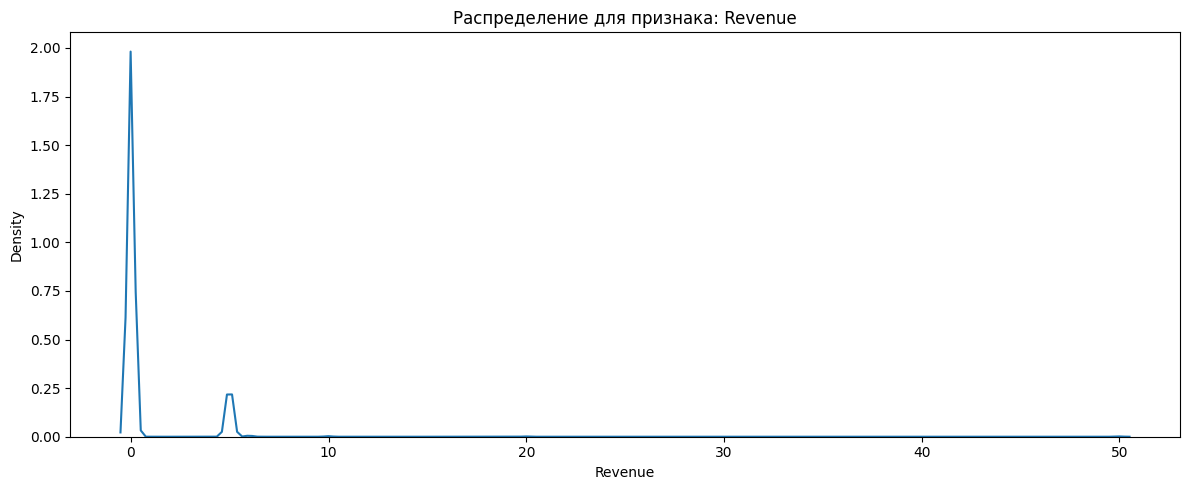

По тесту Шапиро нормальность Revenue: False, p_value: 5.121638227549094e-201
Скошенность распределения Revenue: Влево


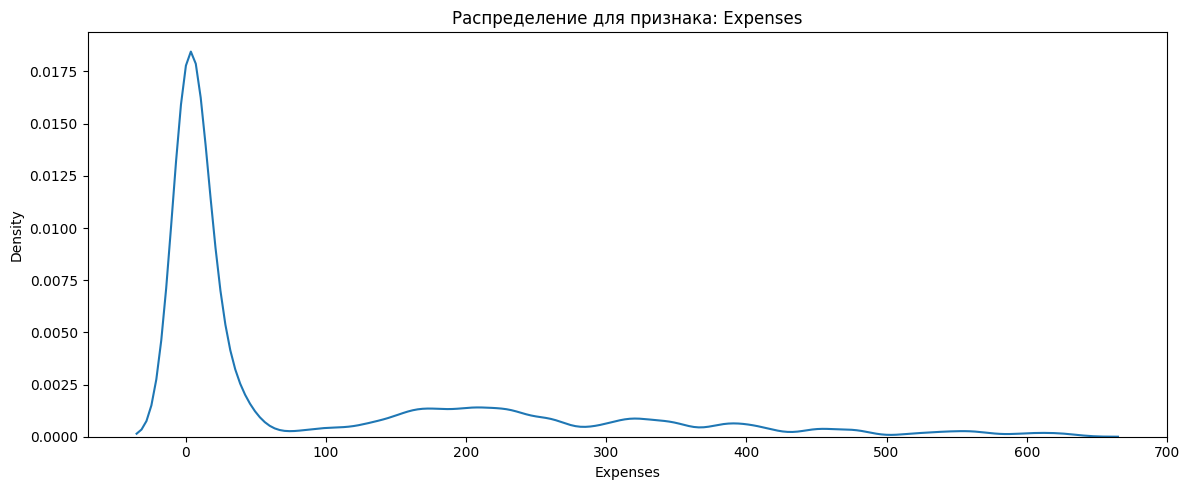

По тесту Шапиро нормальность Expenses: False, p_value: 1.1177535416893585e-170
Скошенность распределения Expenses: Влево


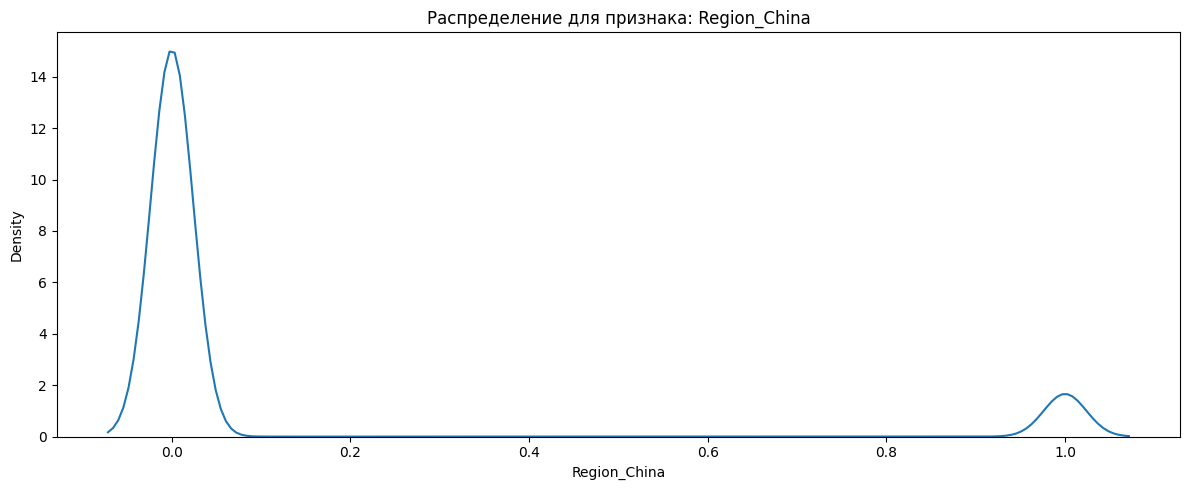

По тесту Шапиро нормальность Region_China: False, p_value: 3.288483983549085e-199
Скошенность распределения Region_China: Влево


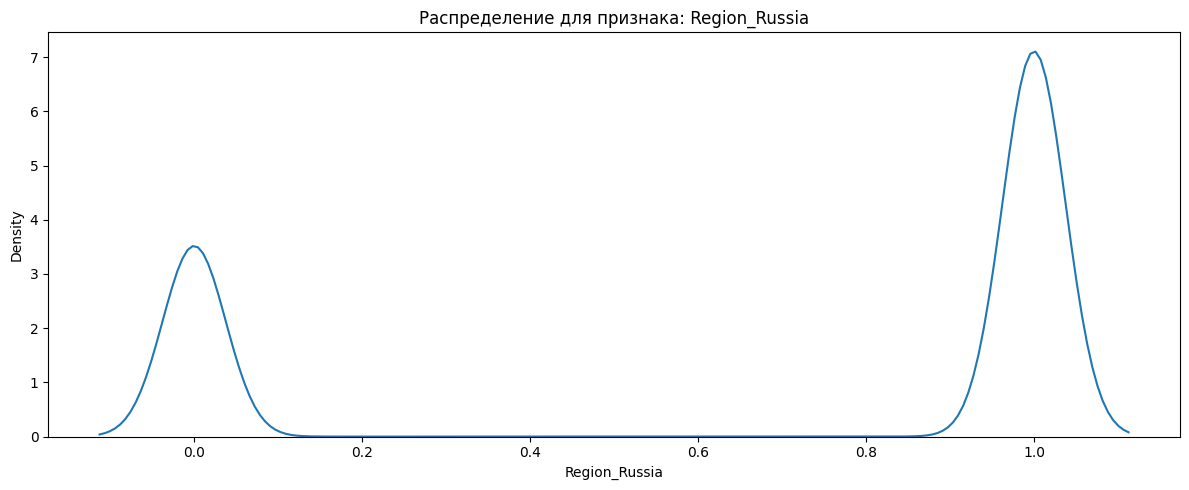

По тесту Шапиро нормальность Region_Russia: False, p_value: 1.1099430259459653e-181
Скошенность распределения Region_Russia: Вправо


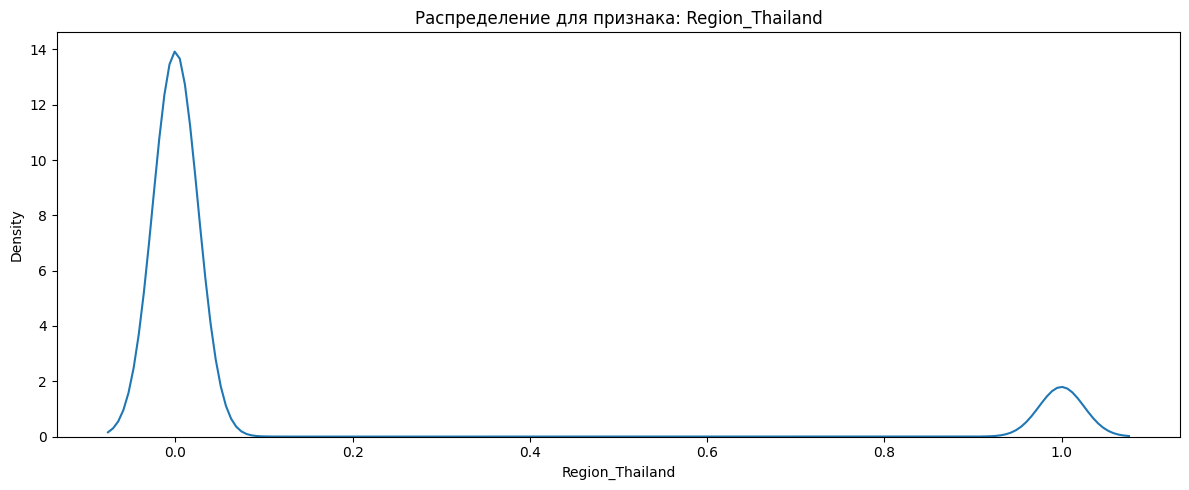

По тесту Шапиро нормальность Region_Thailand: False, p_value: 1.330864704633349e-197
Скошенность распределения Region_Thailand: Влево


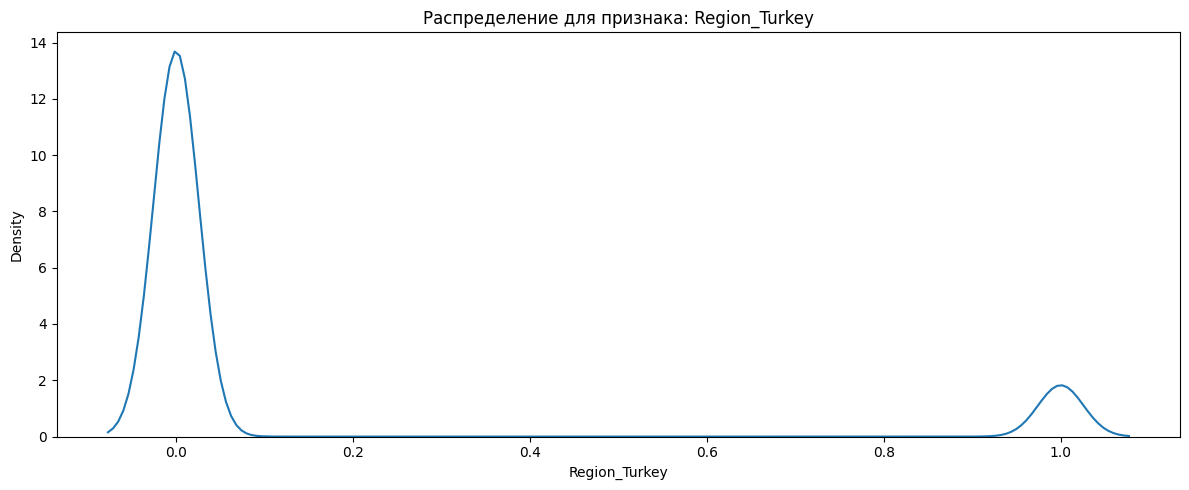

По тесту Шапиро нормальность Region_Turkey: False, p_value: 2.930214111955943e-197
Скошенность распределения Region_Turkey: Влево


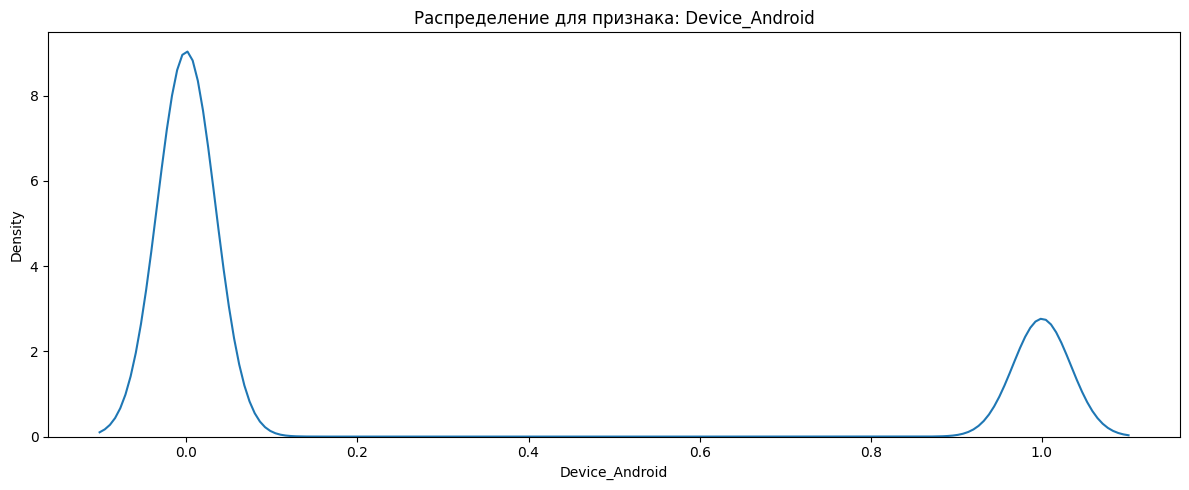

По тесту Шапиро нормальность Device_Android: False, p_value: 2.7886650394291096e-187
Скошенность распределения Device_Android: Влево


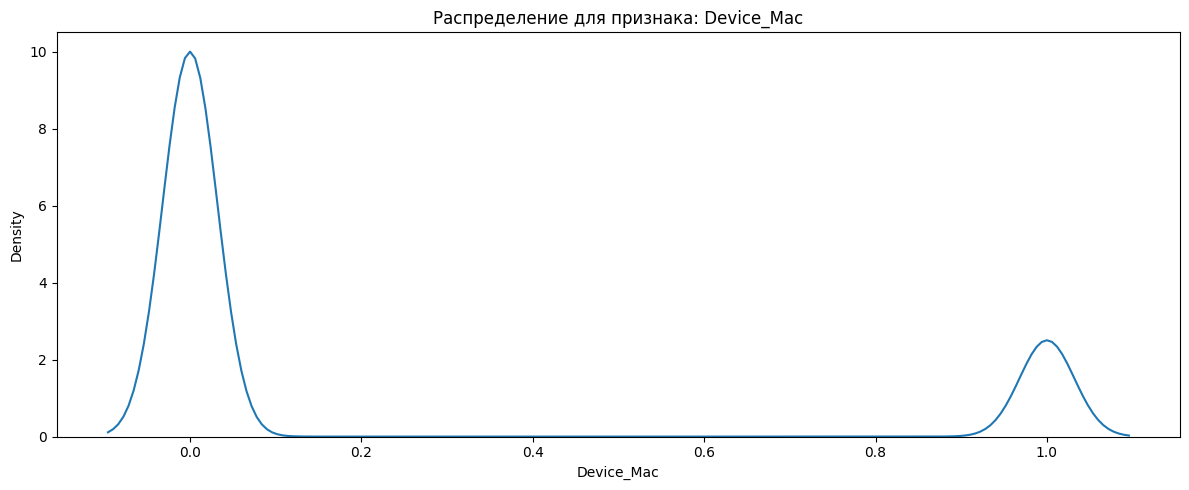

По тесту Шапиро нормальность Device_Mac: False, p_value: 8.232898072454483e-190
Скошенность распределения Device_Mac: Влево


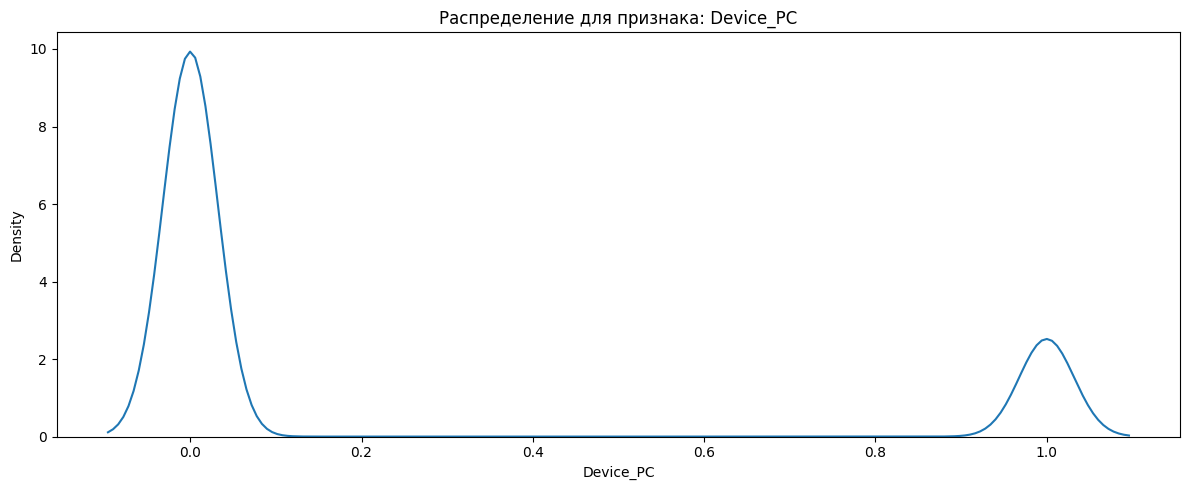

По тесту Шапиро нормальность Device_PC: False, p_value: 1.2112339285506119e-189
Скошенность распределения Device_PC: Влево


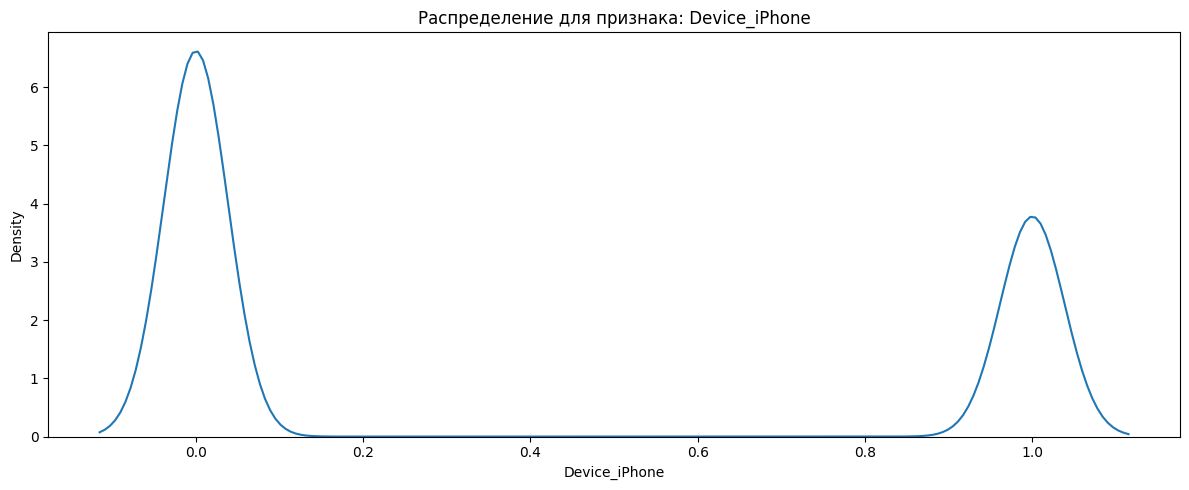

По тесту Шапиро нормальность Device_iPhone: False, p_value: 2.4588674812443465e-180
Скошенность распределения Device_iPhone: Влево


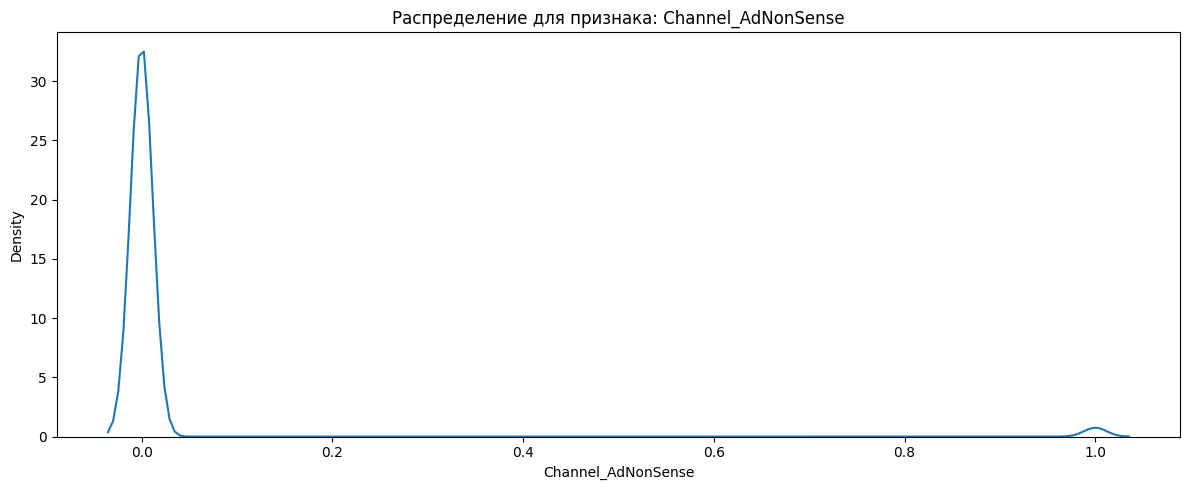

По тесту Шапиро нормальность Channel_AdNonSense: False, p_value: 1.147810139744608e-209
Скошенность распределения Channel_AdNonSense: Влево


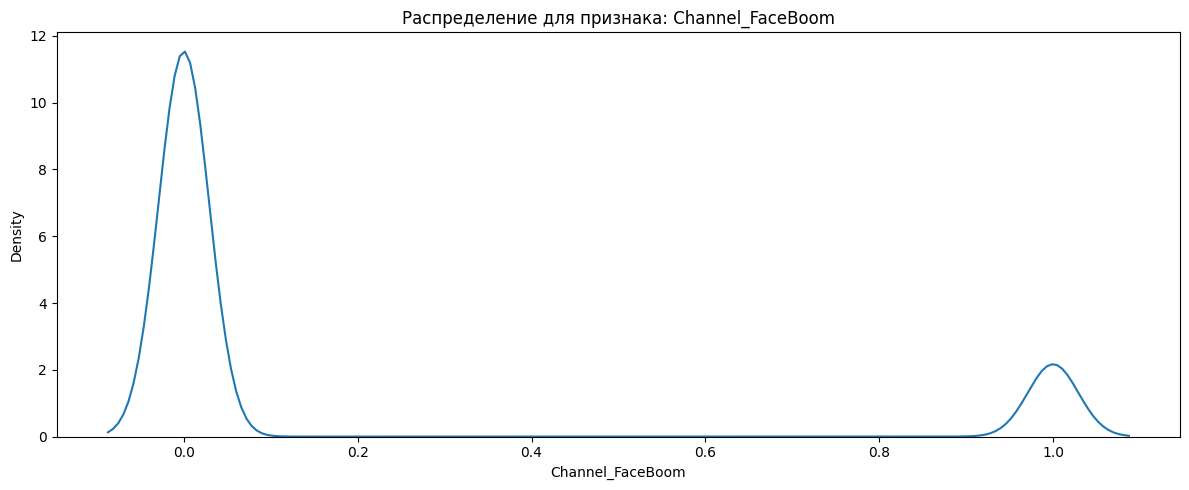

По тесту Шапиро нормальность Channel_FaceBoom: False, p_value: 2.4290353720047743e-193
Скошенность распределения Channel_FaceBoom: Влево


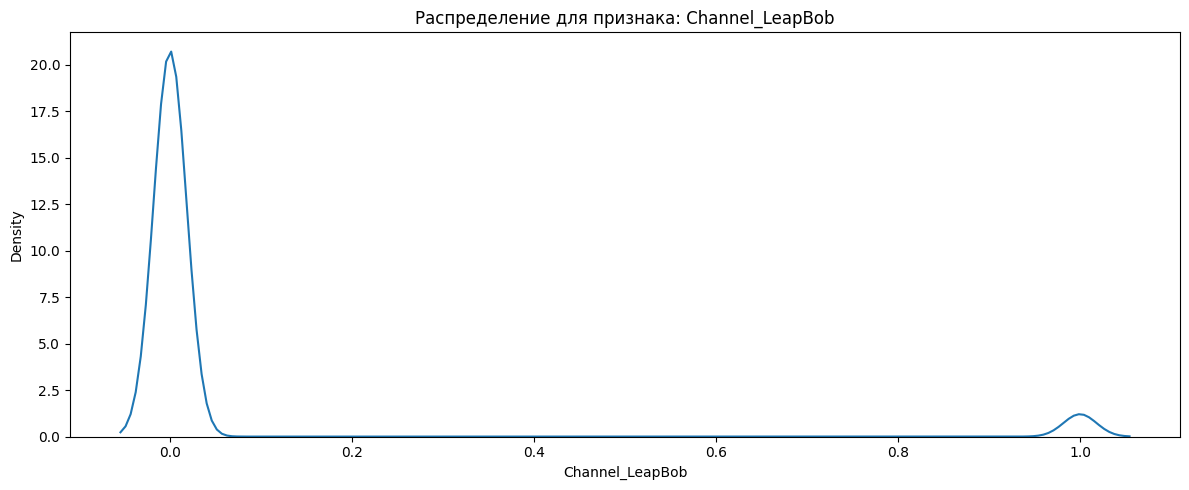

По тесту Шапиро нормальность Channel_LeapBob: False, p_value: 1.2679896936470156e-204
Скошенность распределения Channel_LeapBob: Влево


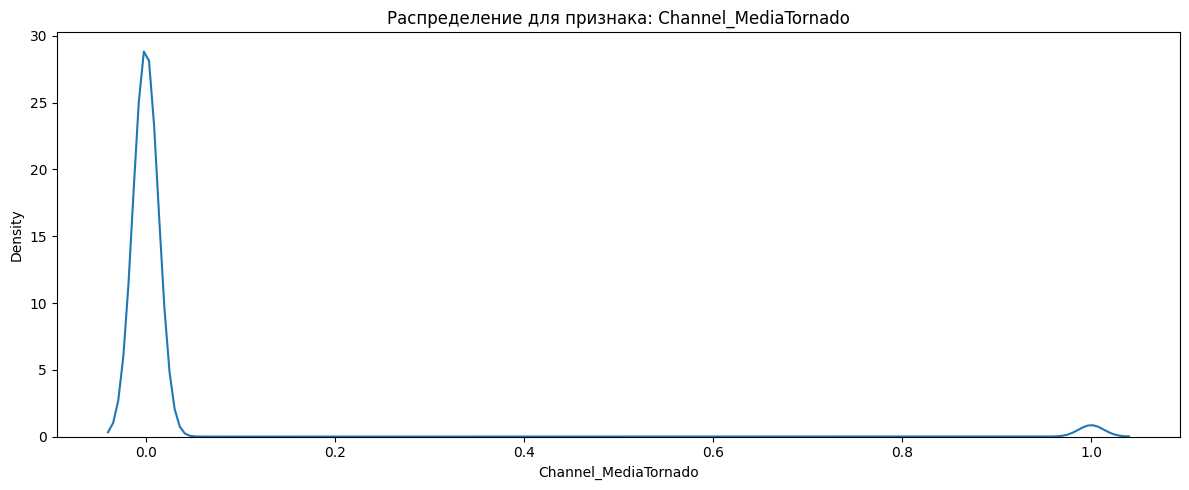

По тесту Шапиро нормальность Channel_MediaTornado: False, p_value: 1.480123519256397e-208
Скошенность распределения Channel_MediaTornado: Влево


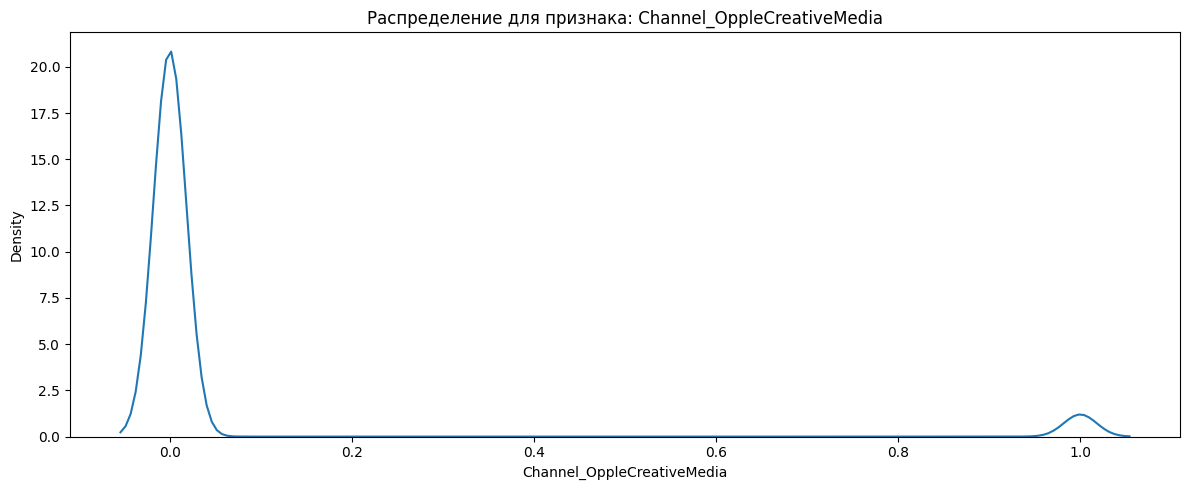

По тесту Шапиро нормальность Channel_OppleCreativeMedia: False, p_value: 1.015193335625733e-204
Скошенность распределения Channel_OppleCreativeMedia: Влево


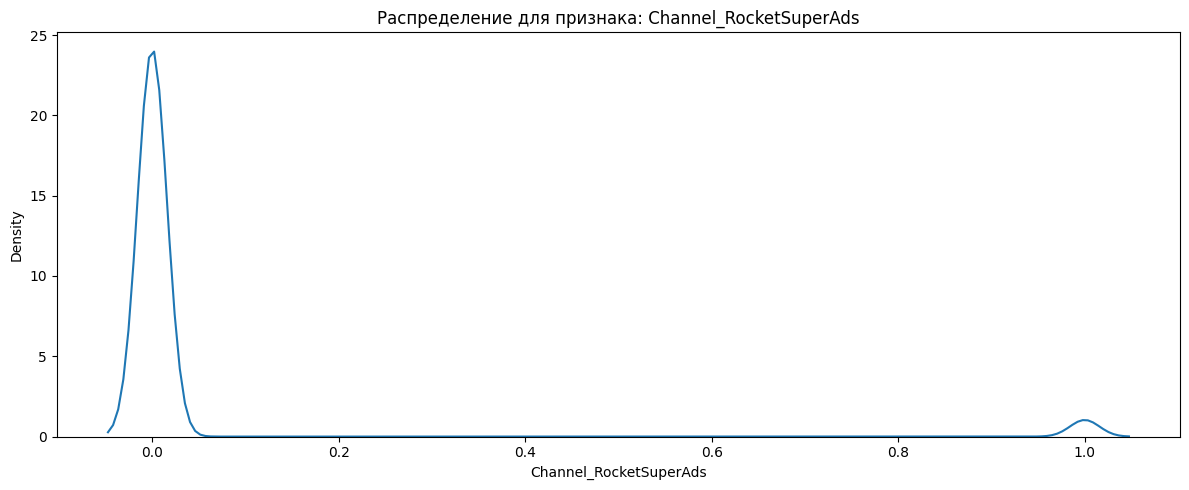

По тесту Шапиро нормальность Channel_RocketSuperAds: False, p_value: 1.3447812978187322e-206
Скошенность распределения Channel_RocketSuperAds: Влево


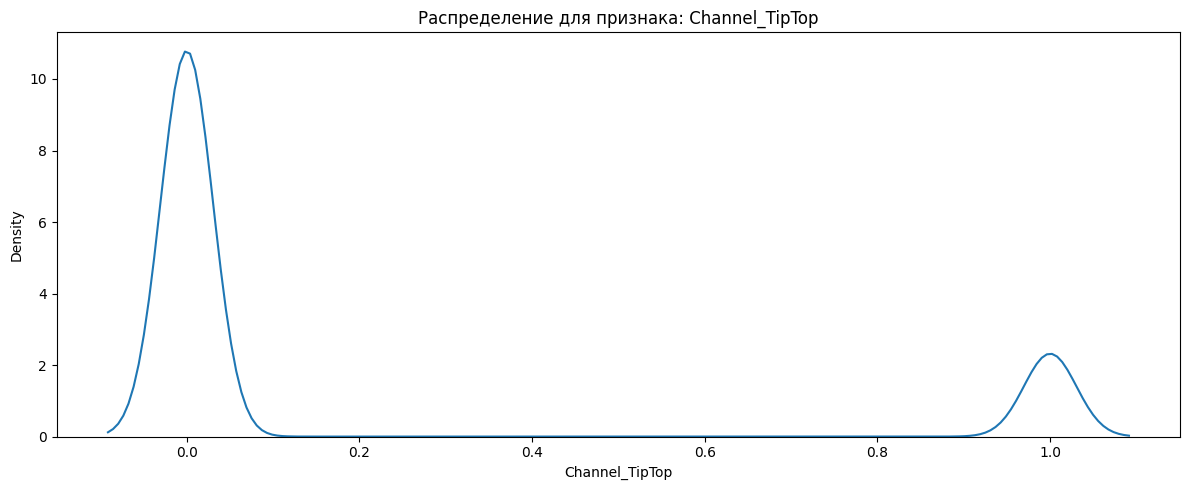

По тесту Шапиро нормальность Channel_TipTop: False, p_value: 1.0284103716313656e-191
Скошенность распределения Channel_TipTop: Влево


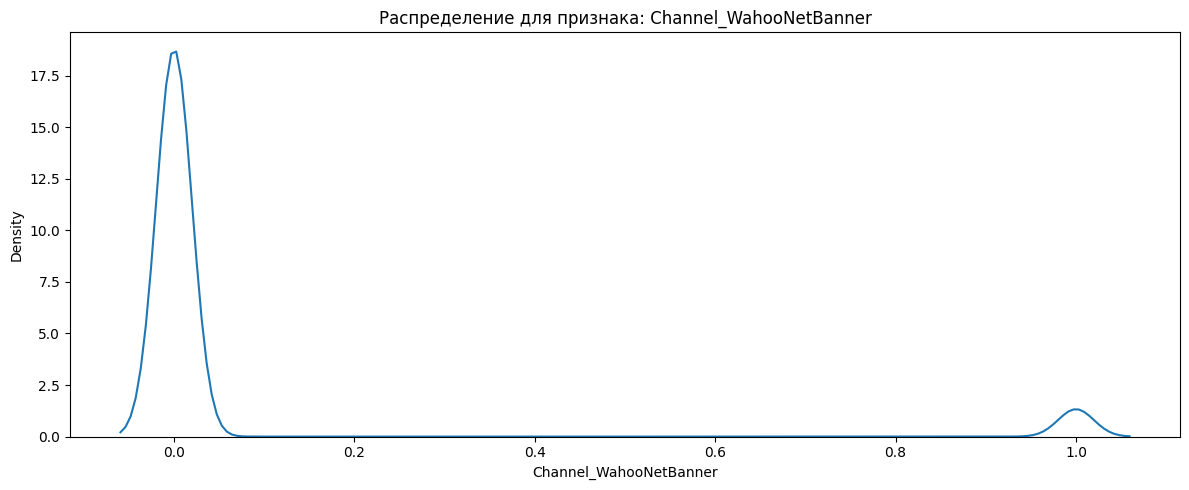

По тесту Шапиро нормальность Channel_WahooNetBanner: False, p_value: 3.75536085104244e-203
Скошенность распределения Channel_WahooNetBanner: Влево


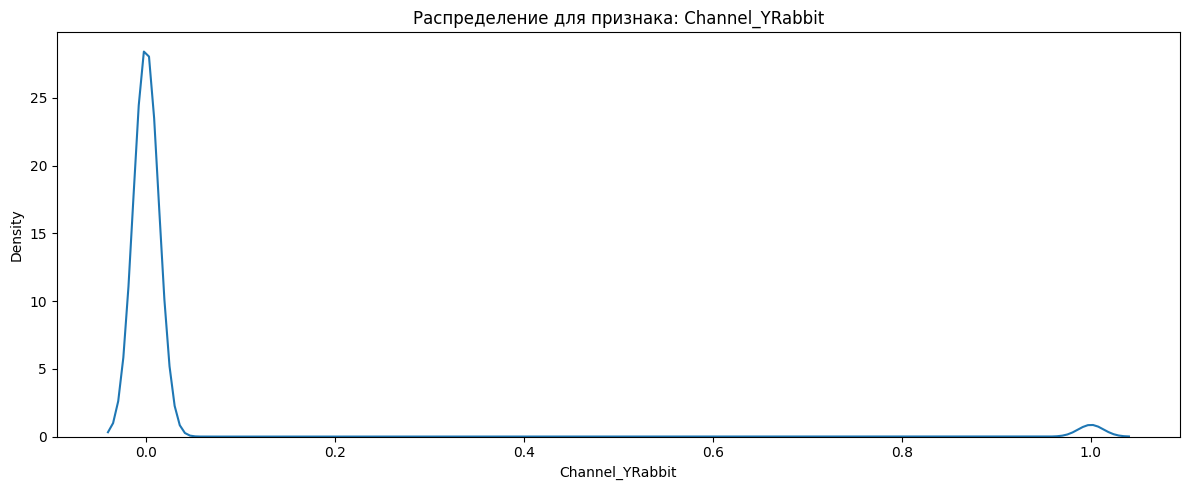

По тесту Шапиро нормальность Channel_YRabbit: False, p_value: 1.8381375422256743e-208
Скошенность распределения Channel_YRabbit: Влево


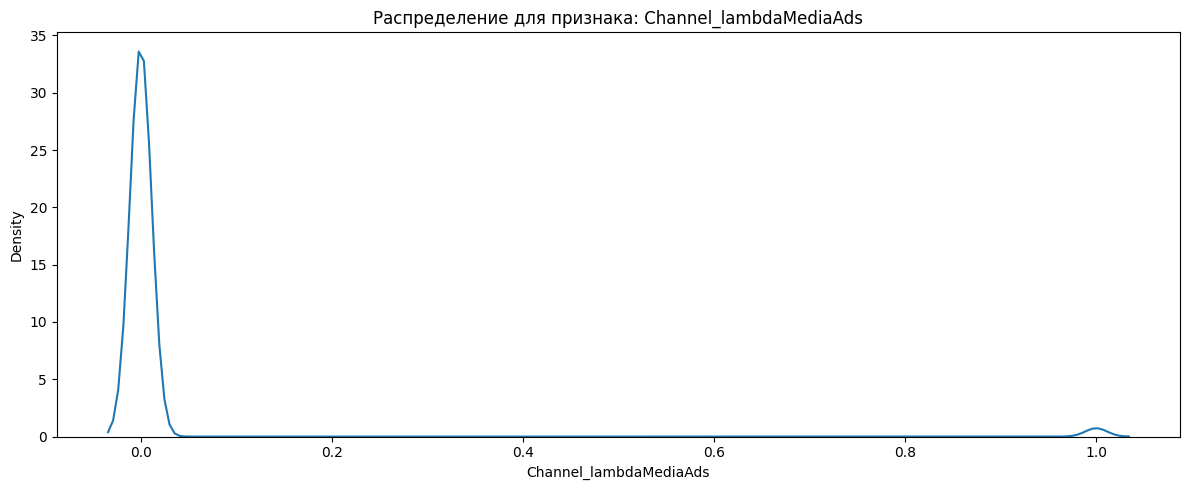

По тесту Шапиро нормальность Channel_lambdaMediaAds: False, p_value: 6.841101830836726e-210
Скошенность распределения Channel_lambdaMediaAds: Влево


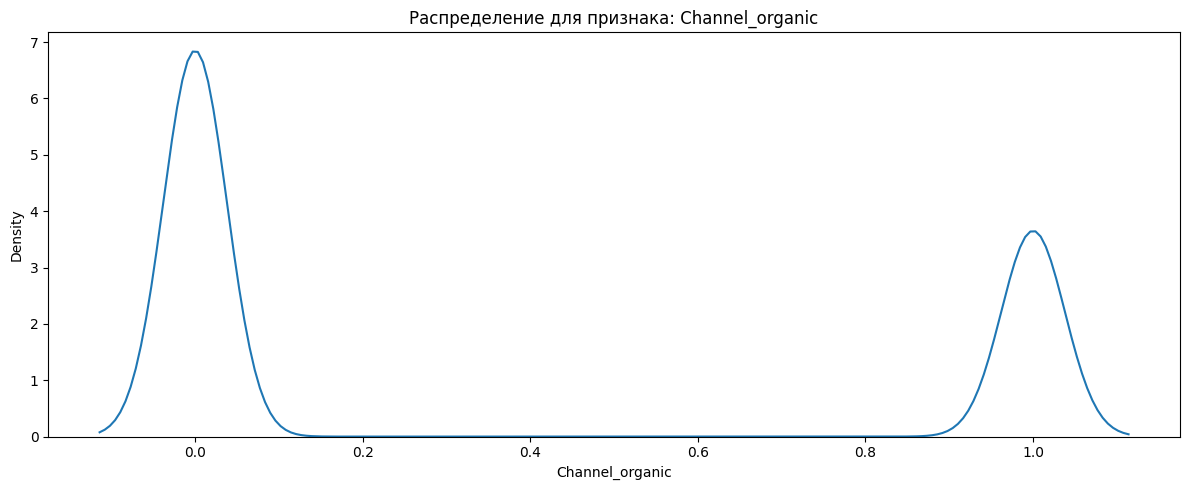

По тесту Шапиро нормальность Channel_organic: False, p_value: 5.954769505412719e-181
Скошенность распределения Channel_organic: Влево


In [37]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for col in visitation.select_dtypes(include=numerics).columns:
    visual_distribution(visitation, col)

<b>Возможные распределения</b>

* month - мультимодальное
* Revenue - распределение Фишера
* Region (все) - распределение Бернулли
* Device (все) - распределение Бернулли
* Channel (все) - распределение Бернулли

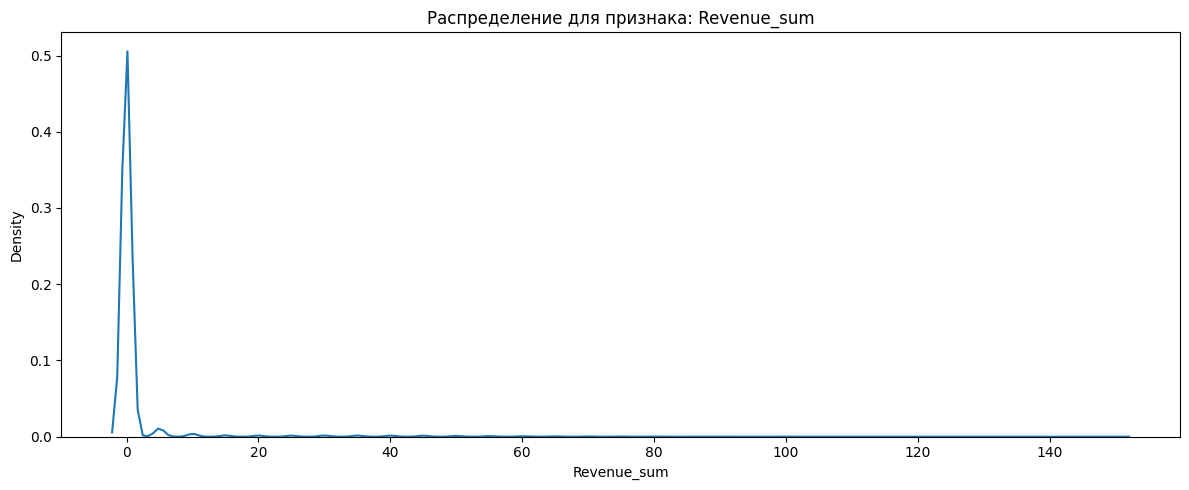

По тесту Шапиро нормальность Revenue_sum: False, p_value: 8.698504204586085e-189
Скошенность распределения Revenue_sum: Влево


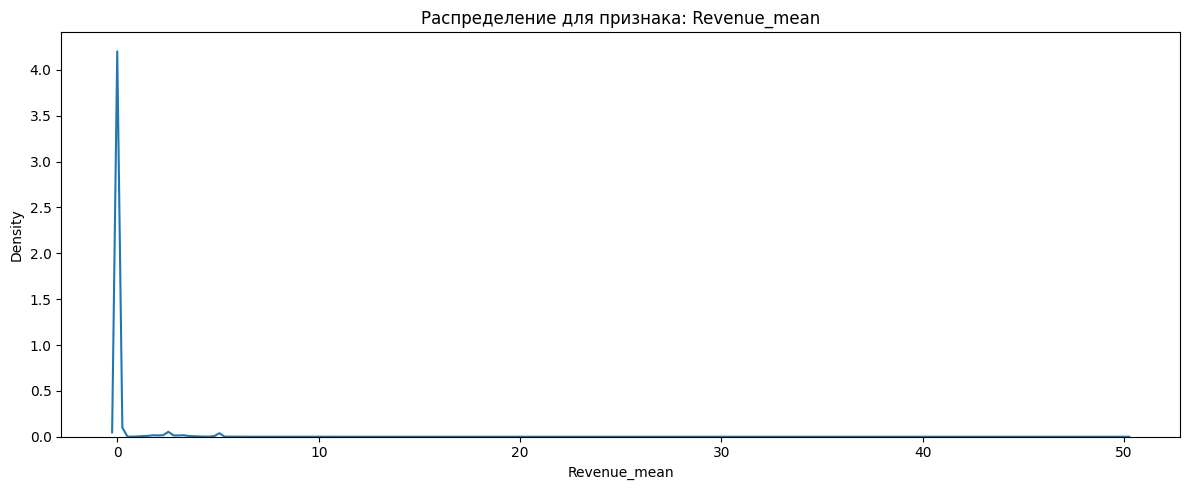

По тесту Шапиро нормальность Revenue_mean: False, p_value: 3.387431409770052e-188
Скошенность распределения Revenue_mean: Влево


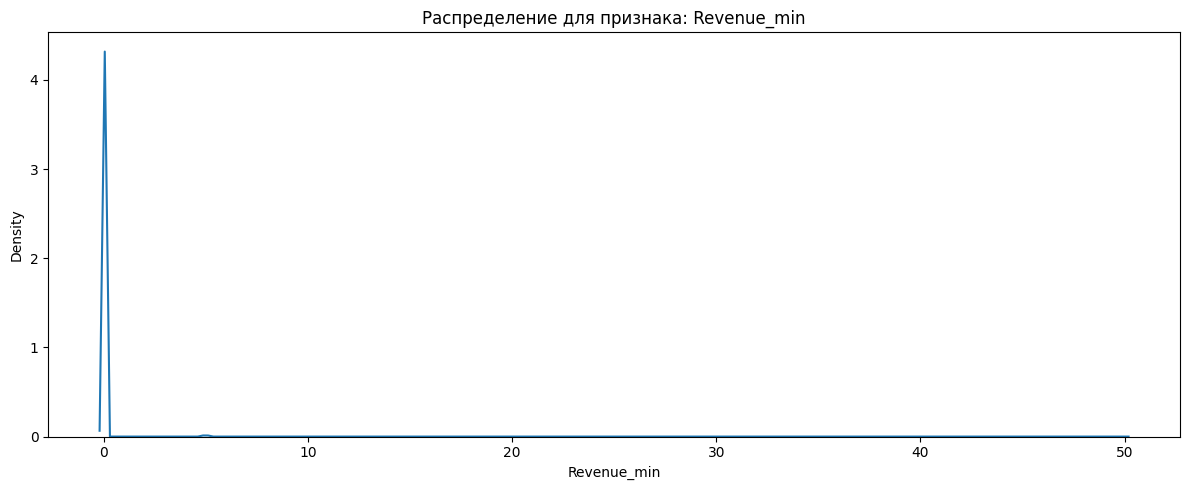

По тесту Шапиро нормальность Revenue_min: False, p_value: 1.286962819302269e-193
Скошенность распределения Revenue_min: Влево


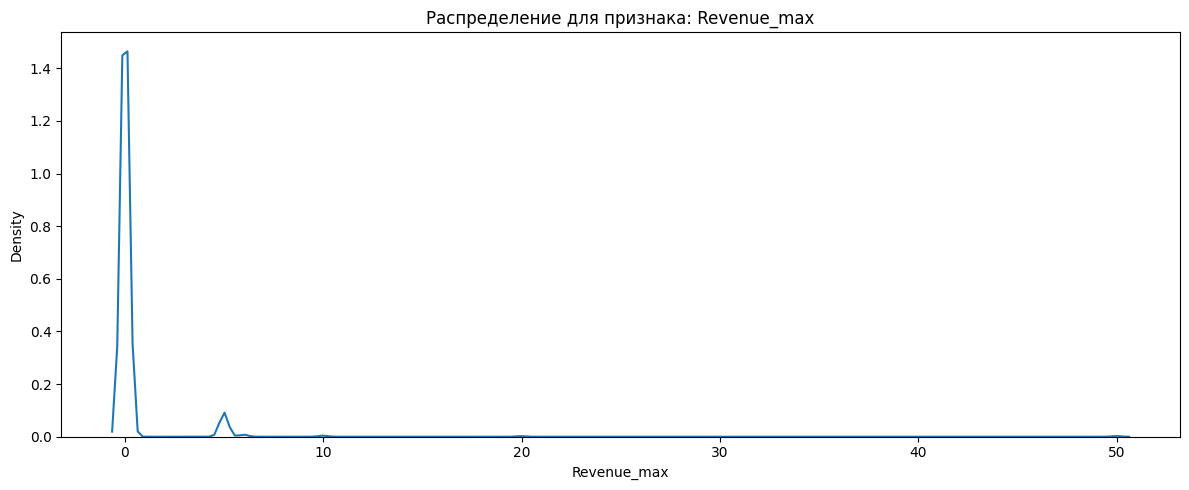

По тесту Шапиро нормальность Revenue_max: False, p_value: 2.5206772040862275e-190
Скошенность распределения Revenue_max: Влево


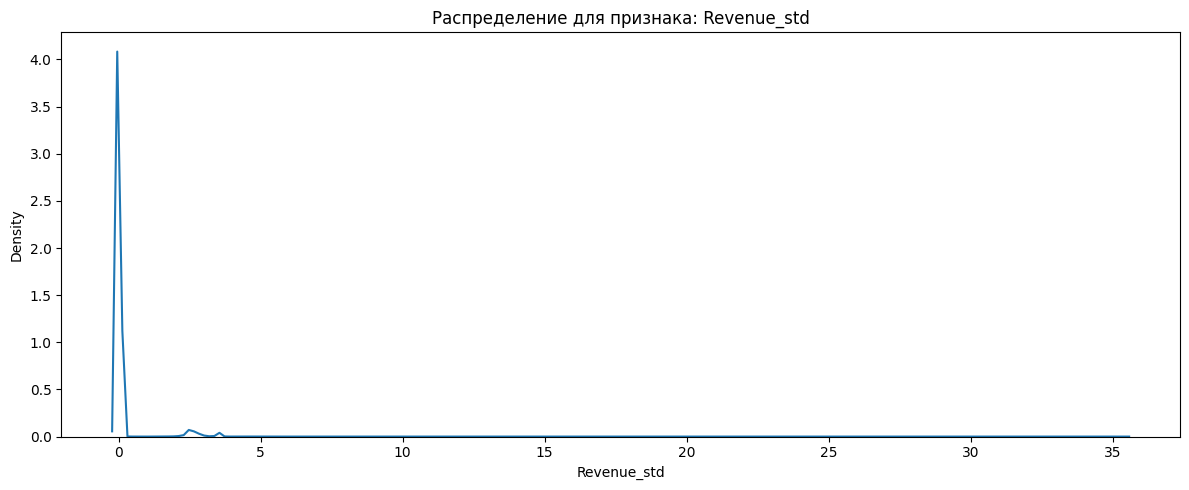

По тесту Шапиро нормальность Revenue_std: False, p_value: 2.6363159548227463e-189
Скошенность распределения Revenue_std: Влево


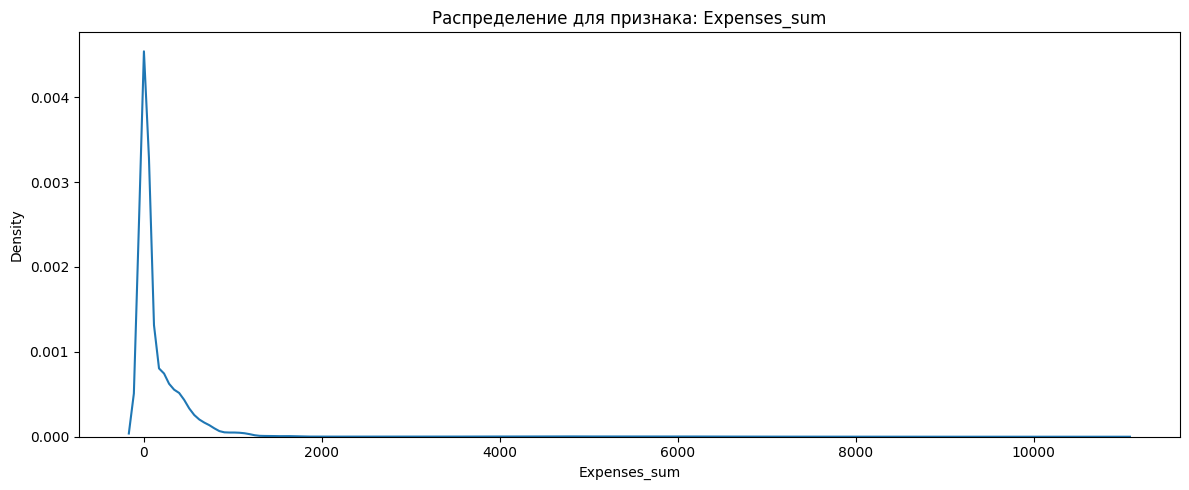

По тесту Шапиро нормальность Expenses_sum: False, p_value: 9.423838078960889e-183
Скошенность распределения Expenses_sum: Влево


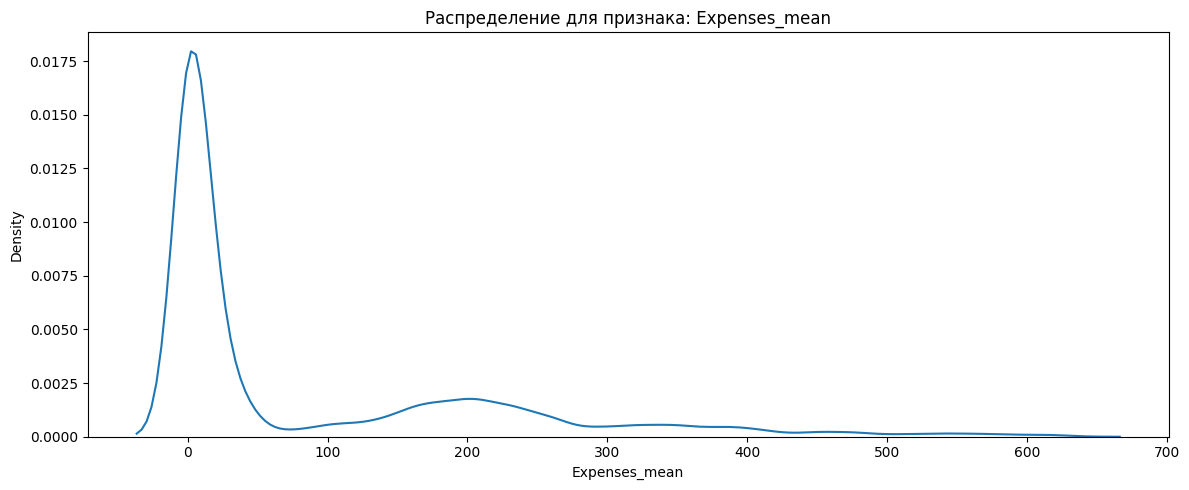

По тесту Шапиро нормальность Expenses_mean: False, p_value: 6.973078580103685e-154
Скошенность распределения Expenses_mean: Влево


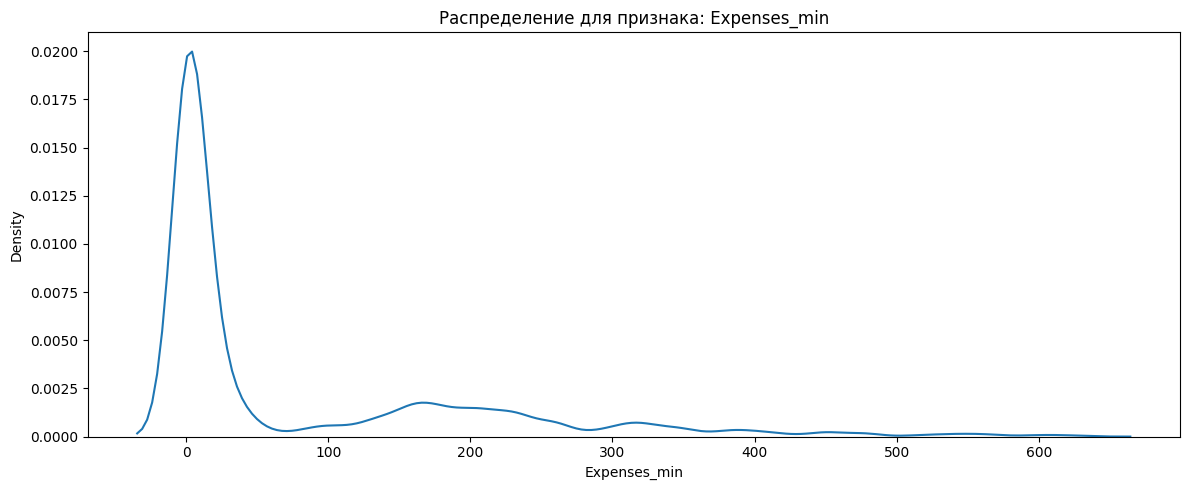

По тесту Шапиро нормальность Expenses_min: False, p_value: 2.505043310450711e-156
Скошенность распределения Expenses_min: Влево


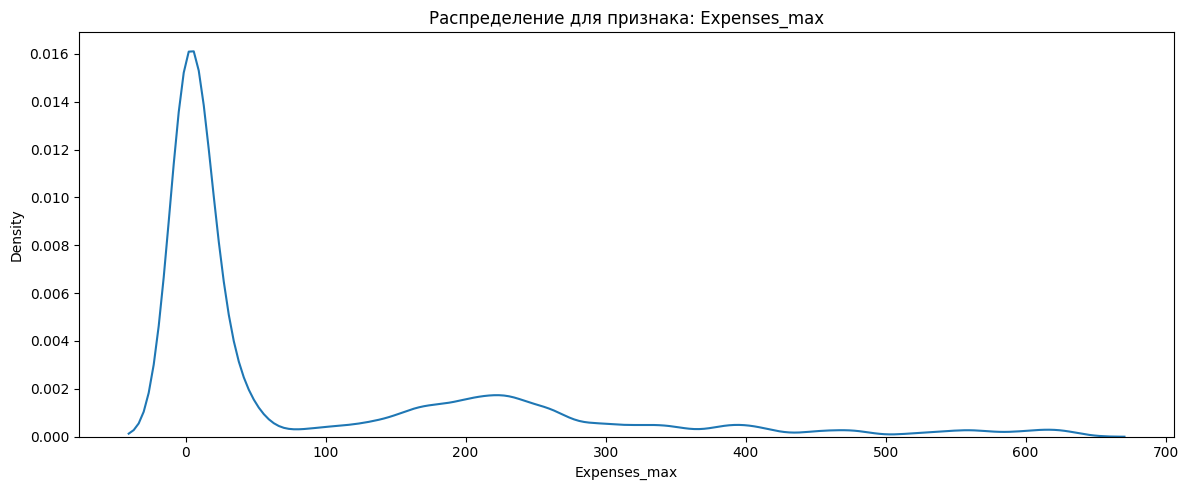

По тесту Шапиро нормальность Expenses_max: False, p_value: 2.0310499606084468e-154
Скошенность распределения Expenses_max: Влево


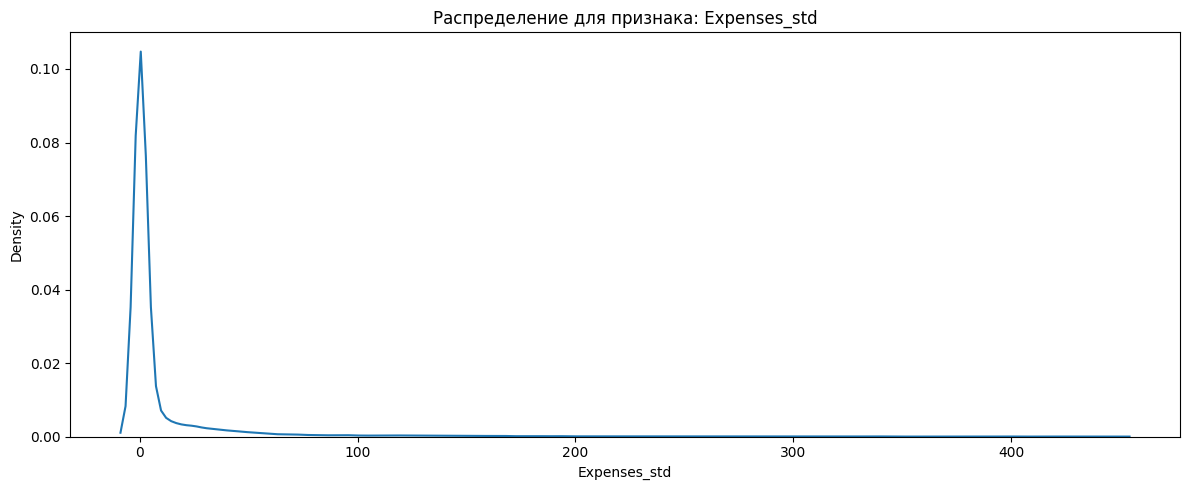

По тесту Шапиро нормальность Expenses_std: False, p_value: 9.778647338764126e-182
Скошенность распределения Expenses_std: Влево


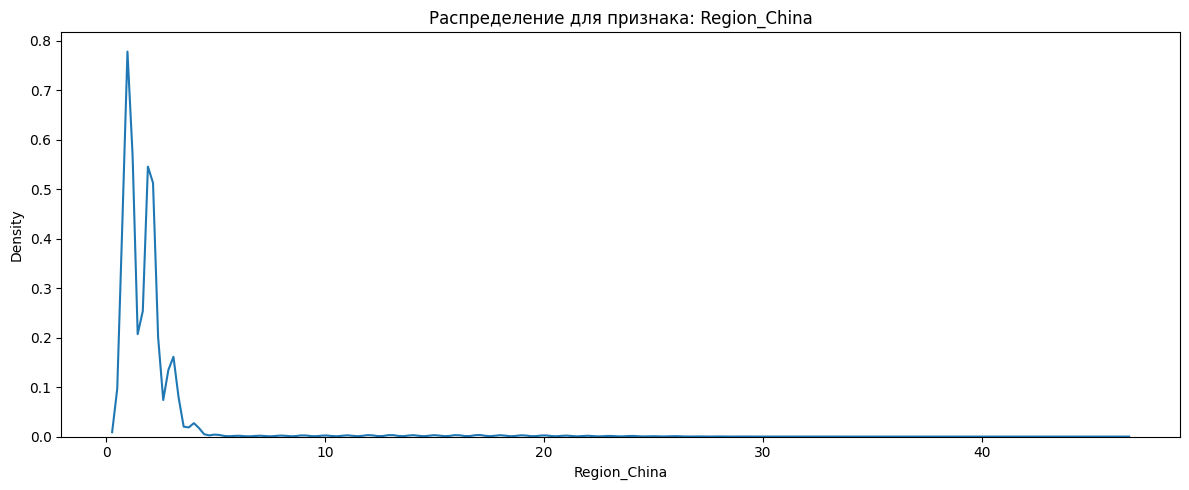

По тесту Шапиро нормальность Region_China: False, p_value: 1.9130714435569172e-180
Скошенность распределения Region_China: Влево


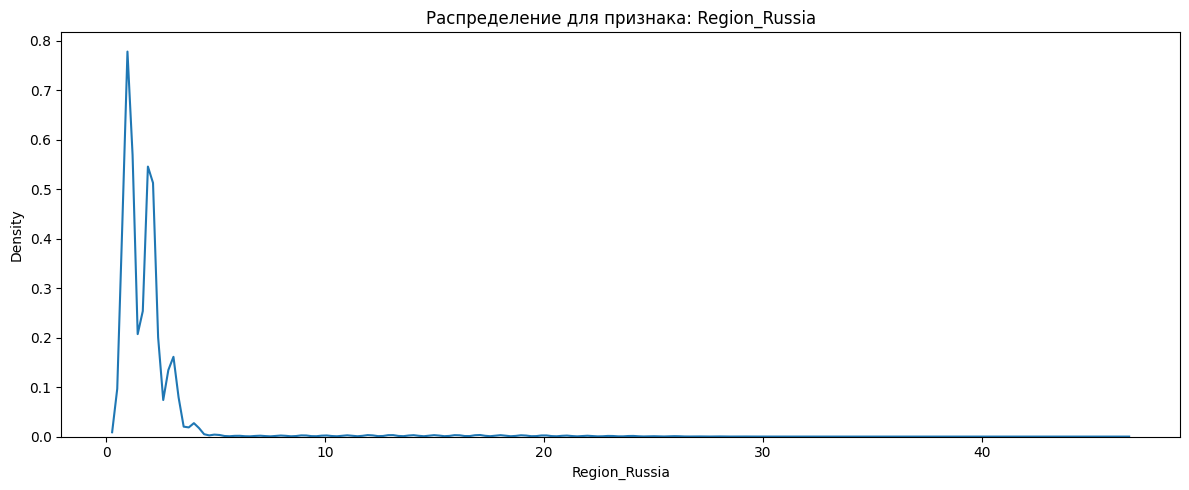

По тесту Шапиро нормальность Region_Russia: False, p_value: 1.9130714435569172e-180
Скошенность распределения Region_Russia: Влево


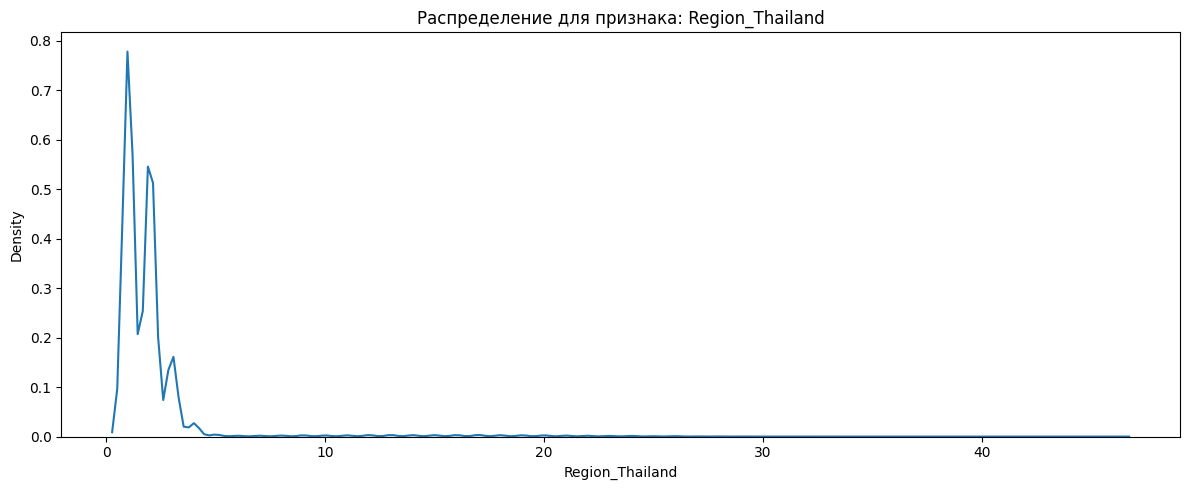

По тесту Шапиро нормальность Region_Thailand: False, p_value: 1.9130714435569172e-180
Скошенность распределения Region_Thailand: Влево


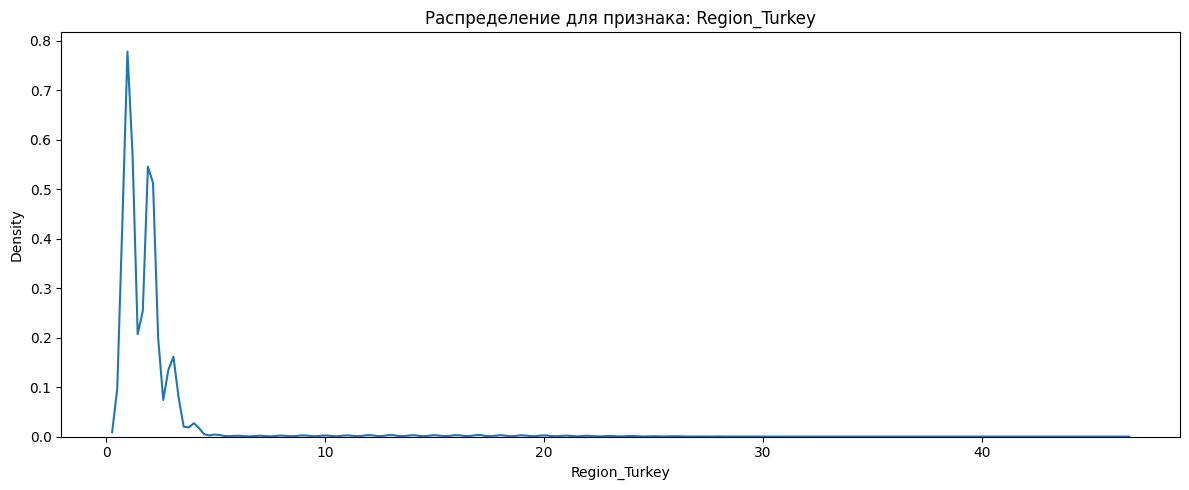

По тесту Шапиро нормальность Region_Turkey: False, p_value: 1.9130714435569172e-180
Скошенность распределения Region_Turkey: Влево


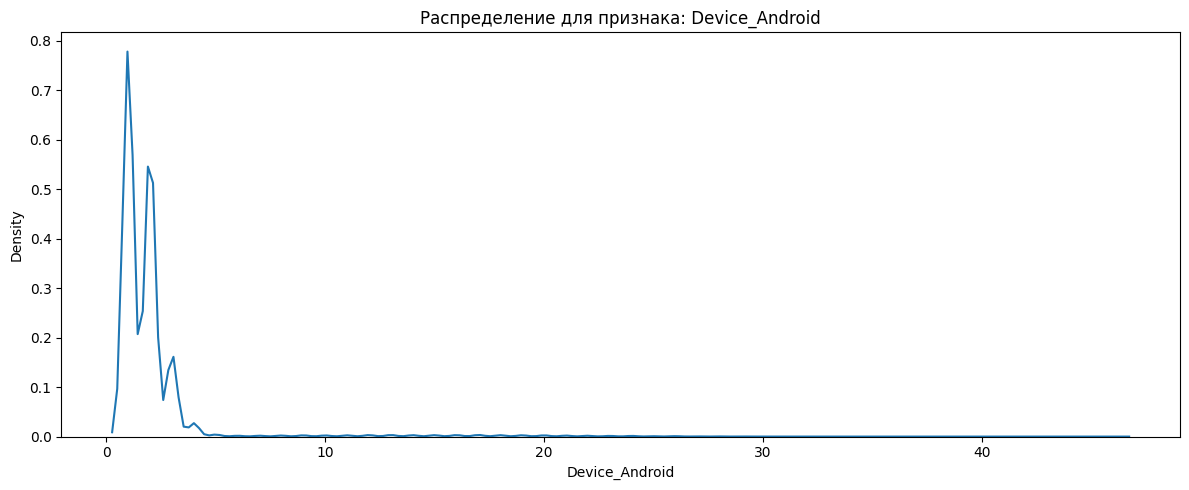

По тесту Шапиро нормальность Device_Android: False, p_value: 1.9130714435569172e-180
Скошенность распределения Device_Android: Влево


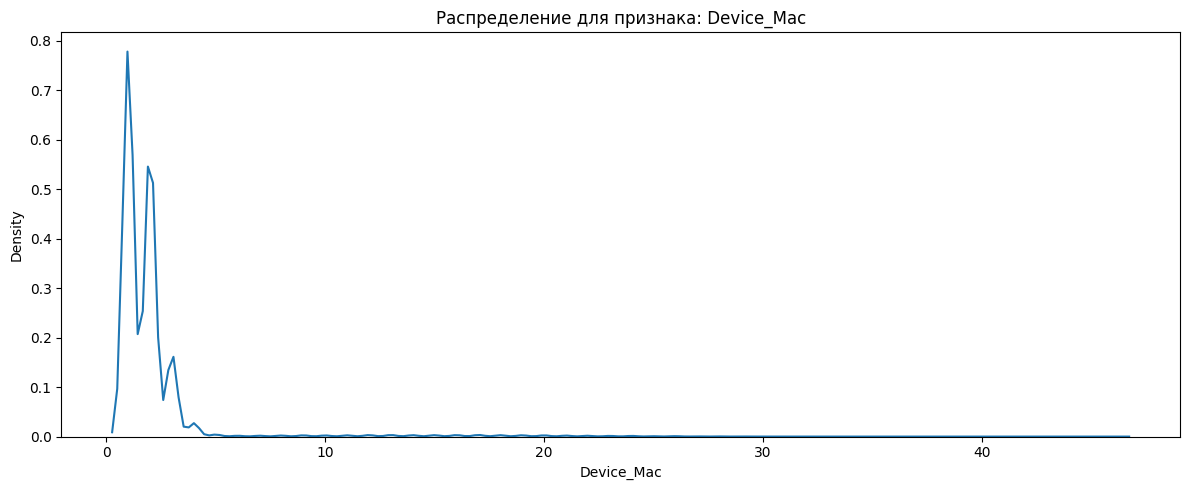

По тесту Шапиро нормальность Device_Mac: False, p_value: 1.9130714435569172e-180
Скошенность распределения Device_Mac: Влево


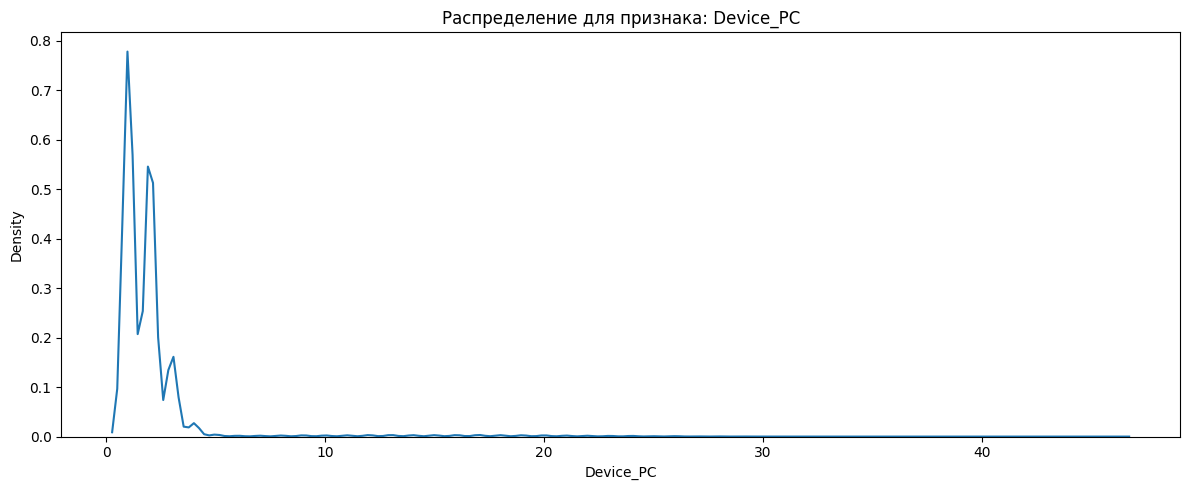

По тесту Шапиро нормальность Device_PC: False, p_value: 1.9130714435569172e-180
Скошенность распределения Device_PC: Влево


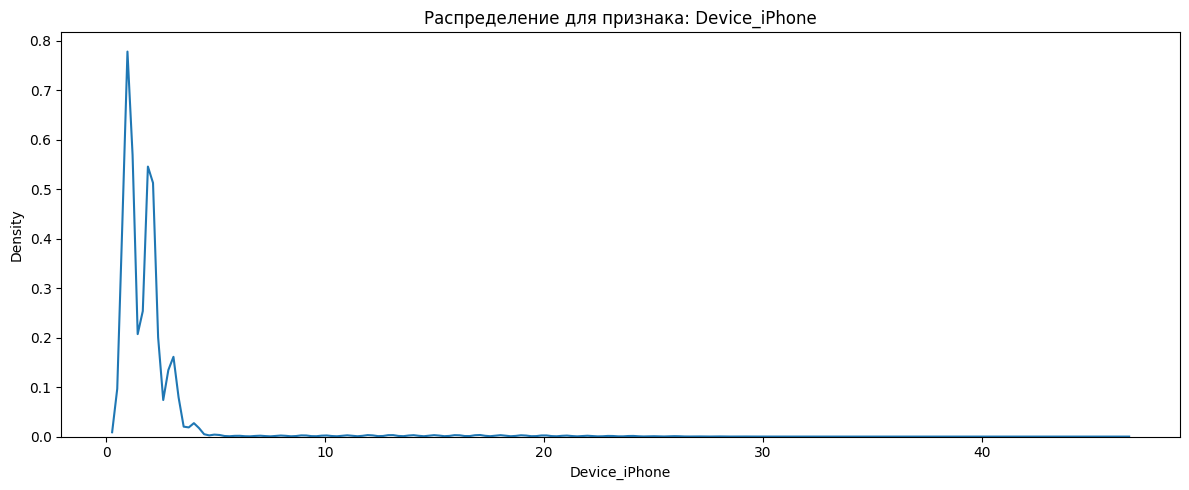

По тесту Шапиро нормальность Device_iPhone: False, p_value: 1.9130714435569172e-180
Скошенность распределения Device_iPhone: Влево


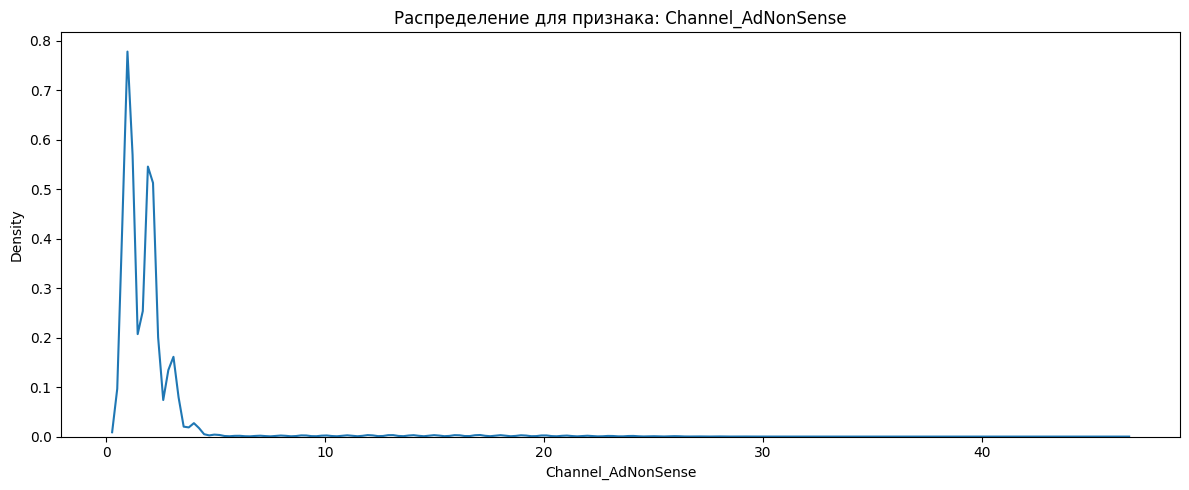

По тесту Шапиро нормальность Channel_AdNonSense: False, p_value: 1.9130714435569172e-180
Скошенность распределения Channel_AdNonSense: Влево


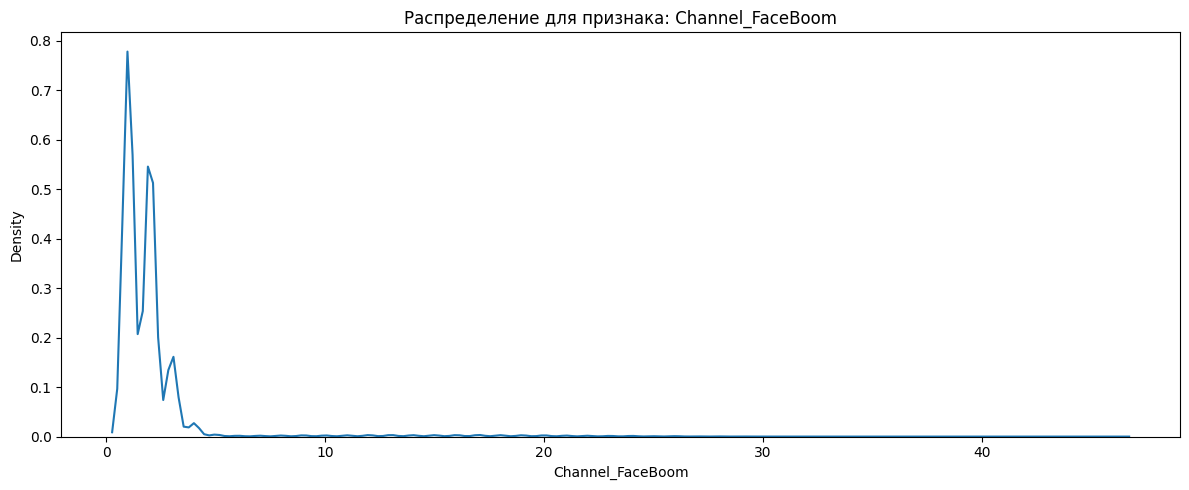

По тесту Шапиро нормальность Channel_FaceBoom: False, p_value: 1.9130714435569172e-180
Скошенность распределения Channel_FaceBoom: Влево


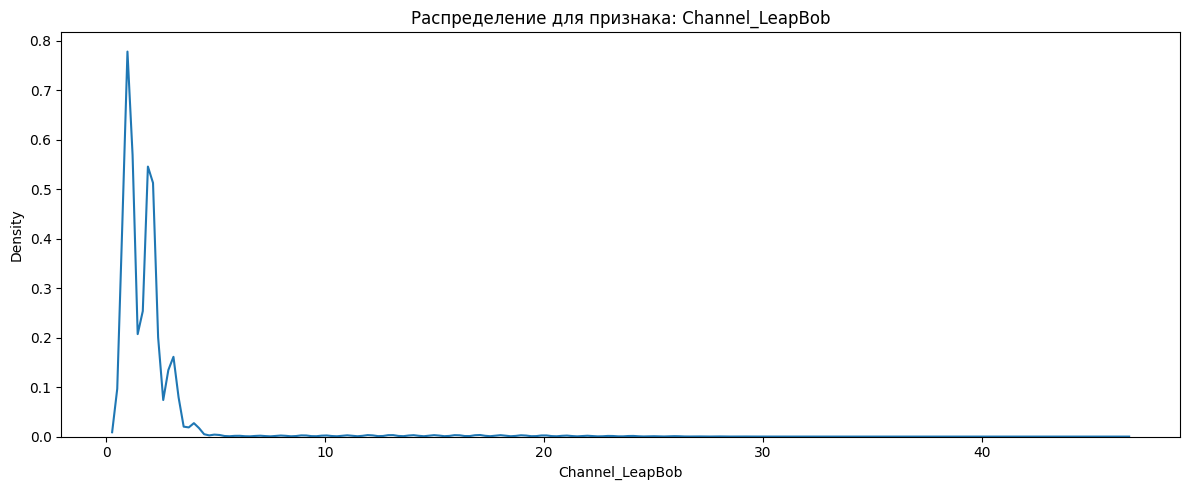

По тесту Шапиро нормальность Channel_LeapBob: False, p_value: 1.9130714435569172e-180
Скошенность распределения Channel_LeapBob: Влево


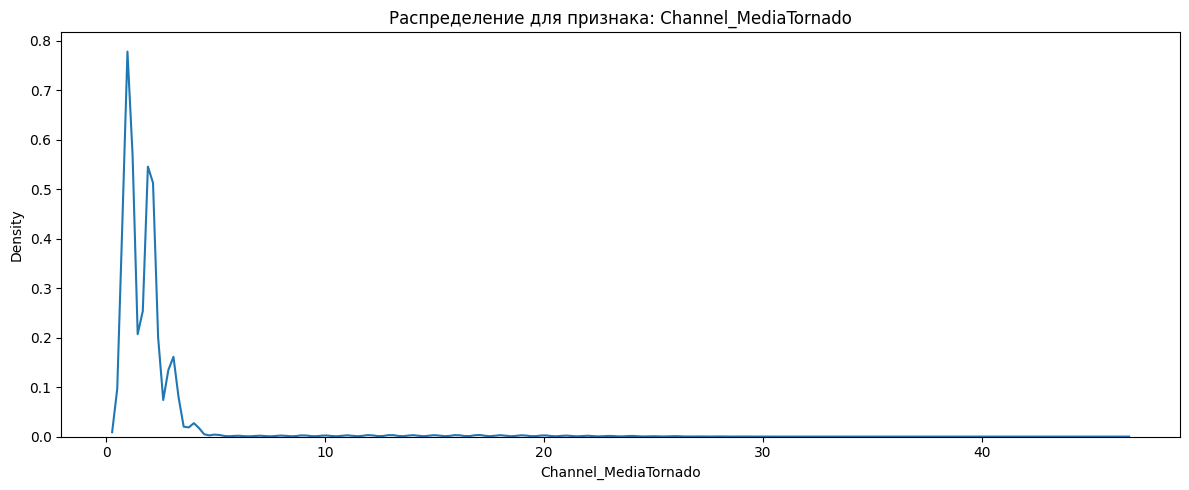

По тесту Шапиро нормальность Channel_MediaTornado: False, p_value: 1.9130714435569172e-180
Скошенность распределения Channel_MediaTornado: Влево


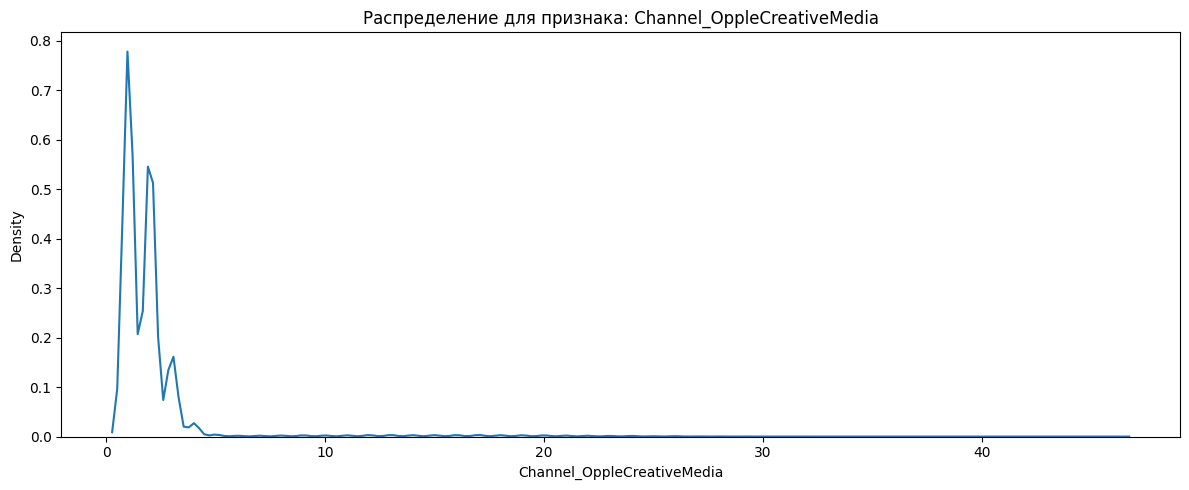

По тесту Шапиро нормальность Channel_OppleCreativeMedia: False, p_value: 1.9130714435569172e-180
Скошенность распределения Channel_OppleCreativeMedia: Влево


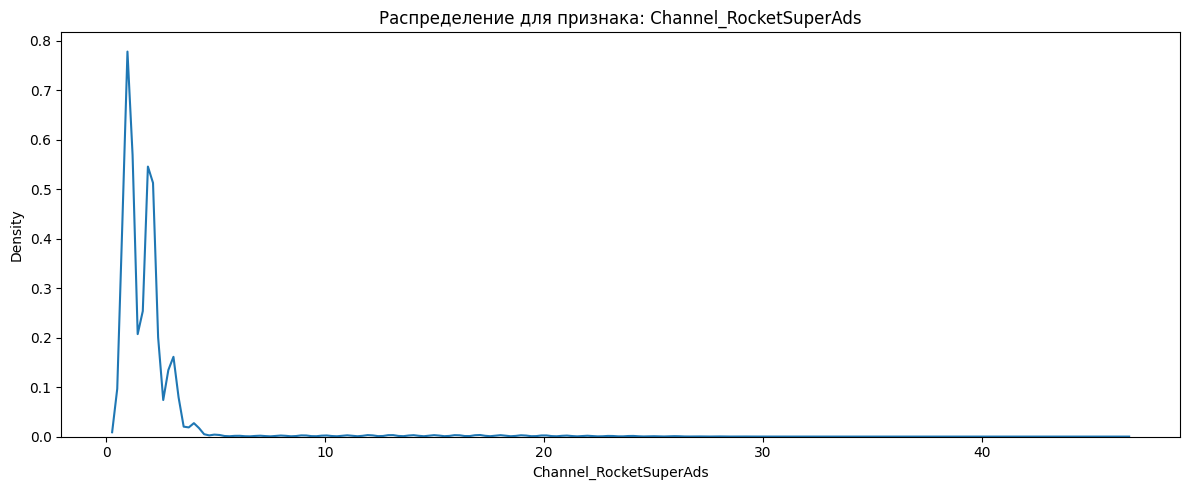

По тесту Шапиро нормальность Channel_RocketSuperAds: False, p_value: 1.9130714435569172e-180
Скошенность распределения Channel_RocketSuperAds: Влево


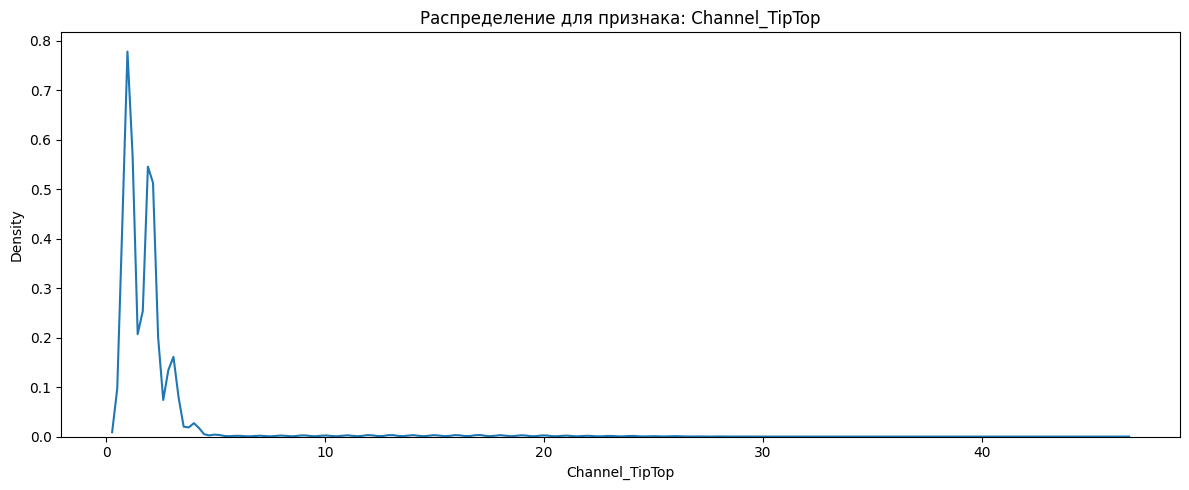

По тесту Шапиро нормальность Channel_TipTop: False, p_value: 1.9130714435569172e-180
Скошенность распределения Channel_TipTop: Влево


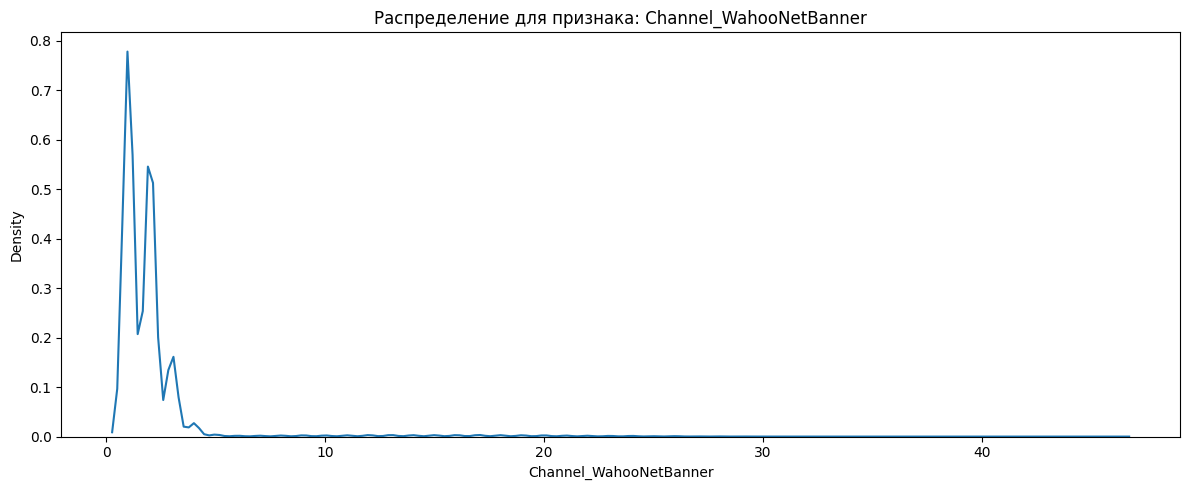

По тесту Шапиро нормальность Channel_WahooNetBanner: False, p_value: 1.9130714435569172e-180
Скошенность распределения Channel_WahooNetBanner: Влево


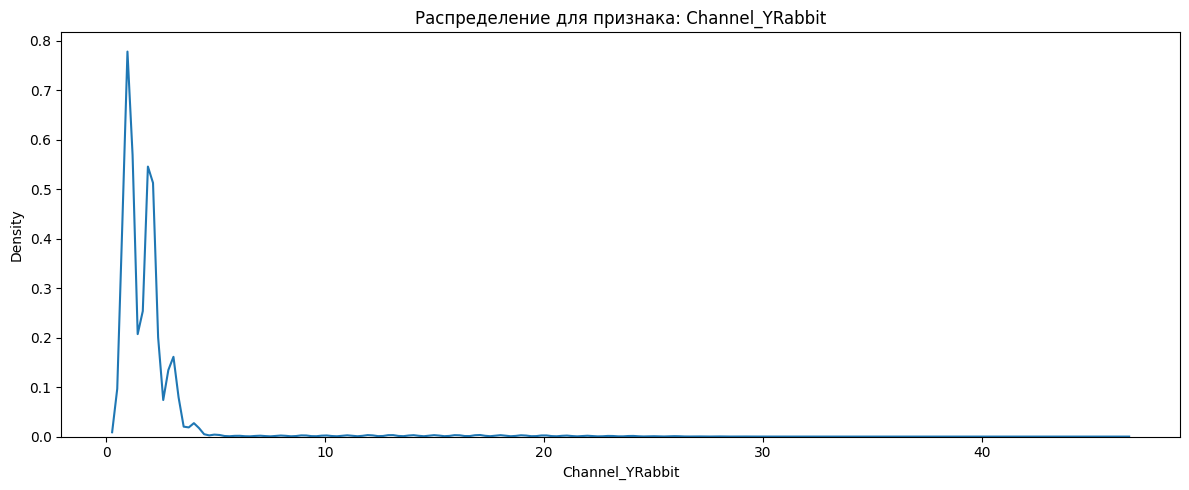

По тесту Шапиро нормальность Channel_YRabbit: False, p_value: 1.9130714435569172e-180
Скошенность распределения Channel_YRabbit: Влево


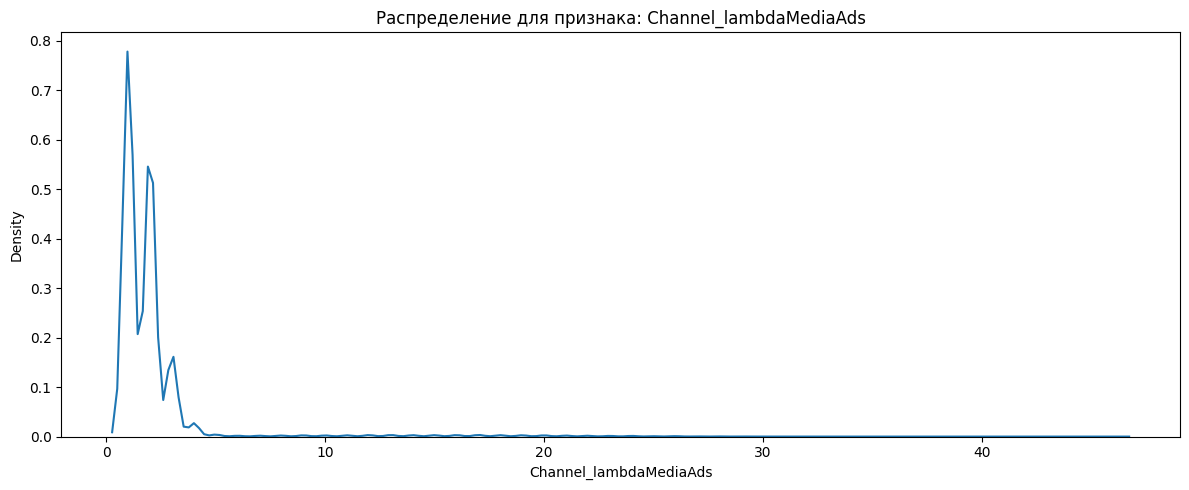

По тесту Шапиро нормальность Channel_lambdaMediaAds: False, p_value: 1.9130714435569172e-180
Скошенность распределения Channel_lambdaMediaAds: Влево


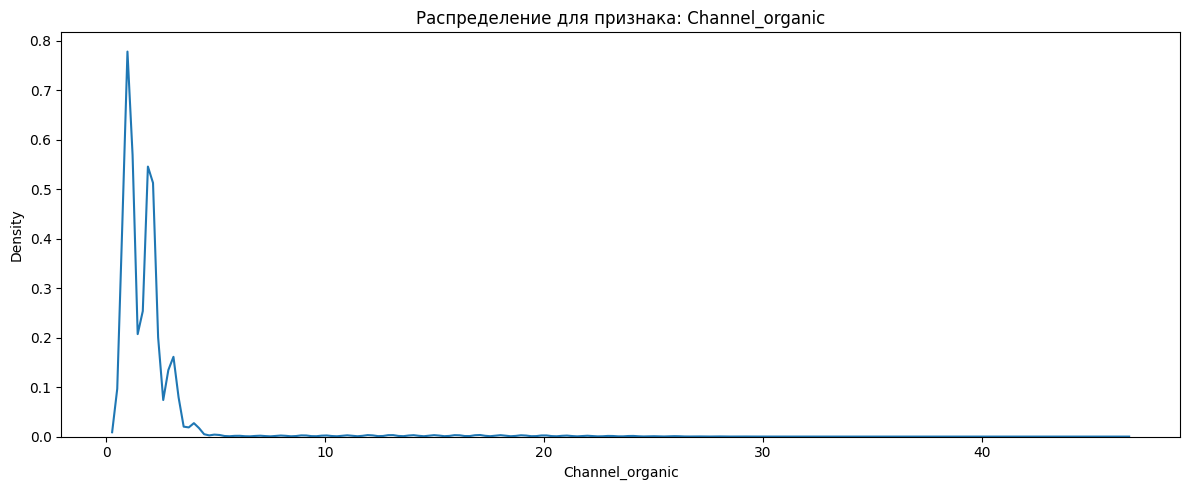

По тесту Шапиро нормальность Channel_organic: False, p_value: 1.9130714435569172e-180
Скошенность распределения Channel_organic: Влево


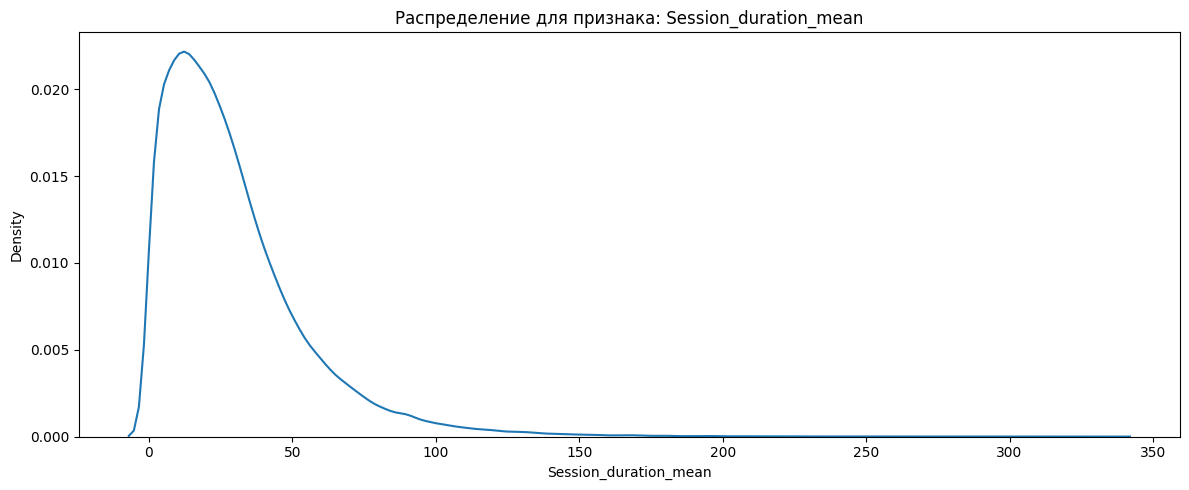

По тесту Шапиро нормальность Session_duration_mean: False, p_value: 3.4632902626638053e-133
Скошенность распределения Session_duration_mean: Влево


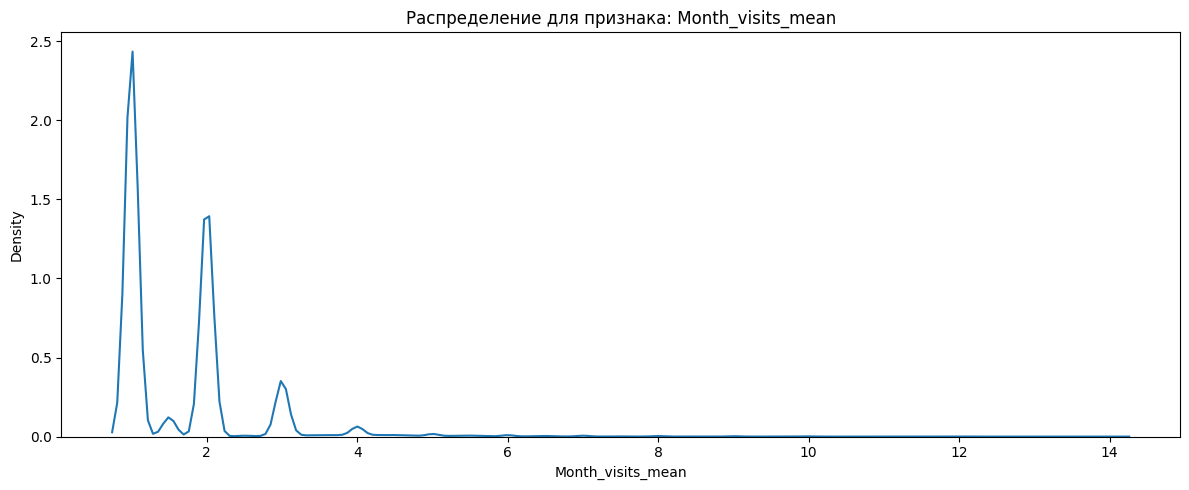

По тесту Шапиро нормальность Month_visits_mean: False, p_value: 1.534379962556944e-157
Скошенность распределения Month_visits_mean: Влево


In [38]:
for col in user_data.select_dtypes(include=numerics).columns:
    visual_distribution(user_data, col)

<b>Возможные распределения</b>

* Revenue (все) - распределение Фишера
* Expenses (sum, mean, max, min) - экспоненциальное распределение
* Expenses (std) - распределение Фишера
* Region (все) - мультимодальное
* Device (все) - мультимодальное
* Session_duration_mean - Гамма-распределение
* Month_visits_mean - мультимодальное

## Числовые характеристики датасета

### Суммарное количество клиентов по каждому из каналов в каждом месяце

In [39]:
visitation_2 = pd.read_csv("visitation.csv")

In [40]:
visitation_2["Session Start"] = pd.to_datetime(visitation["Session Start"])
visitation_2["Session End"] = pd.to_datetime(visitation["Session End"])

visitation_2["month"] = visitation_2["Session Start"].dt.month

In [41]:
def count_users_by_month(month):
    users_count = visitation_2[visitation_2["month"] == month].groupby("Channel")["User Id"].nunique()

    plt.figure(figsize=(14, 6))
    splot = sns.barplot(x=users_count.index, y=users_count.values)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.1f'), 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha = 'center', va = 'center', 
            xytext = (0, 9), 
            textcoords = 'offset points')
    plt.xticks(rotation=45)
    plt.title(f"Кол-во пользователей по каналам за месяц номер: {month}")

    return users_count


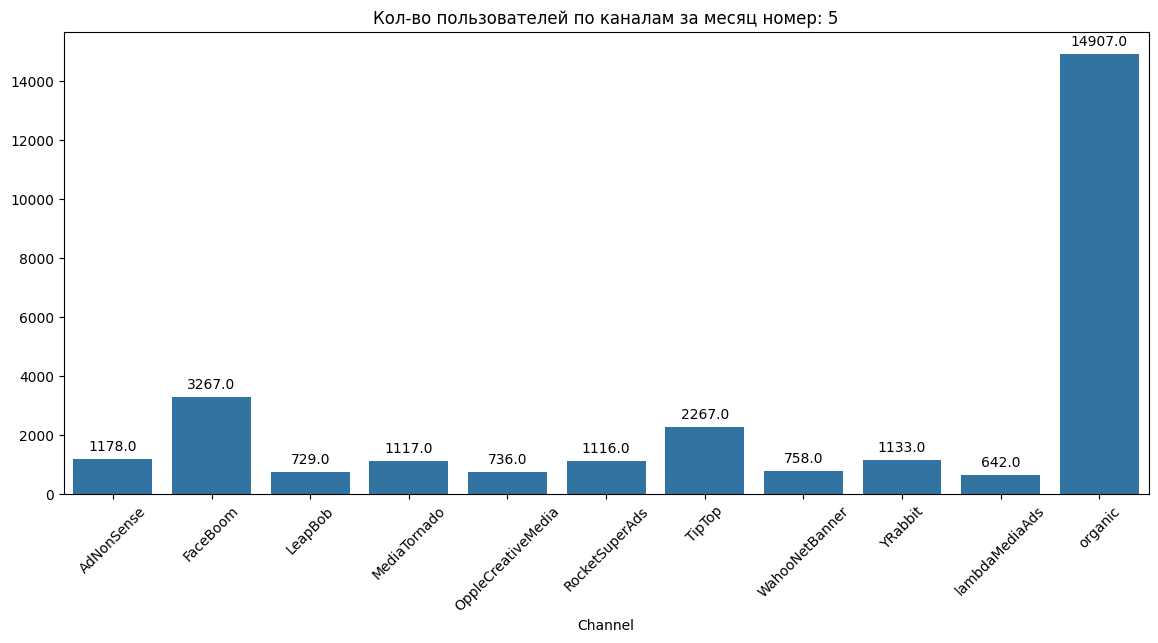

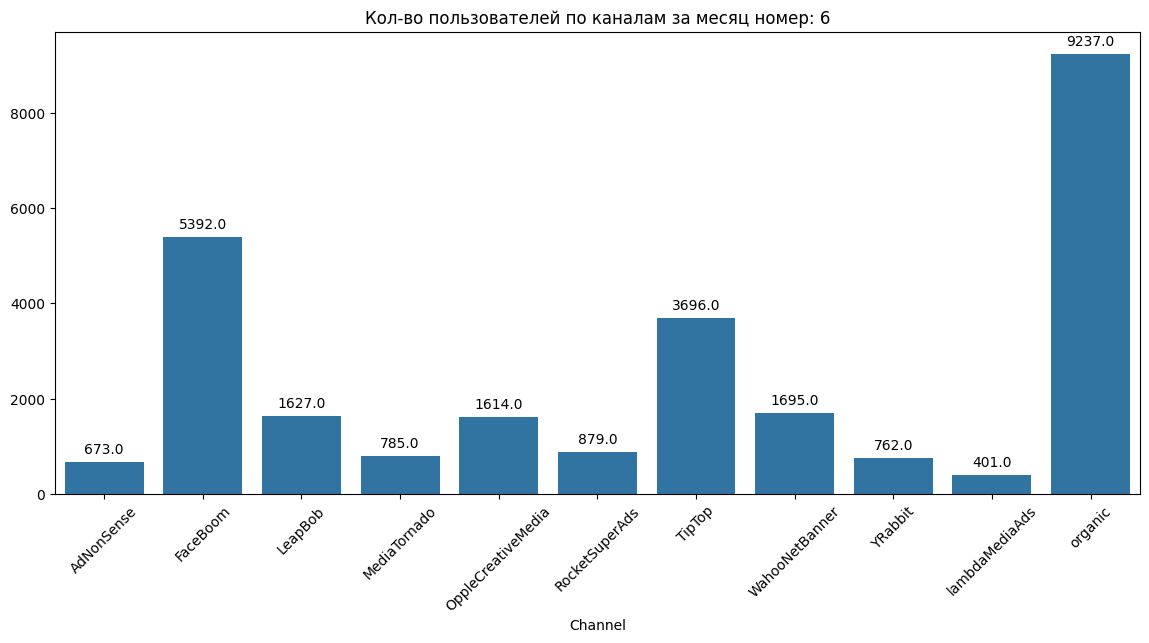

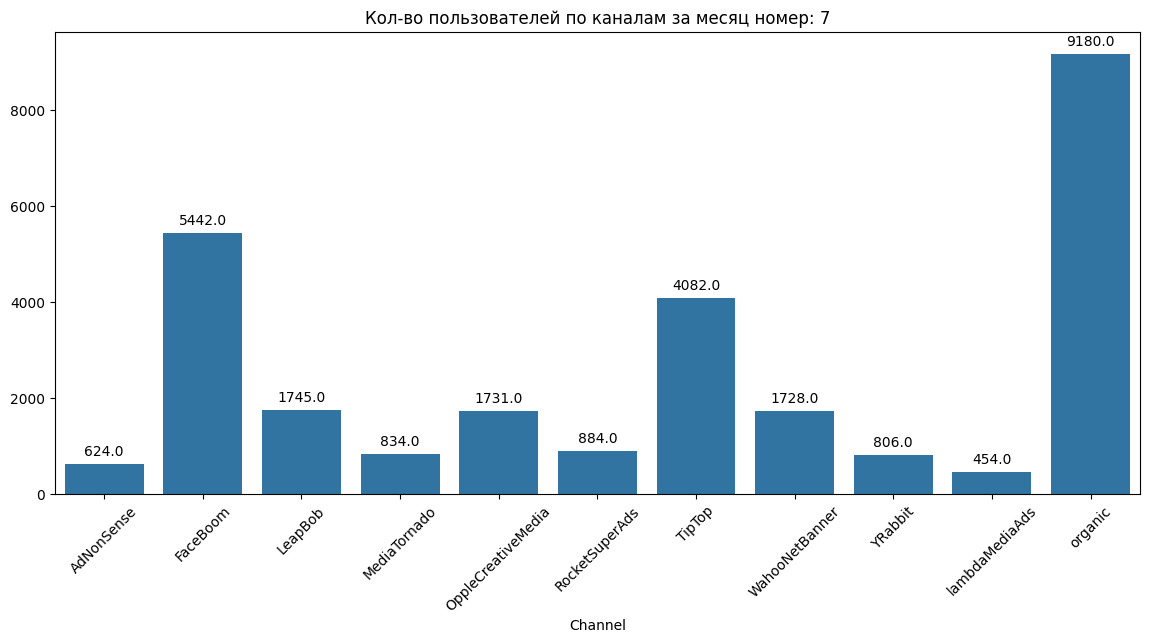

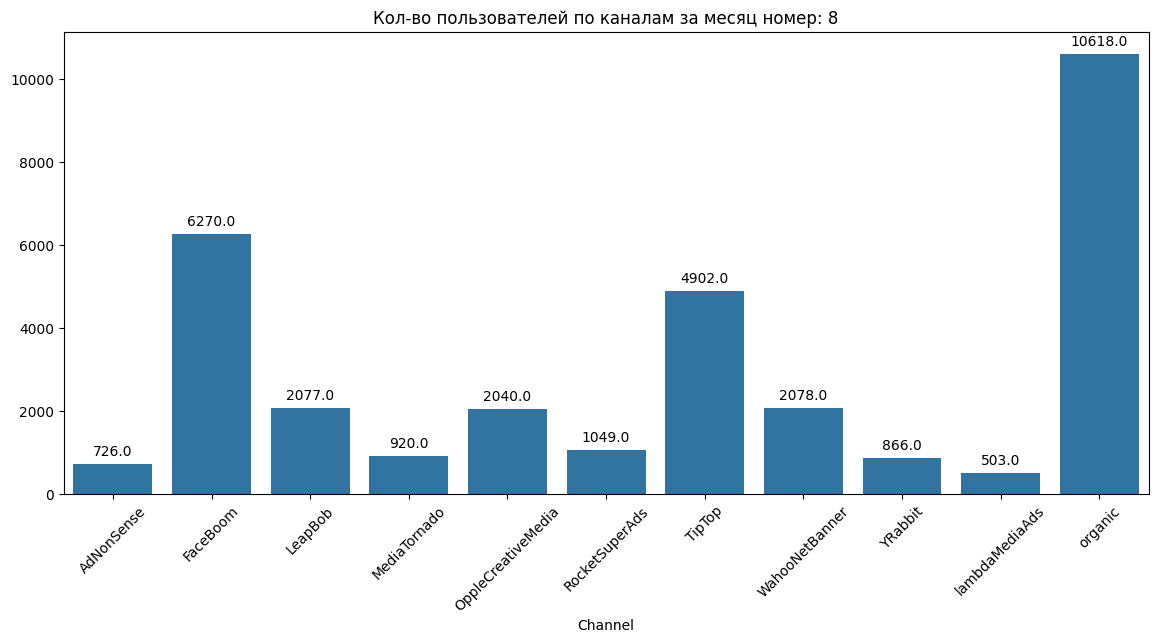

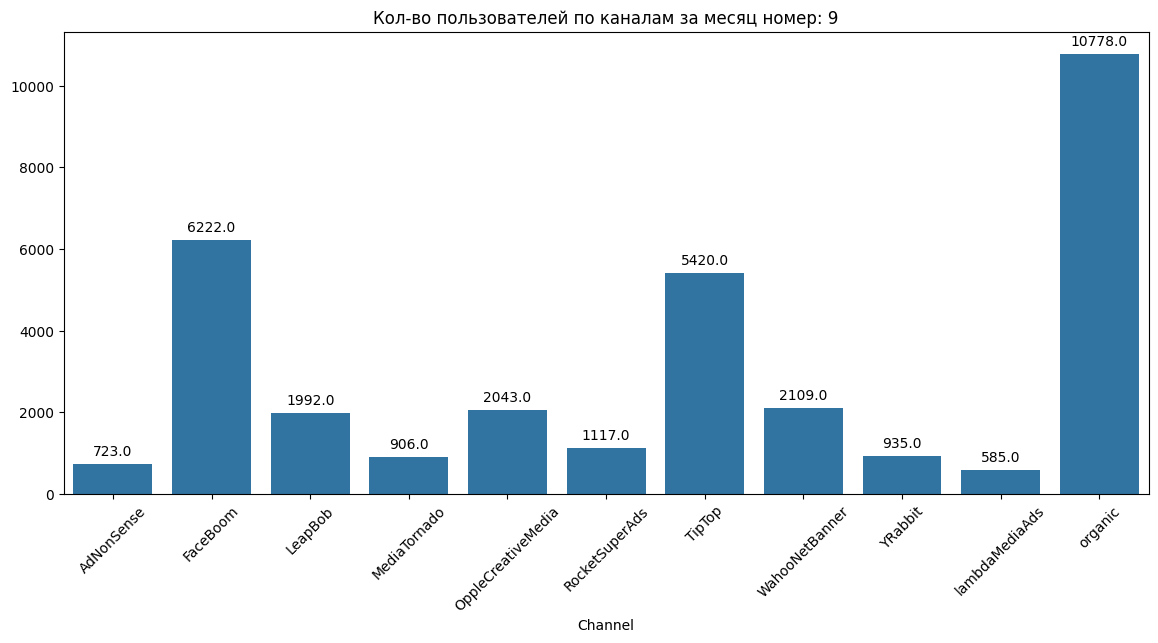

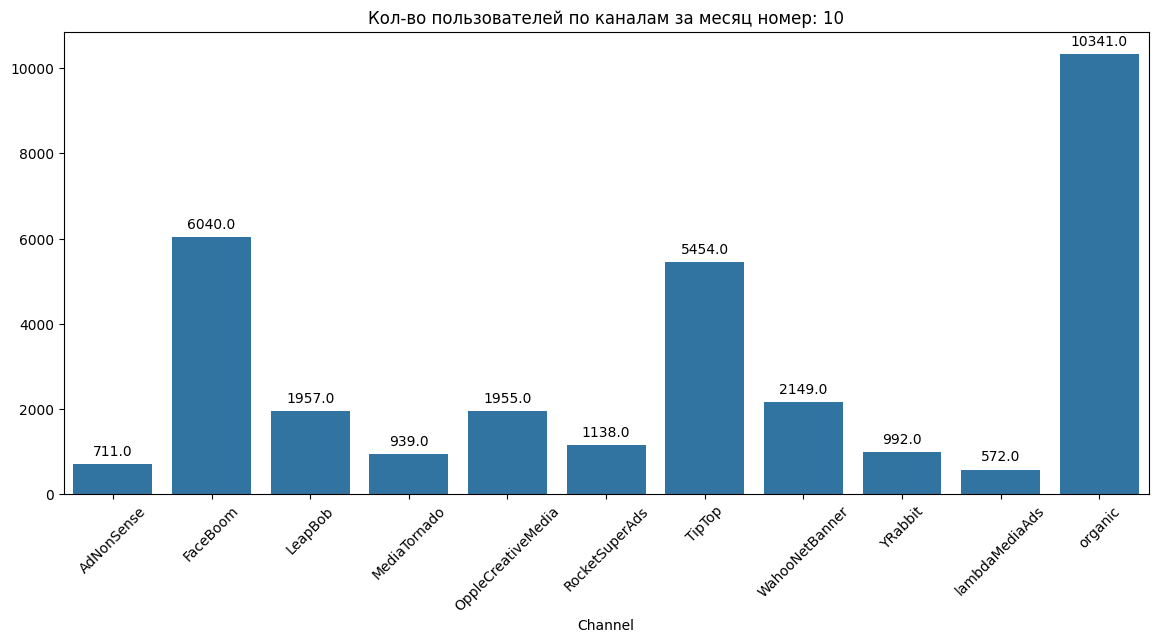

In [42]:
for month in visitation_2["month"].unique():
    count_users_by_month(month)

### Динамику изменения количества клиентов и прибыли по месяцам

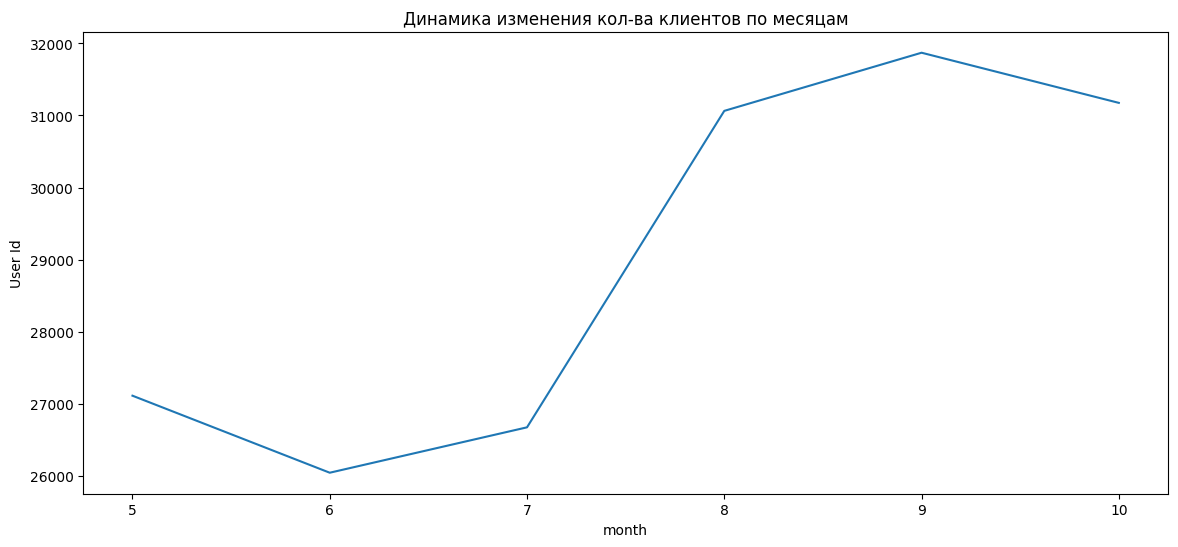

In [43]:
users_count_by_month = visitation.groupby("month")["User Id"].nunique()

plt.figure(figsize=(14, 6))
sns.lineplot(users_count_by_month)
plt.title("Динамика изменения кол-ва клиентов по месяцам")
plt.show()

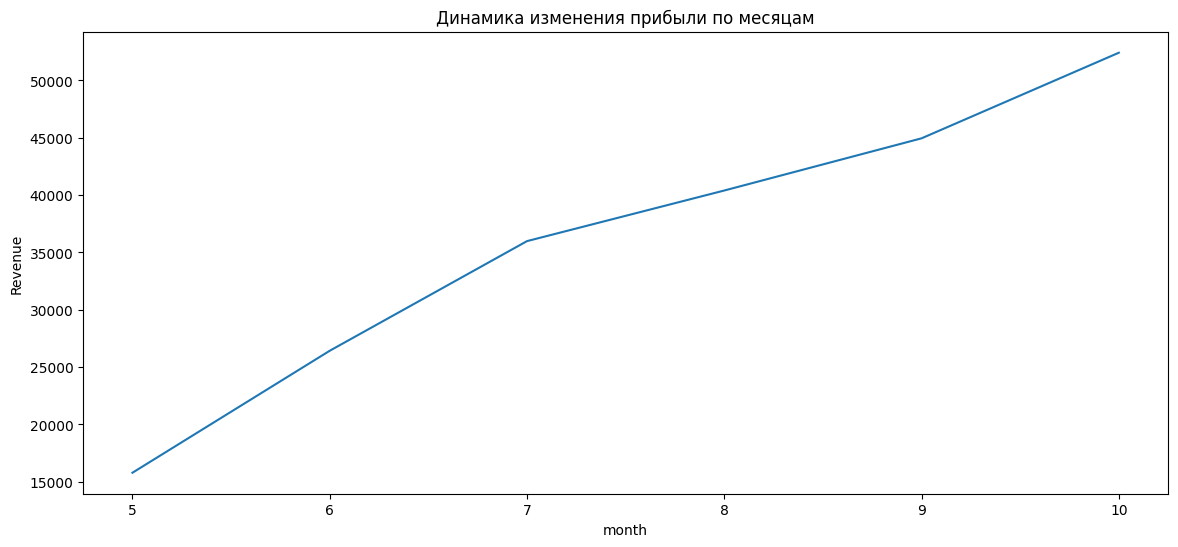

In [44]:
revenue_by_month = visitation.groupby("month")["Revenue"].sum()

plt.figure(figsize=(14, 6))
sns.lineplot(revenue_by_month)
plt.title("Динамика изменения прибыли по месяцам")
plt.show()

### Соотношение кол-ва клиентов, совершивших покупку, к количеству клиентов, посетивших сайт по месяцам

In [45]:
orders["month"] = orders["Event Dt"].dt.month

In [46]:
conversion = orders.groupby("month")["User Id"].nunique()

conversion = pd.concat([conversion, visitation.groupby("month")["User Id"].nunique()], axis=1)

In [47]:
conversion["Conversion"] = conversion.iloc[:, 0] / conversion.iloc[:, 1]

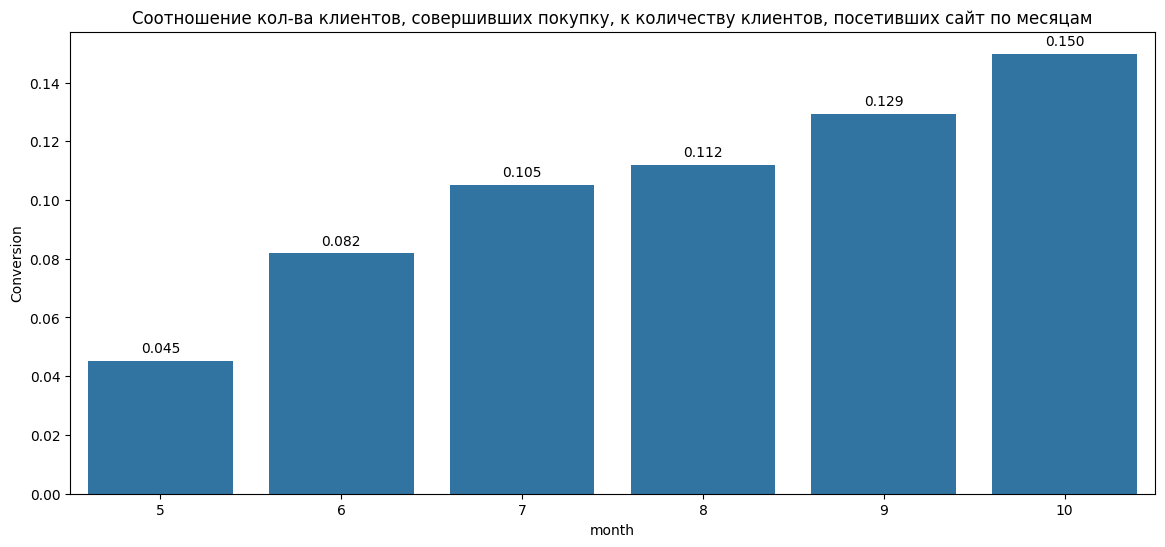

In [48]:
plt.figure(figsize=(14, 6))
splot = sns.barplot(x=conversion.index, y=conversion["Conversion"])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center', va = 'center', 
        xytext = (0, 9), 
        textcoords = 'offset points')
plt.title("Соотношение кол-ва клиентов, совершивших покупку, к количеству клиентов, посетивших сайт по месяцам")
plt.show()

# Модуль Б

## Отбор нужных атрибутов

In [49]:
cluster_data = user_data[["Expenses_sum", "Expenses_mean", "Expenses_max", "Expenses_min", 
"Expenses_std", "Region_Turkey", "Channel_AdNonSense", "Device_iPhone", 
"Region_Thailand", "Channel_LeapBob"]]

In [55]:
cluster_data.head()

Expenses_sum  Expenses_mean  Expenses_max  Expenses_min  \
User Id                                                             
599326           294.8      98.266667         101.2          93.5   
4919697          324.5     162.250000         168.3         156.2   
6085896            0.0       0.000000           0.0           0.0   
22593348          16.8      16.800000          16.8          16.8   
31989216           6.0       6.000000           6.0           6.0   

          Expenses_std  Region_Turkey  Channel_AdNonSense  Device_iPhone  \
User Id                                                                    
599326        4.164533              3                   3              3   
4919697       8.555992              2                   2              2   
6085896       0.000000              2                   2              2   
22593348      0.000000              1                   1              1   
31989216      0.000000              1                   1              1   

          Region_Thailand  Channel_LeapBob  
User Id                                     
599326                  3                3  
4919697                 2                2  
6085896                 2                2  
22593348                1                1  
31989216                1                1

## Выбор модели

In [73]:
for column in cluster_data.columns:
    cluster_data[column] = cluster_data[column].astype(np.float32)

In [65]:
def get_clustering_metrics(clusters):
    print("Коэффициент силуета:", silhouette_score(cluster_data, clusters))
    print("Индекс Дэвиса-Боулдина:", davies_bouldin_score(cluster_data, clusters))

In [66]:
kmeans = cluster.KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(cluster_data)

In [67]:
get_clustering_metrics(clusters)

Коэффициент силуета: 0.7424164674041702
Индекс Дэвиса-Боулдина: 0.4555242595120694


In [68]:
kmeans = cluster.KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(cluster_data)
get_clustering_metrics(clusters)

Коэффициент силуета: 0.7604627269940748
Индекс Дэвиса-Боулдина: 0.5936845803157175


In [77]:
dbscan = cluster.DBSCAN(n_jobs=-1)
clusters = dbscan.fit_predict(cluster_data)
get_clustering_metrics(clusters)

Коэффициент силуета: 0.50562745
Индекс Дэвиса-Боулдина: 1.6866924384033166


In [80]:
mb_kmeans = cluster.MiniBatchKMeans(n_clusters=3, random_state=42)
clusters = mb_kmeans.fit_predict(cluster_data)
get_clustering_metrics(clusters)

Коэффициент силуета: 0.74245435
Индекс Дэвиса-Боулдина: 0.45523251877875115


<b>Вывод</b>

Мы выбираем модель KMeans с 3 кластерами, так как она показала лучшие метрики в silhouette_score (больше других) и davies_bouldin_score (меньше других), а также работает намного быстрее остальных.

* <i>silhouette_score - насколько элементы одного кластера похожи друг на друга и отличаются от других кластеров</i>
* <i>davies_bouldin_score - отношение внутрикластерного расстояния к межкластерному расстоянию</i>

## Получение кластеров и их интерпритация

In [50]:
kmeans = cluster.KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(cluster_data)

In [54]:
filename = "app/clustering_model.sav"

pickle.dump(kmeans, open(filename, "wb"))

In [97]:
scaler = StandardScaler()

standarded_cluster_data = scaler.fit_transform(cluster_data)


pca = PCA(n_components=3)
 
reduced_X = pd.DataFrame(data=pca.fit_transform(standarded_cluster_data),columns=['PCA1','PCA2', 'PCA3'])

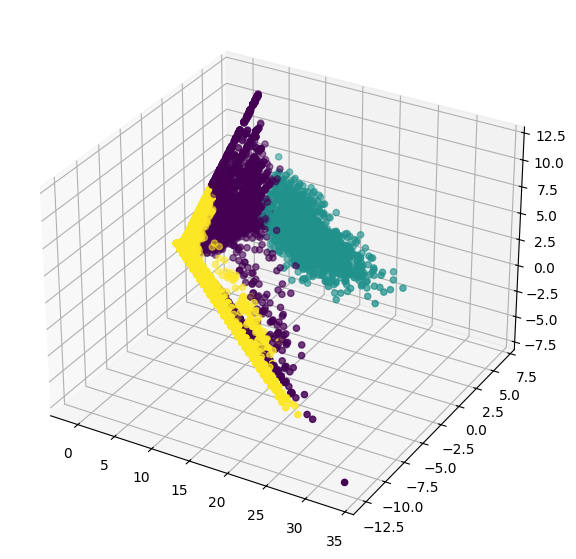

In [98]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(reduced_X["PCA1"], reduced_X["PCA2"], reduced_X["PCA3"], c=kmeans.labels_)

plt.show()

In [132]:
user_data["cluster"] = clusters

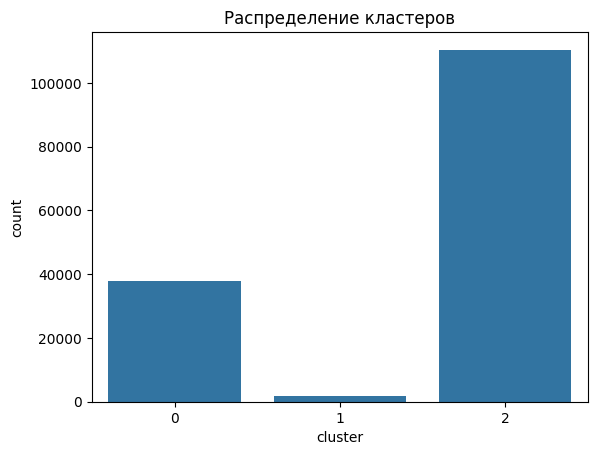

In [136]:
sns.countplot(data=user_data, x="cluster")
plt.title("Распределение кластеров")
plt.show()

In [134]:
def get_plots(col):
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    sns.barplot(data=user_data, x="cluster", y=col, estimator=np.mean, ax=axes[0])
    sns.boxplot(data=user_data, x="cluster", y=col, ax=axes[1])
    fig.suptitle(f"Распределение кластеров для признака: {col}")
    plt.show()

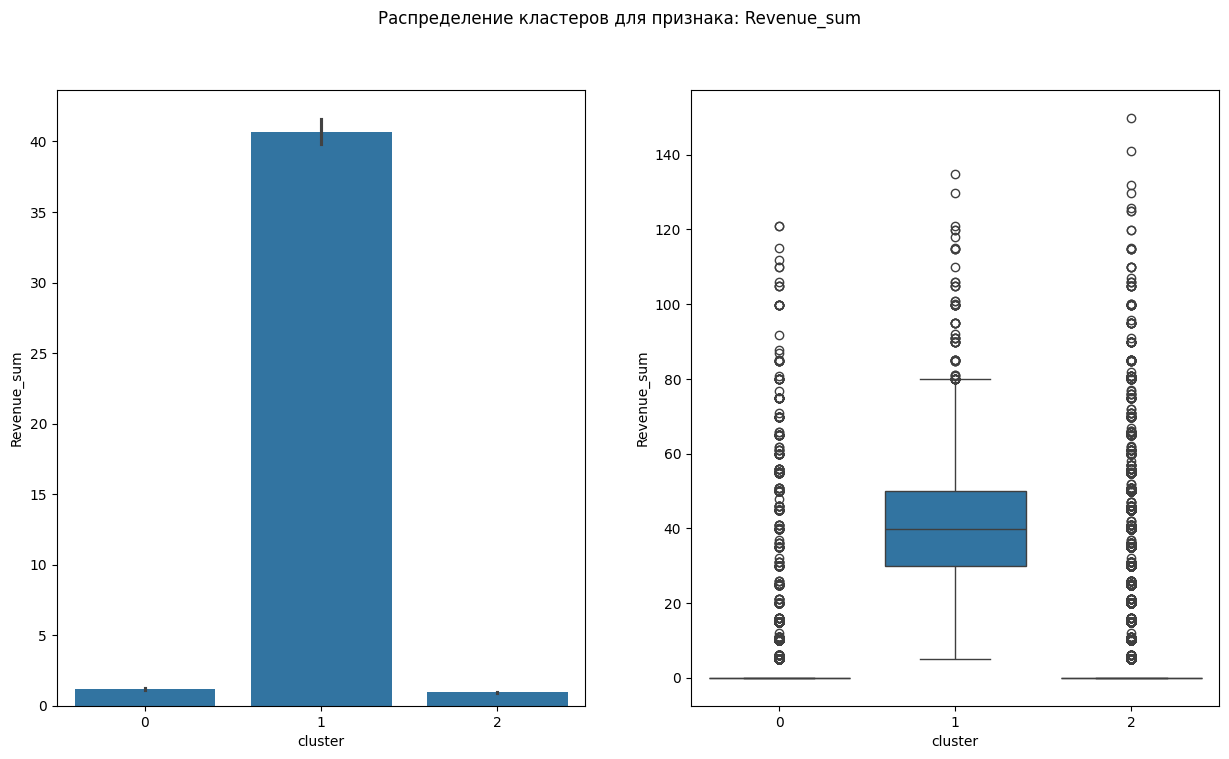

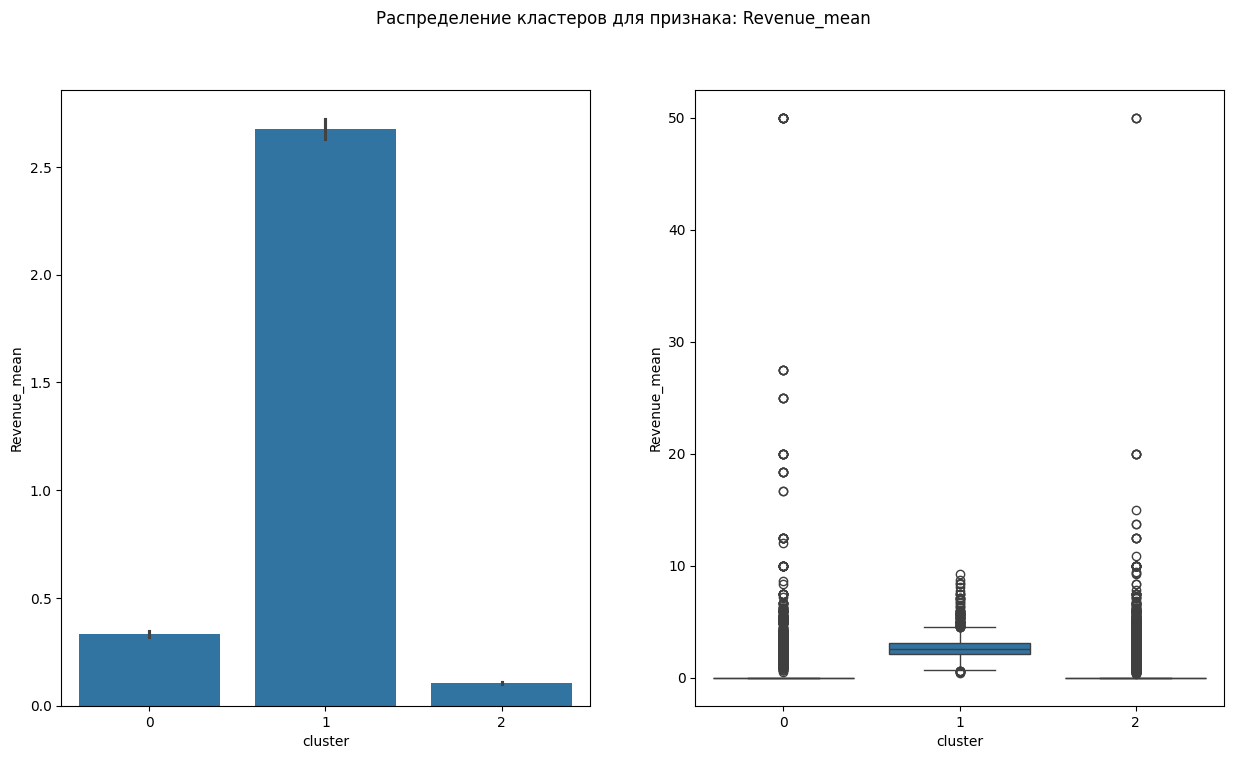

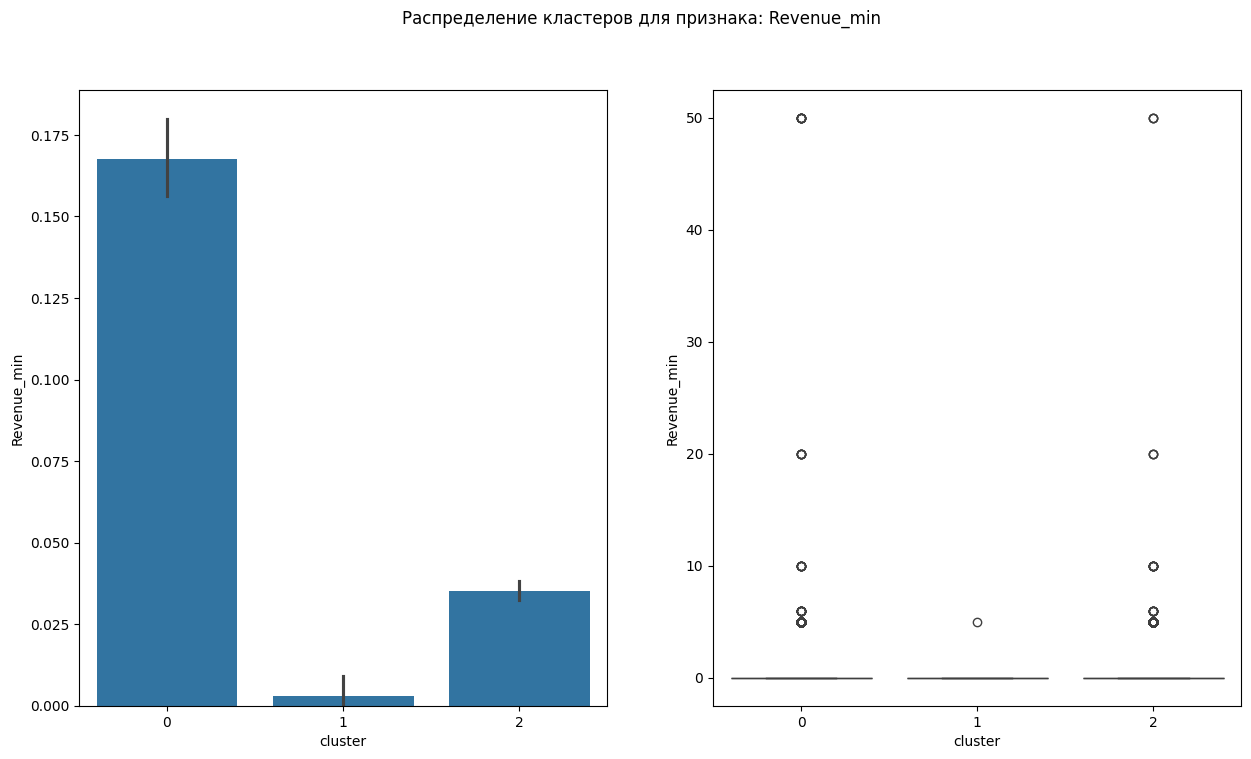

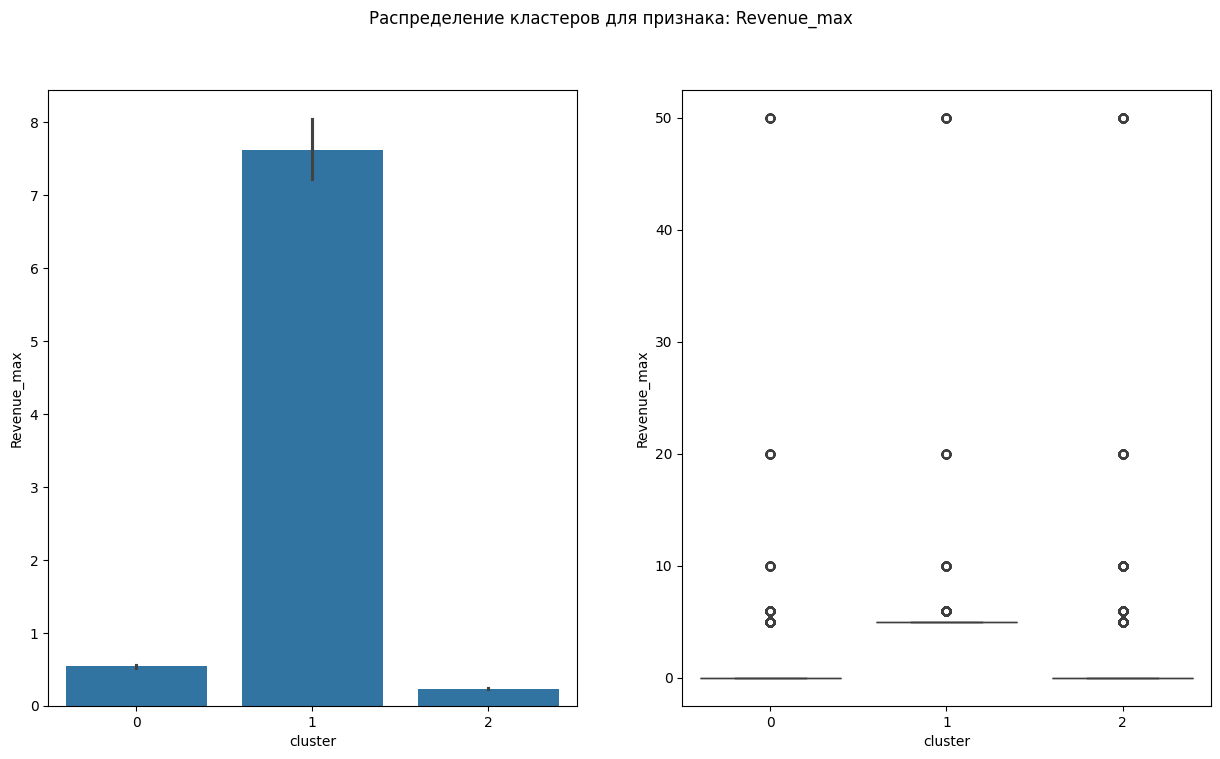

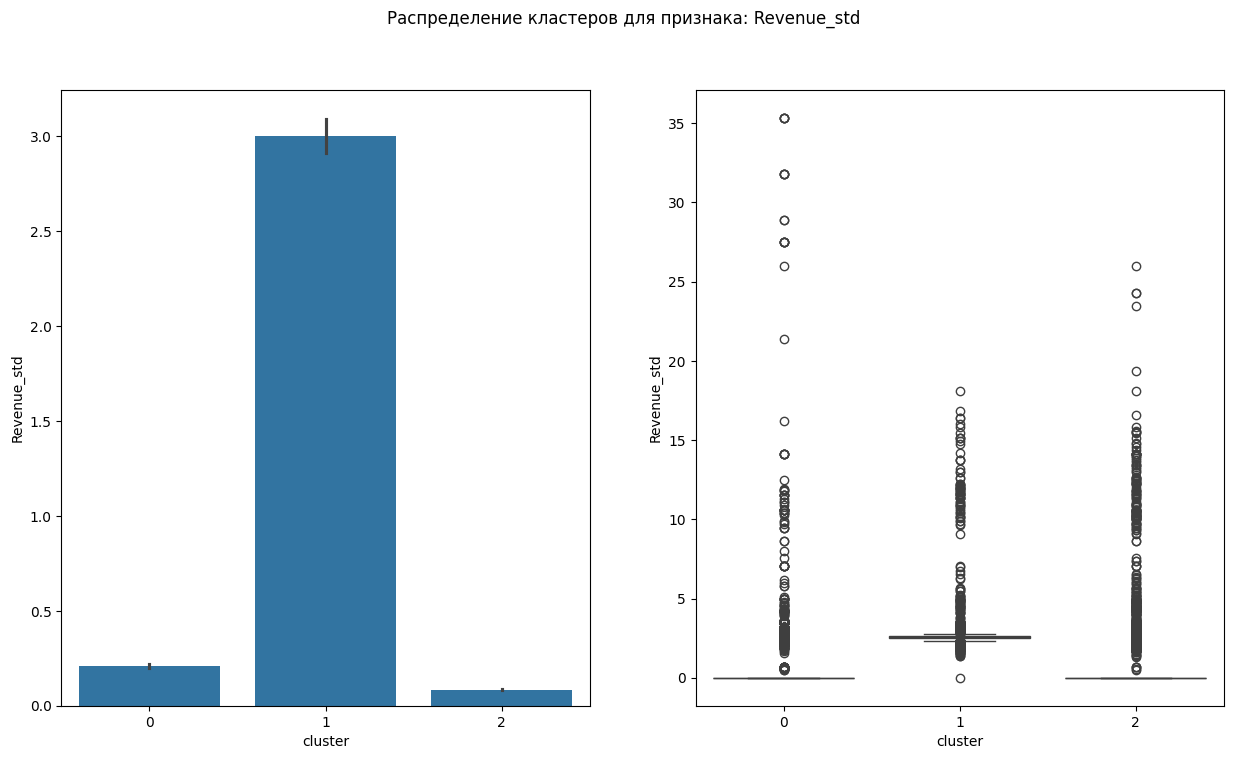

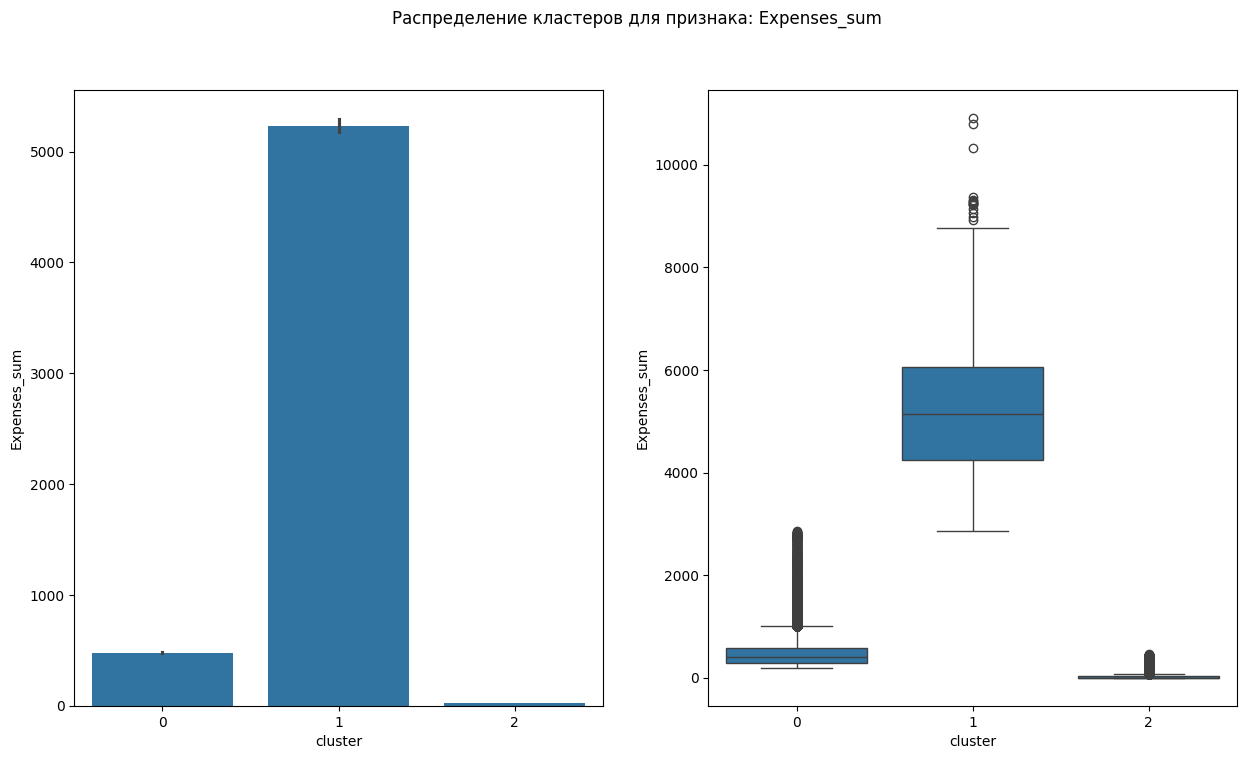

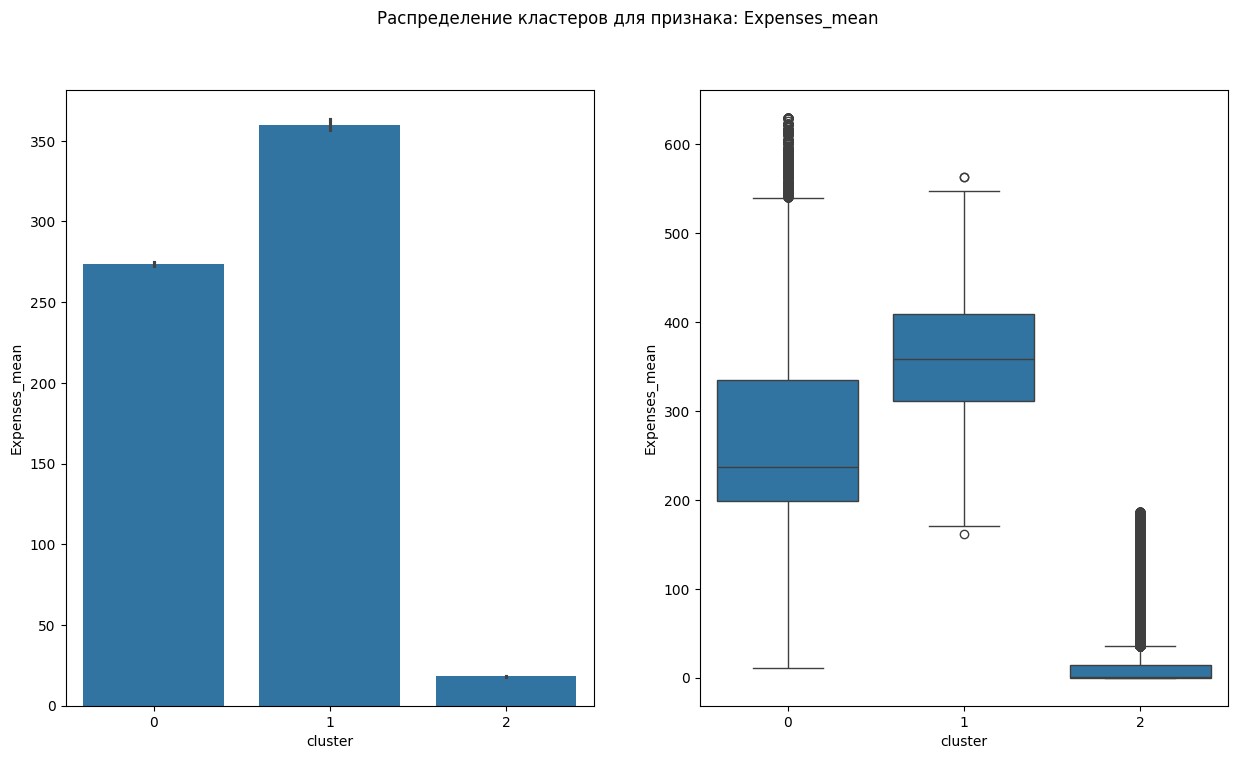

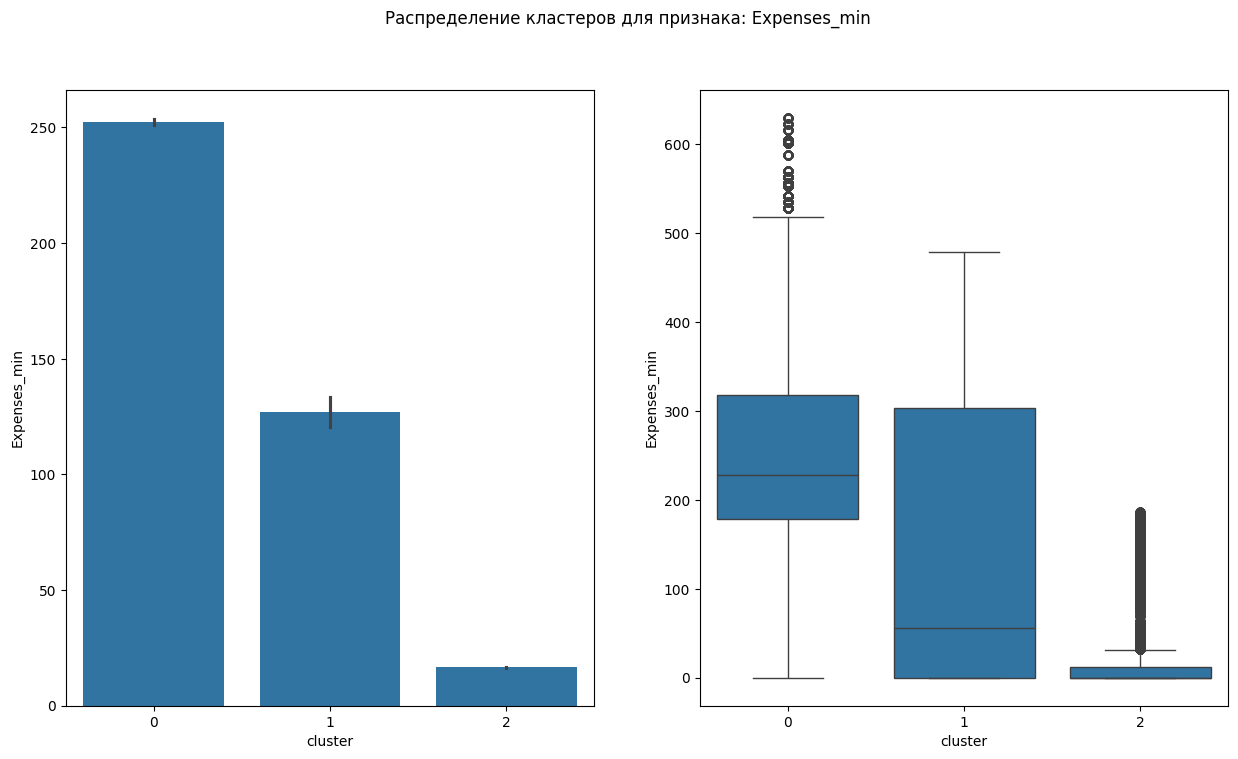

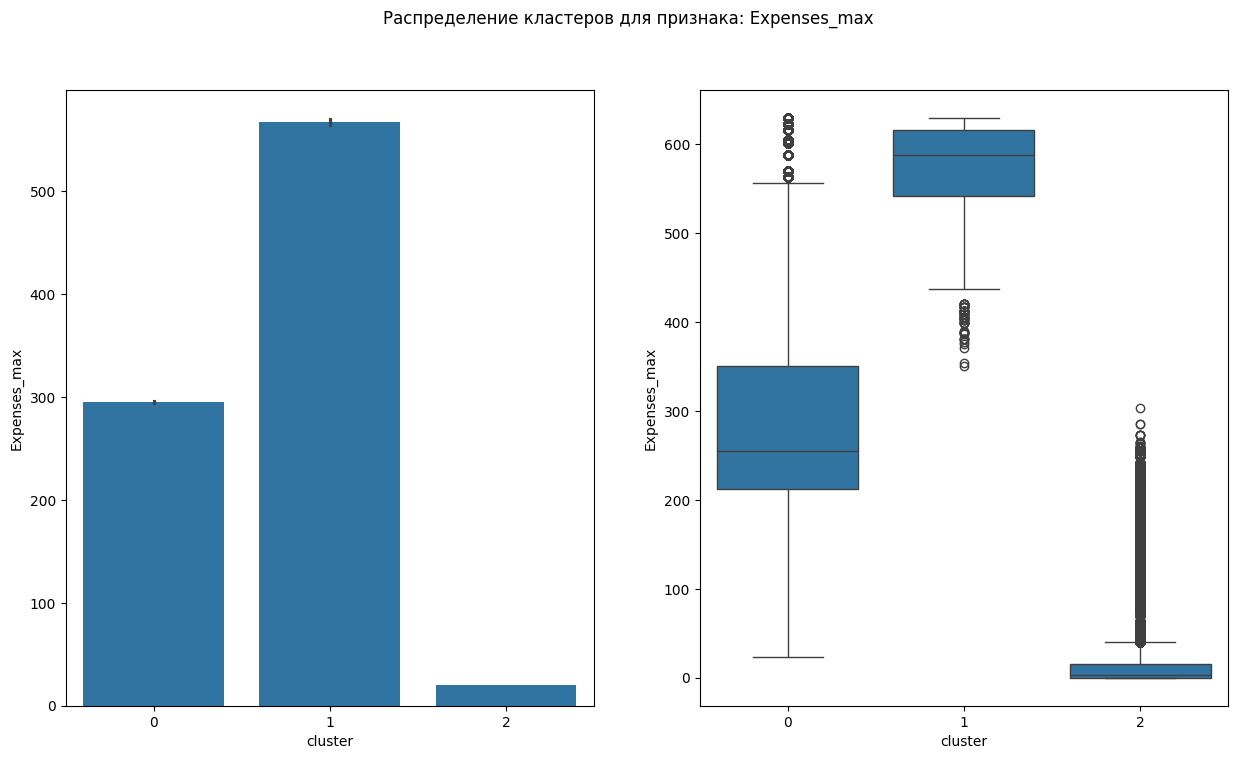

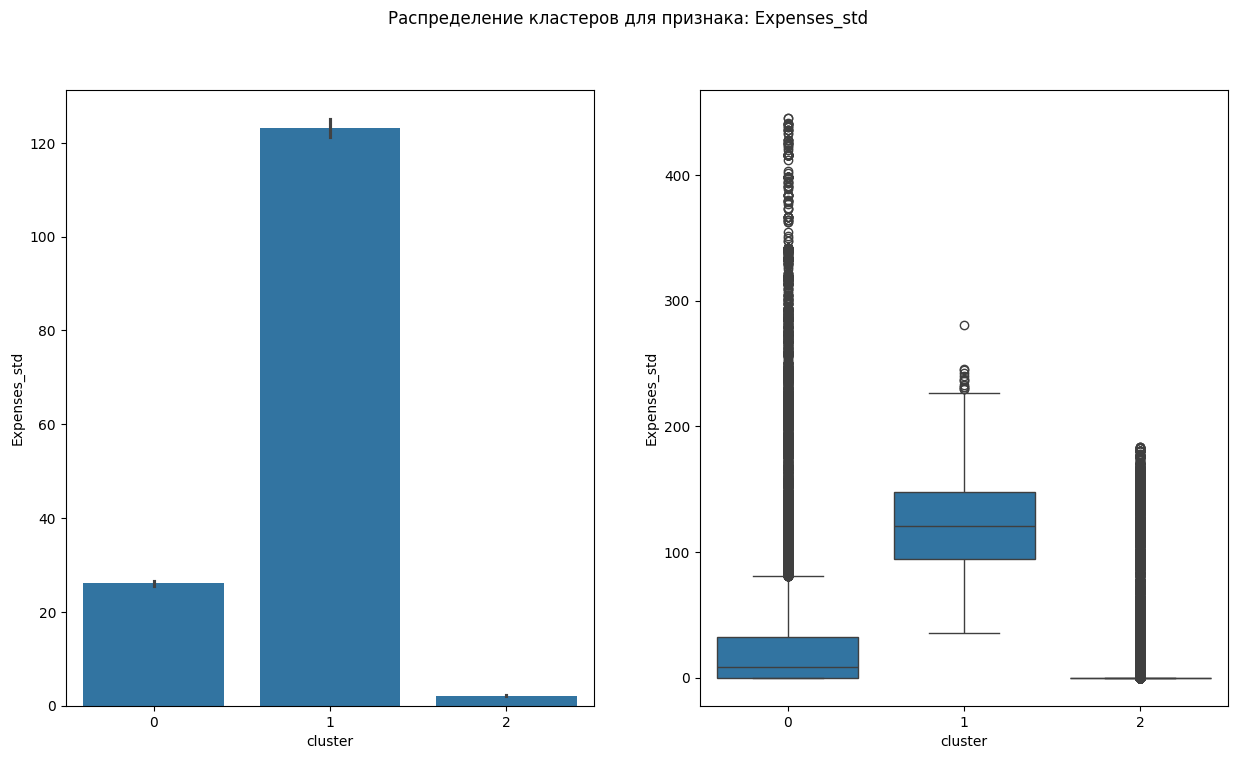

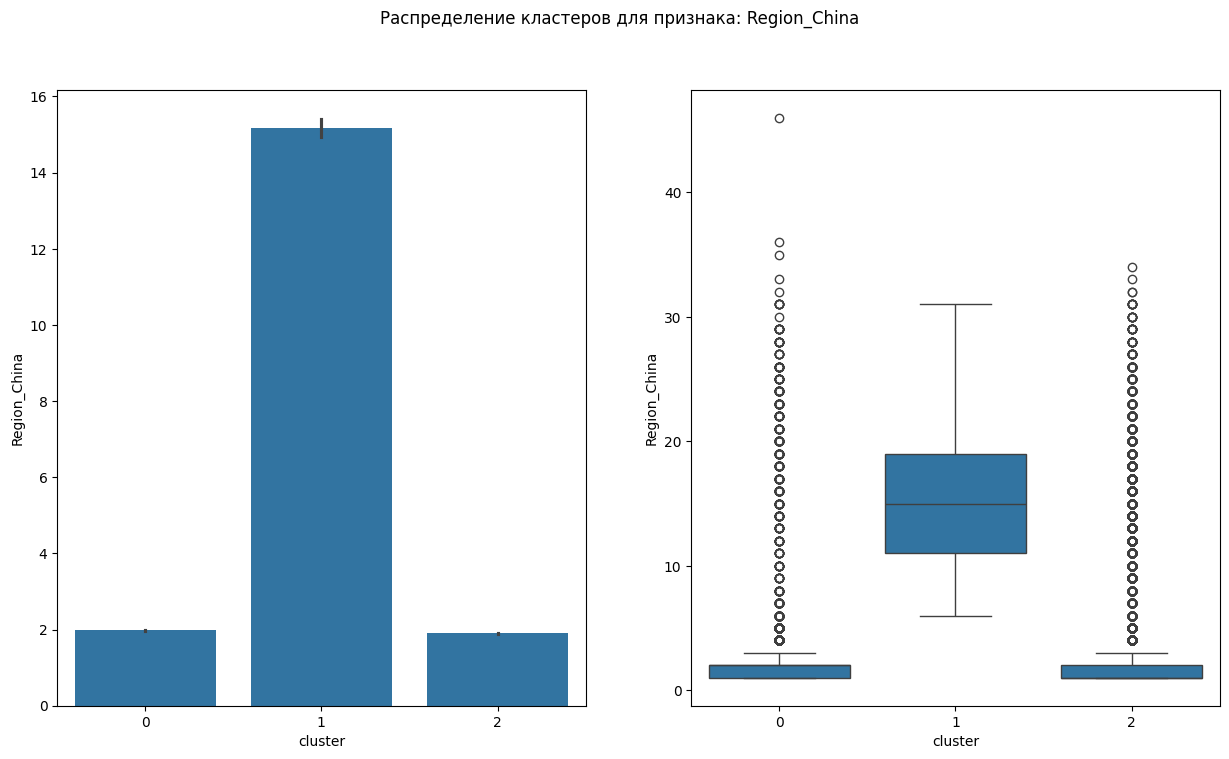

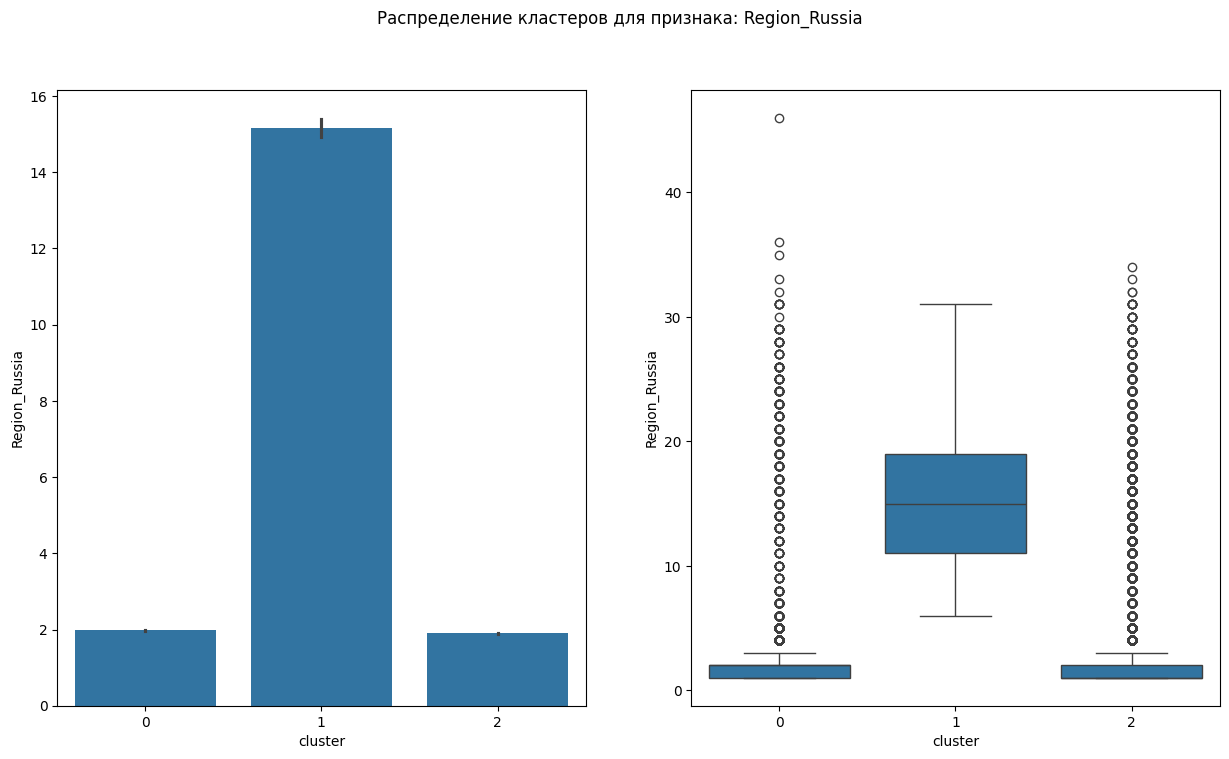

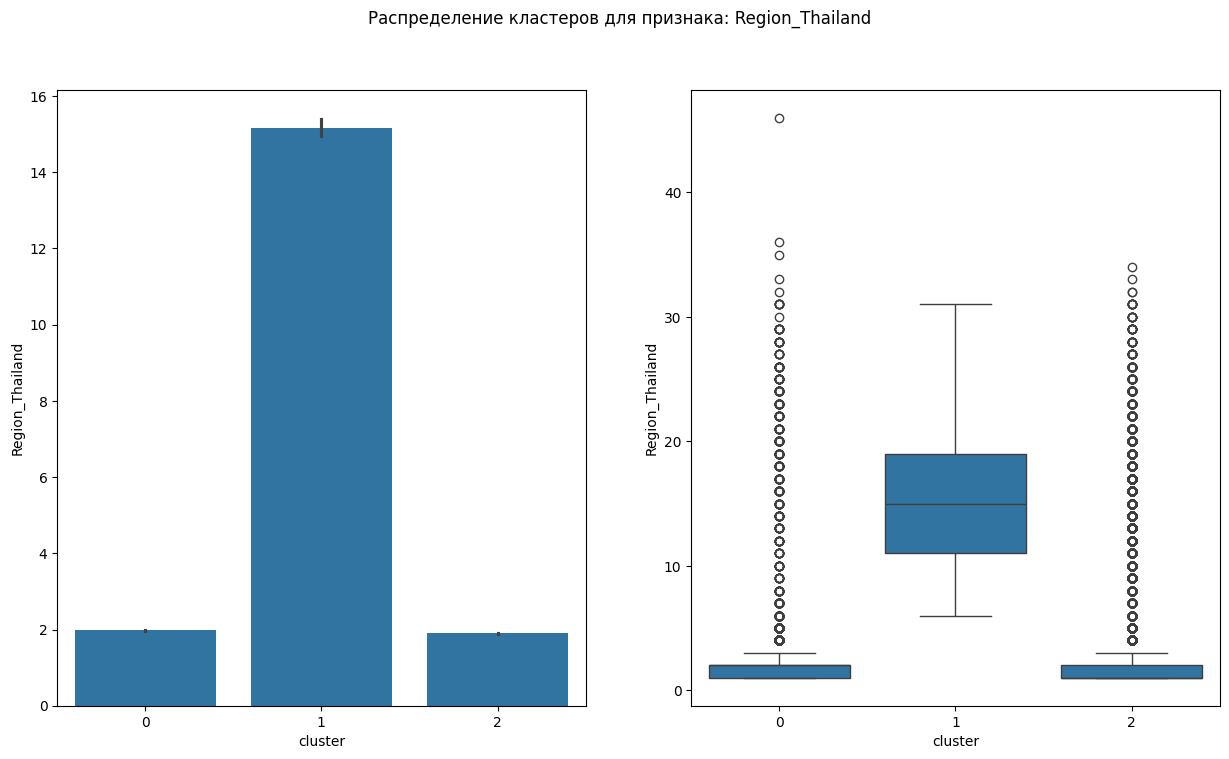

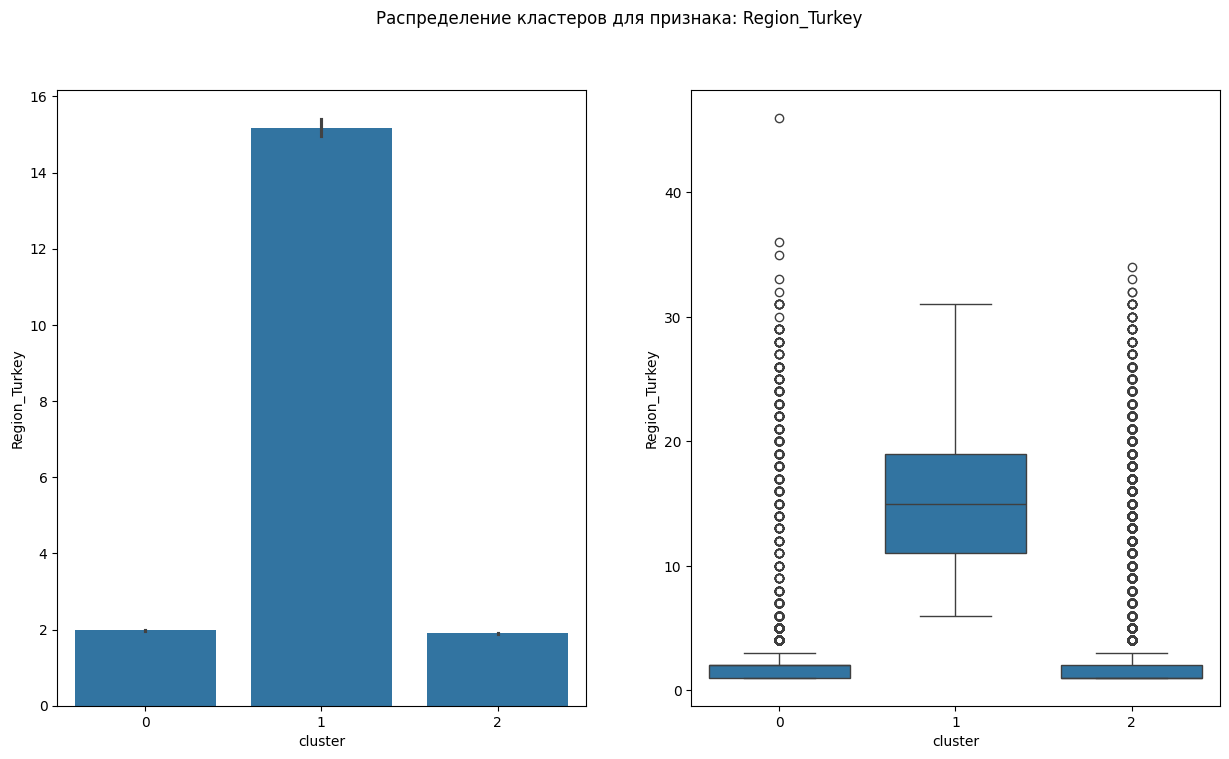

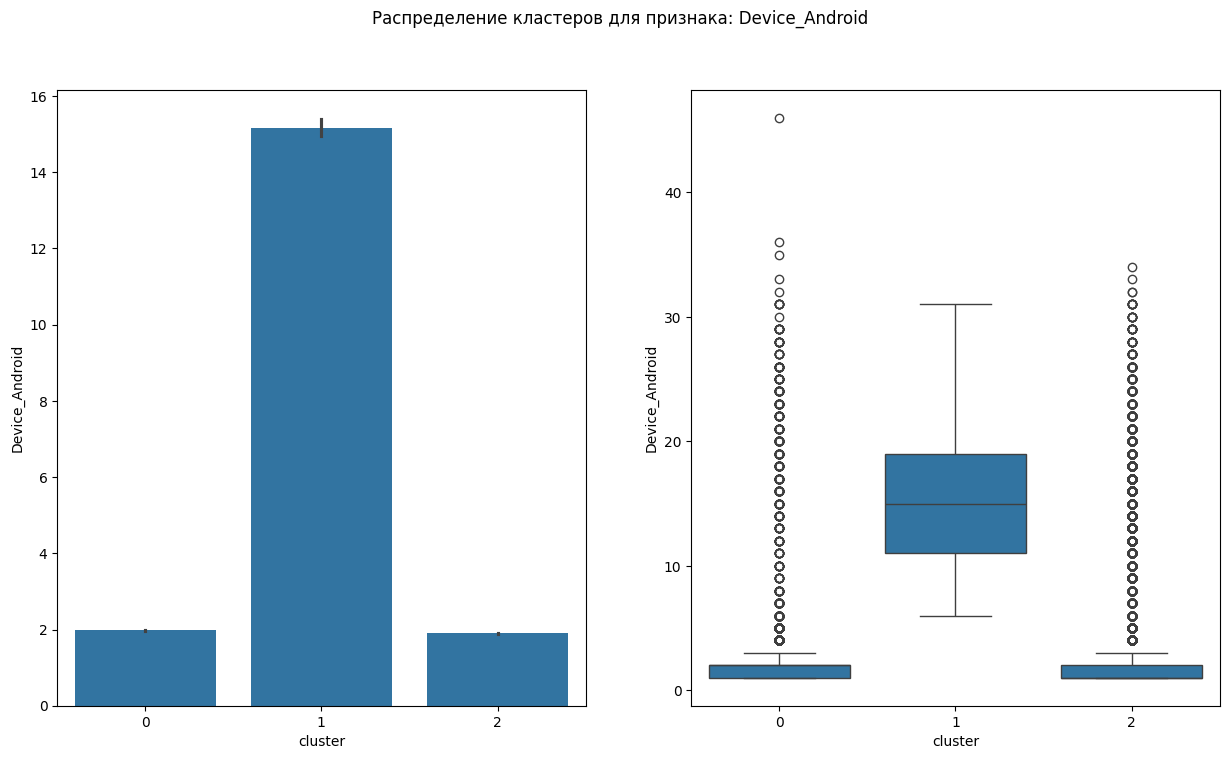

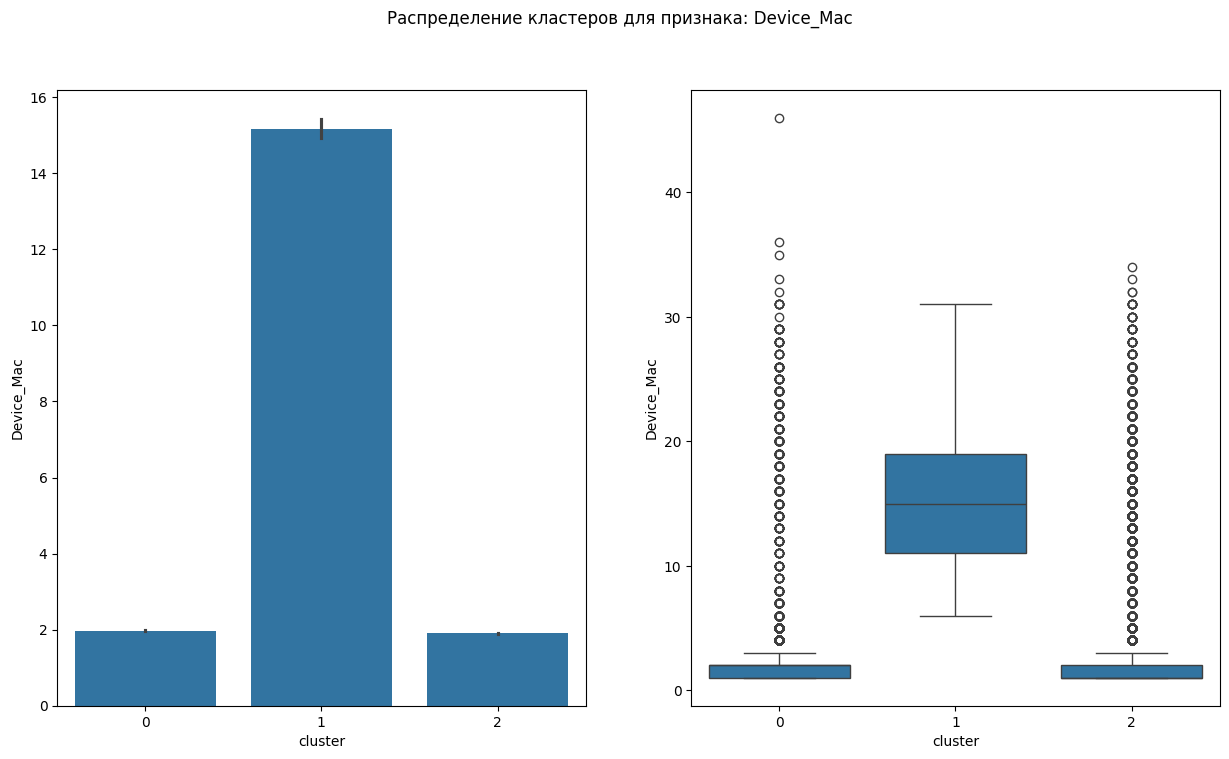

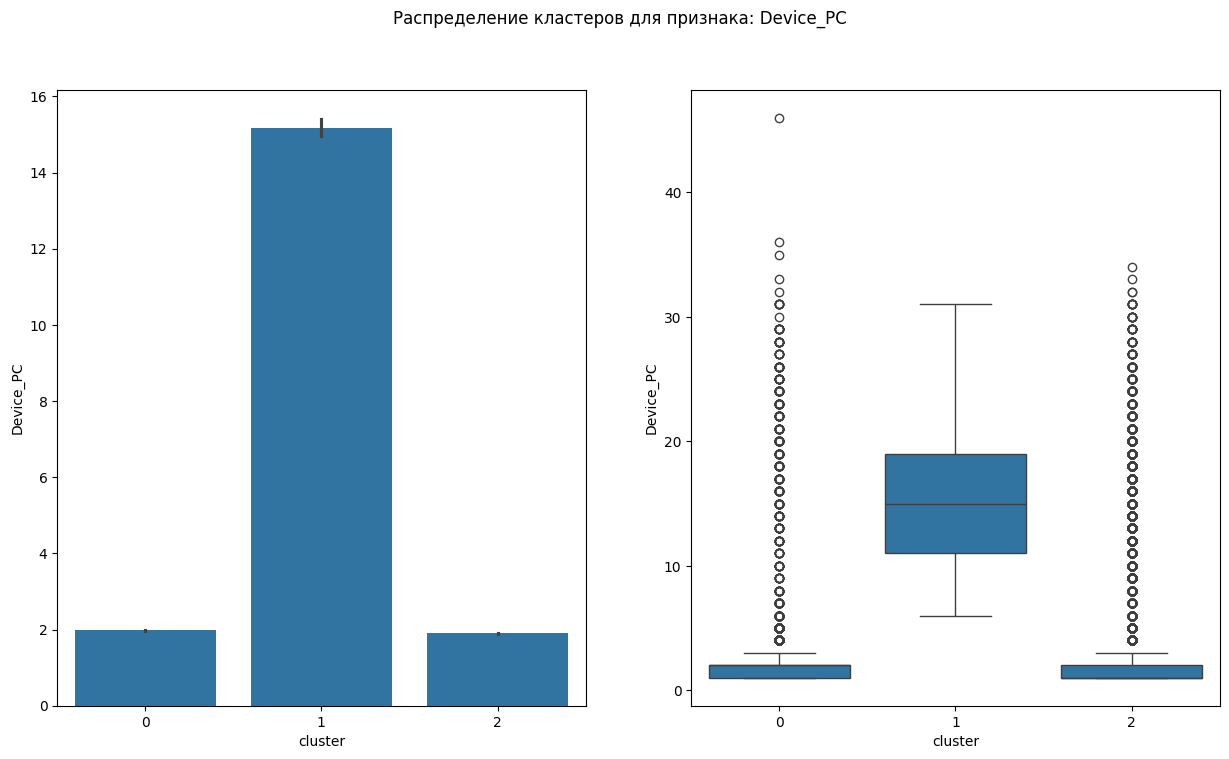

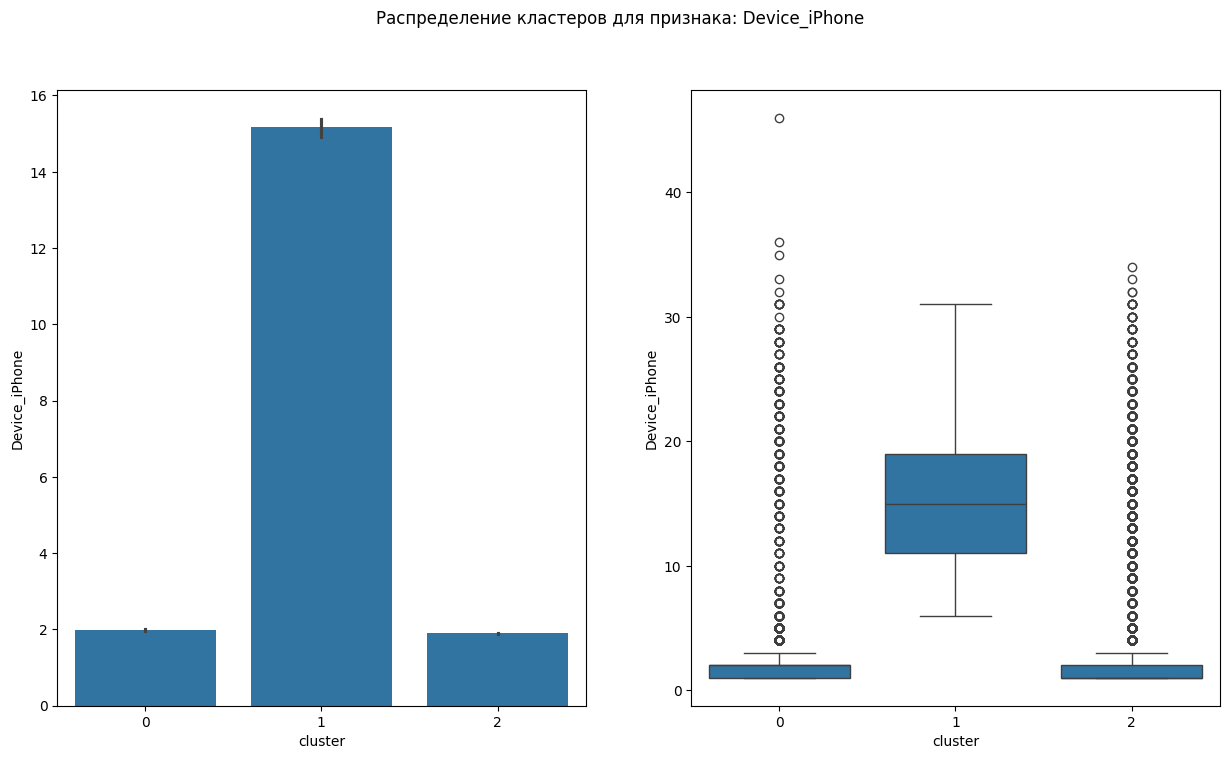

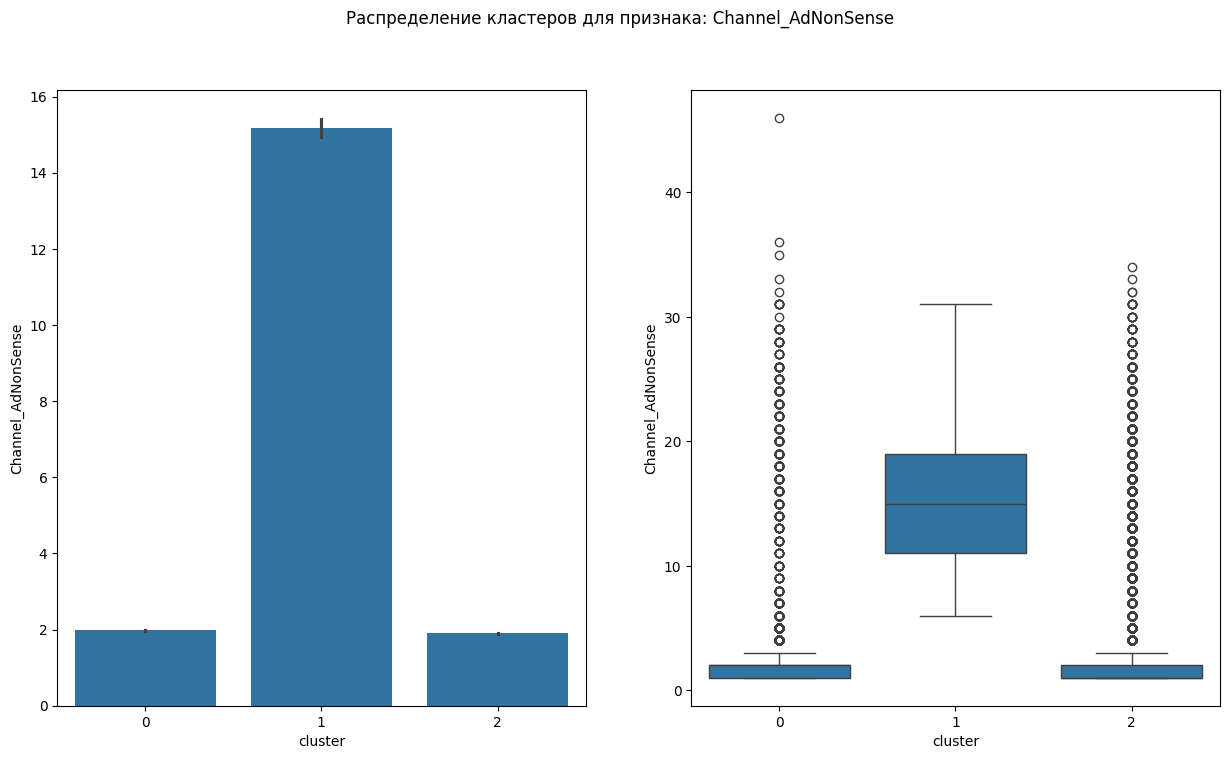

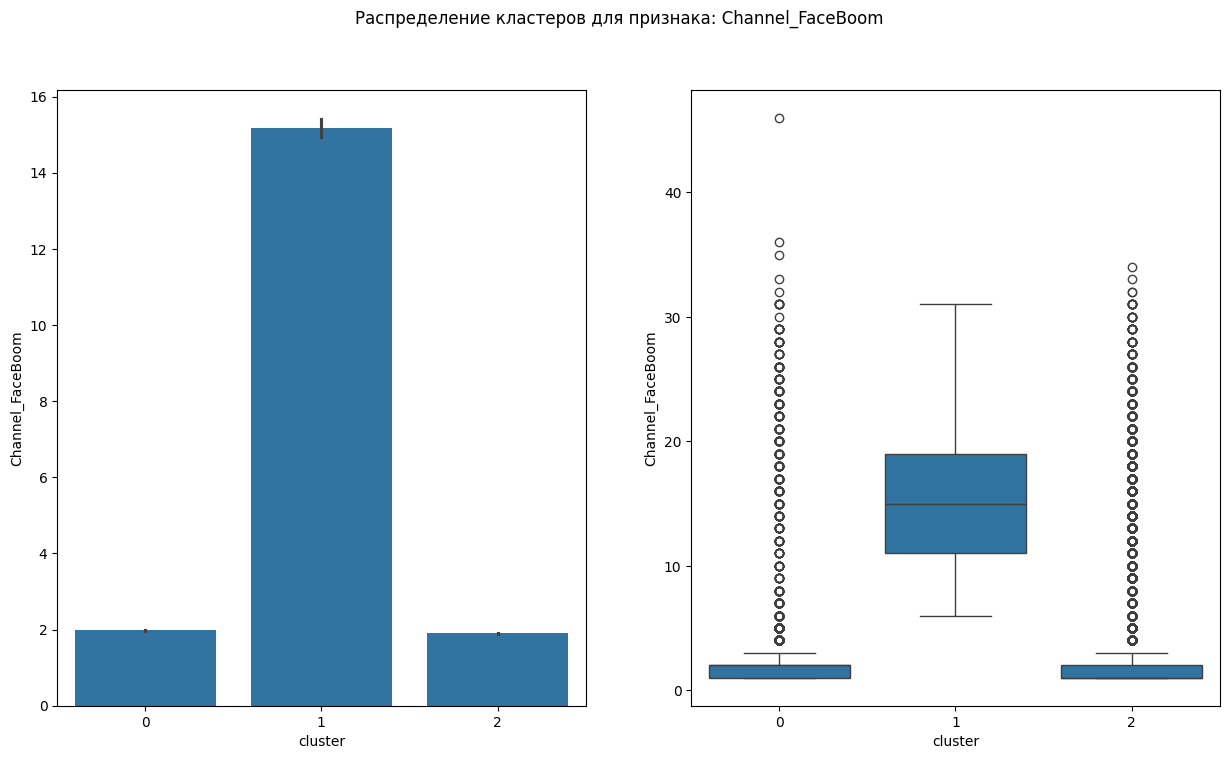

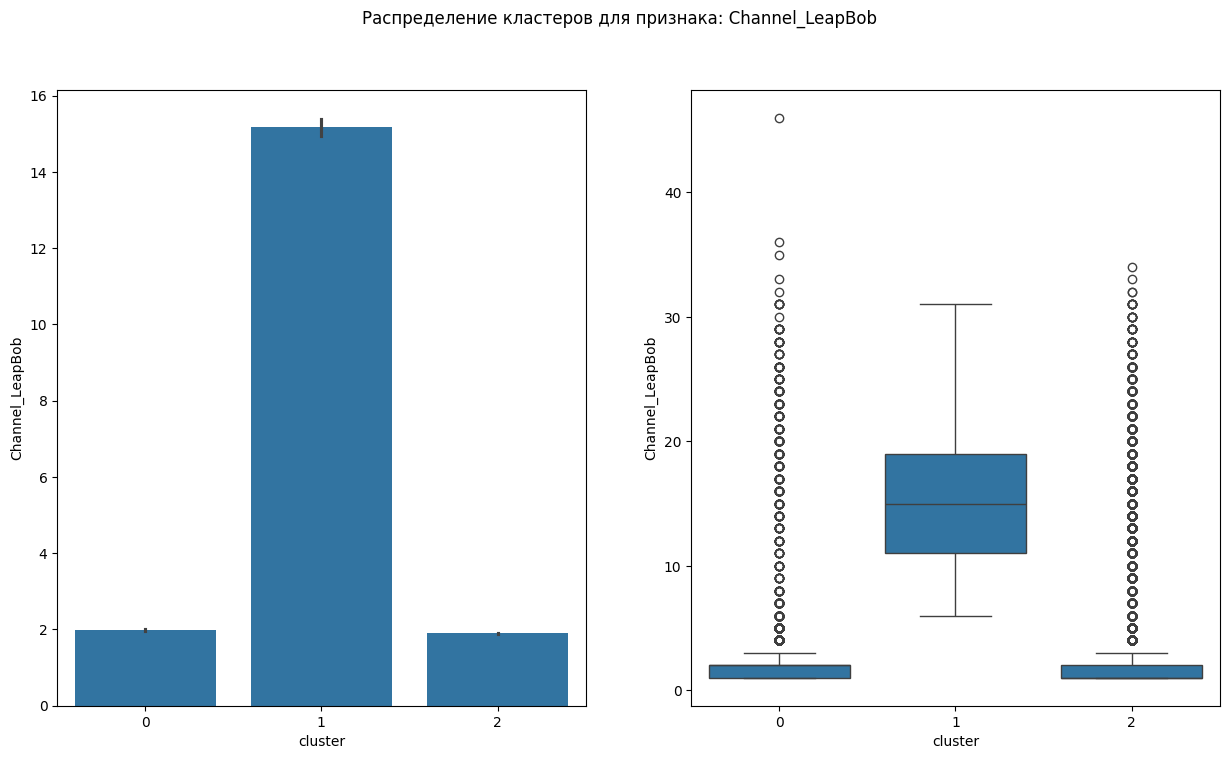

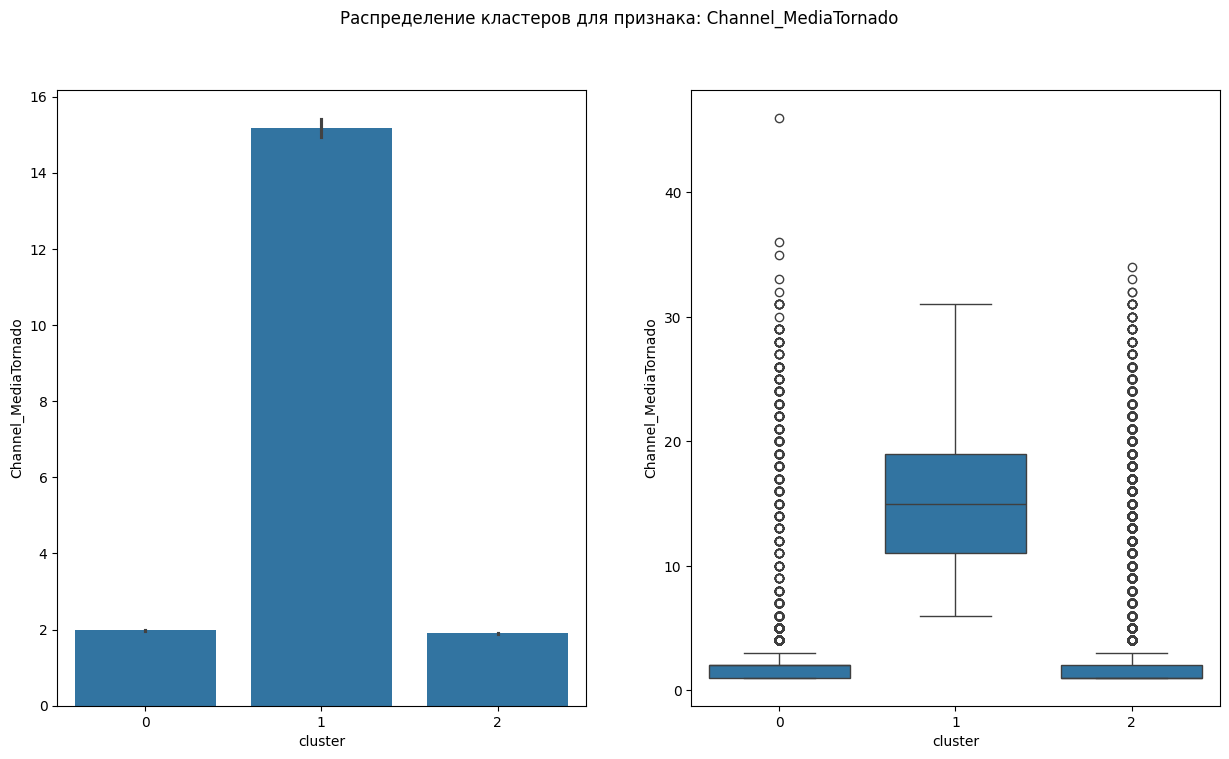

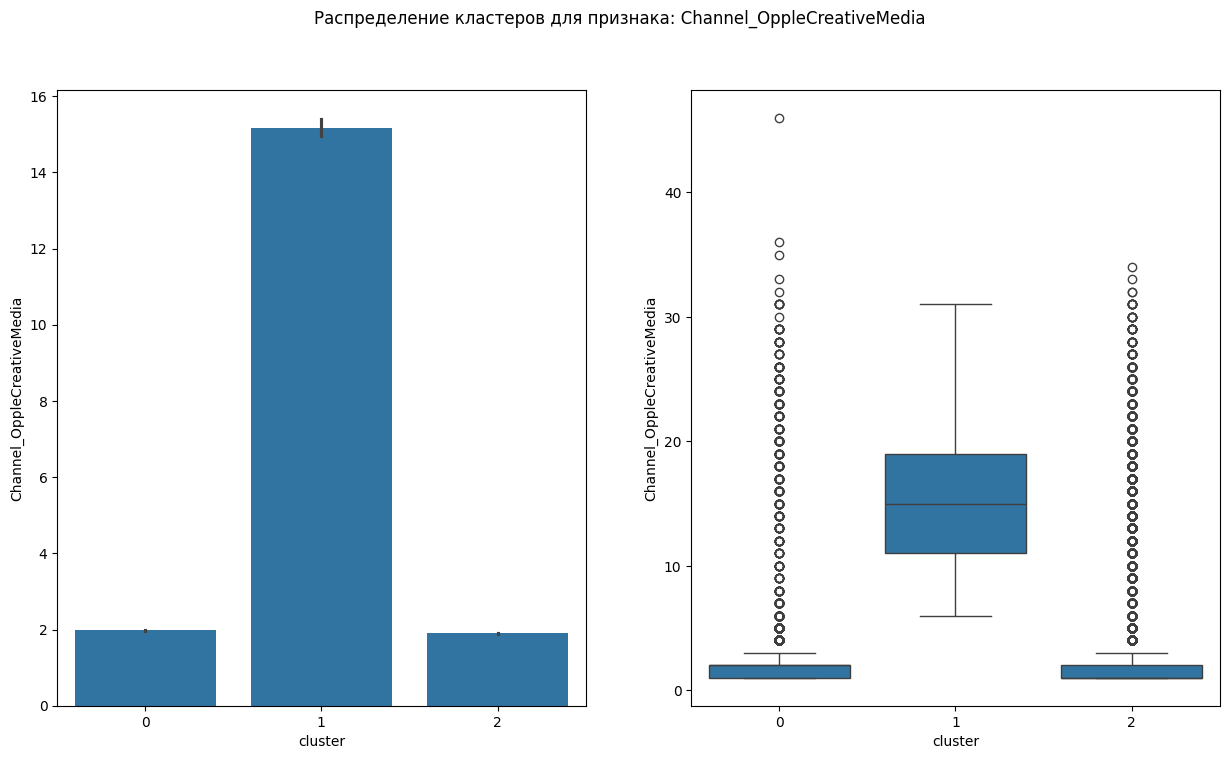

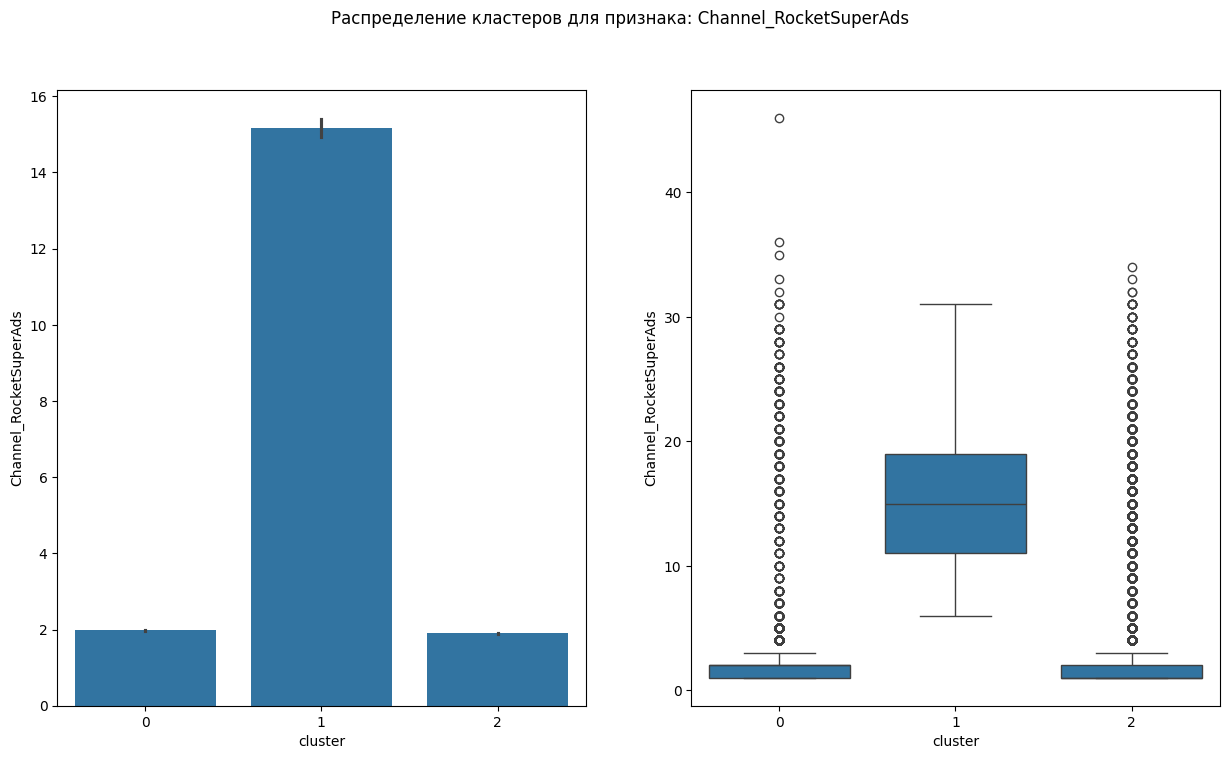

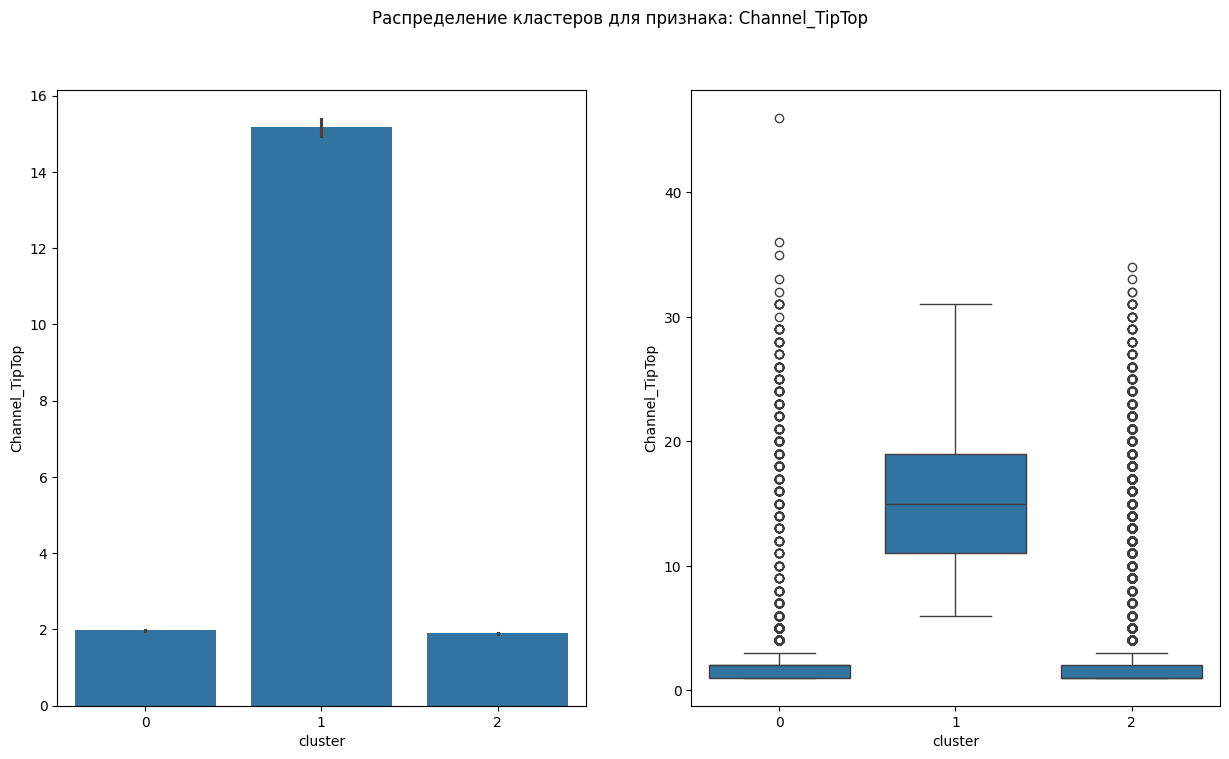

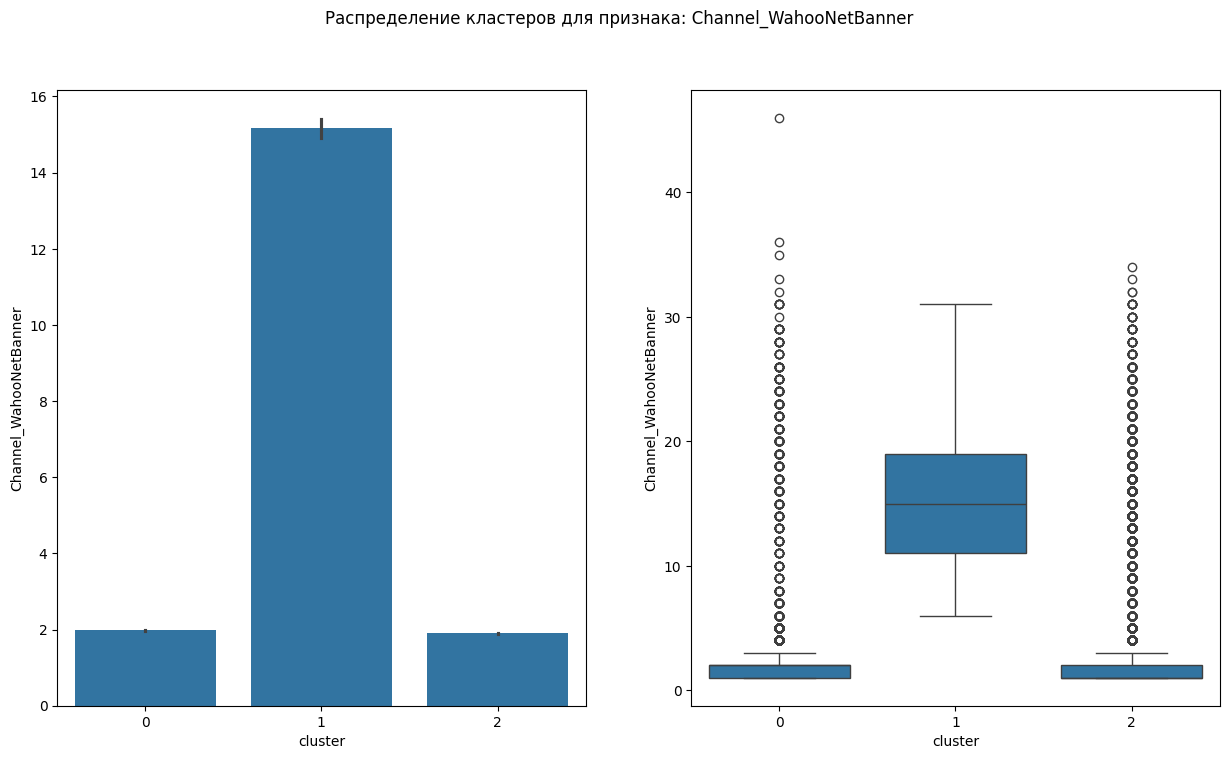

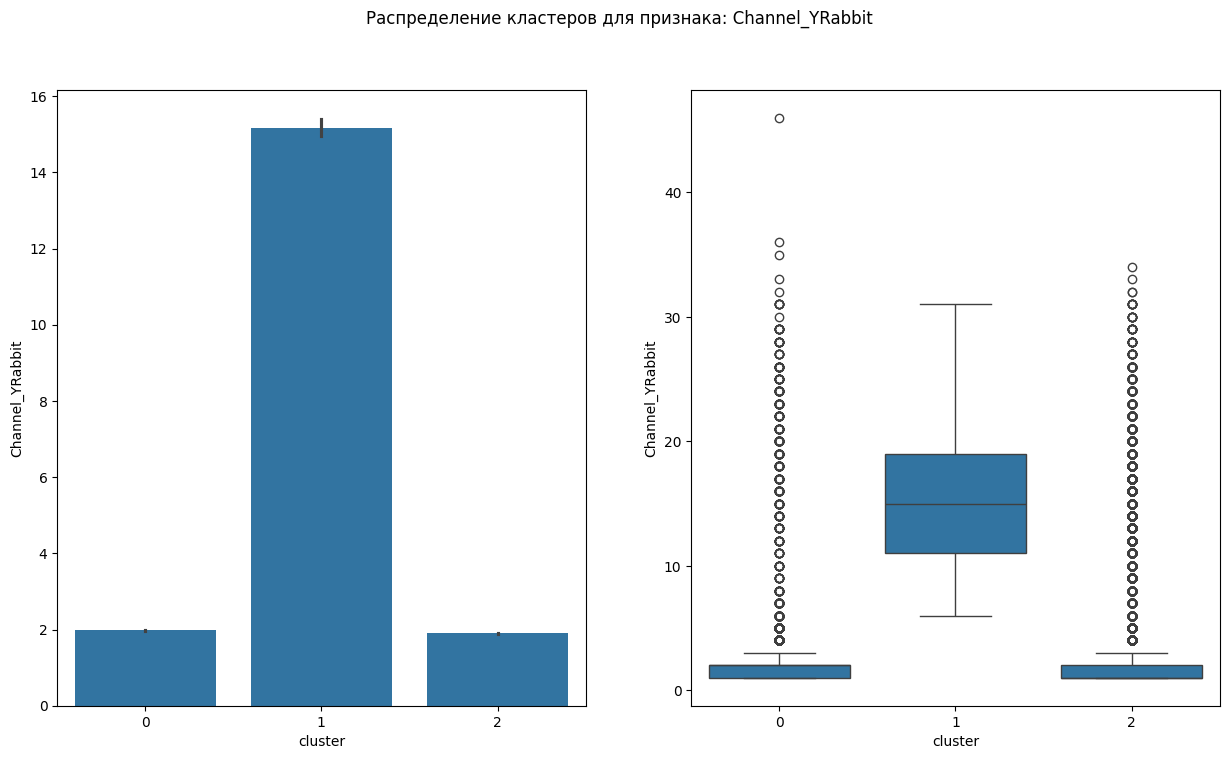

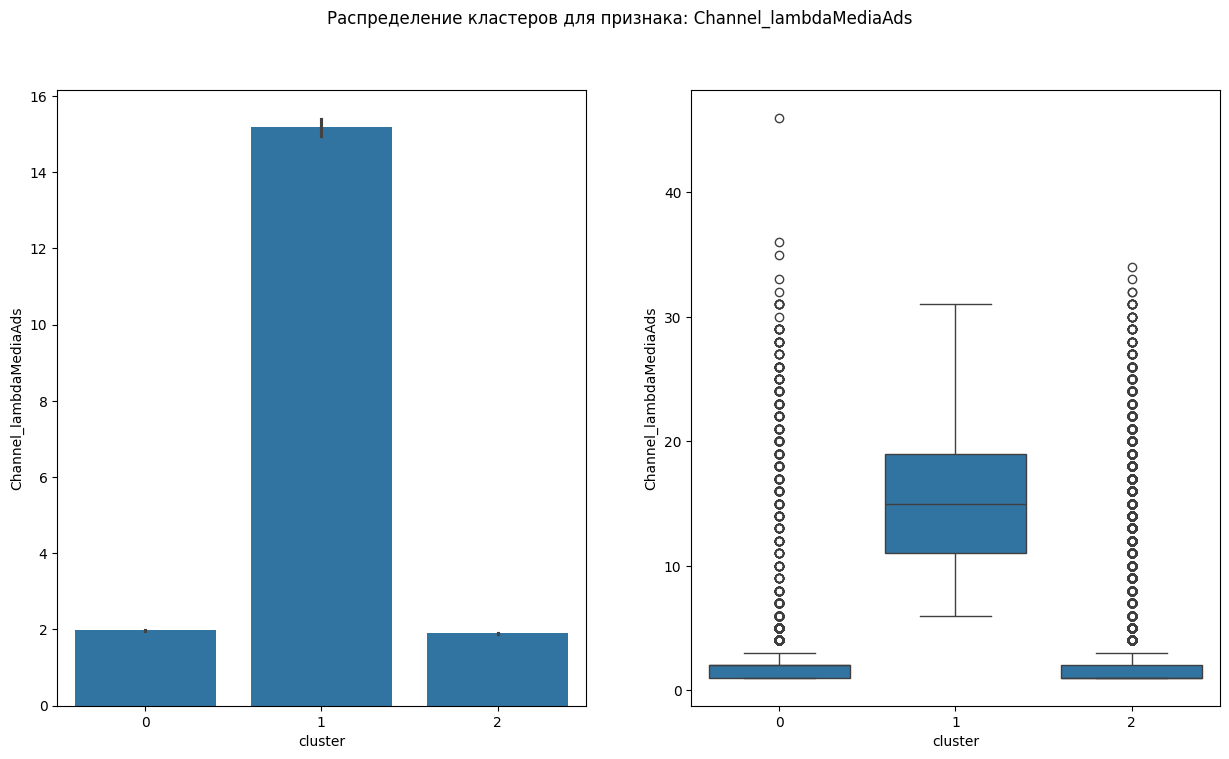

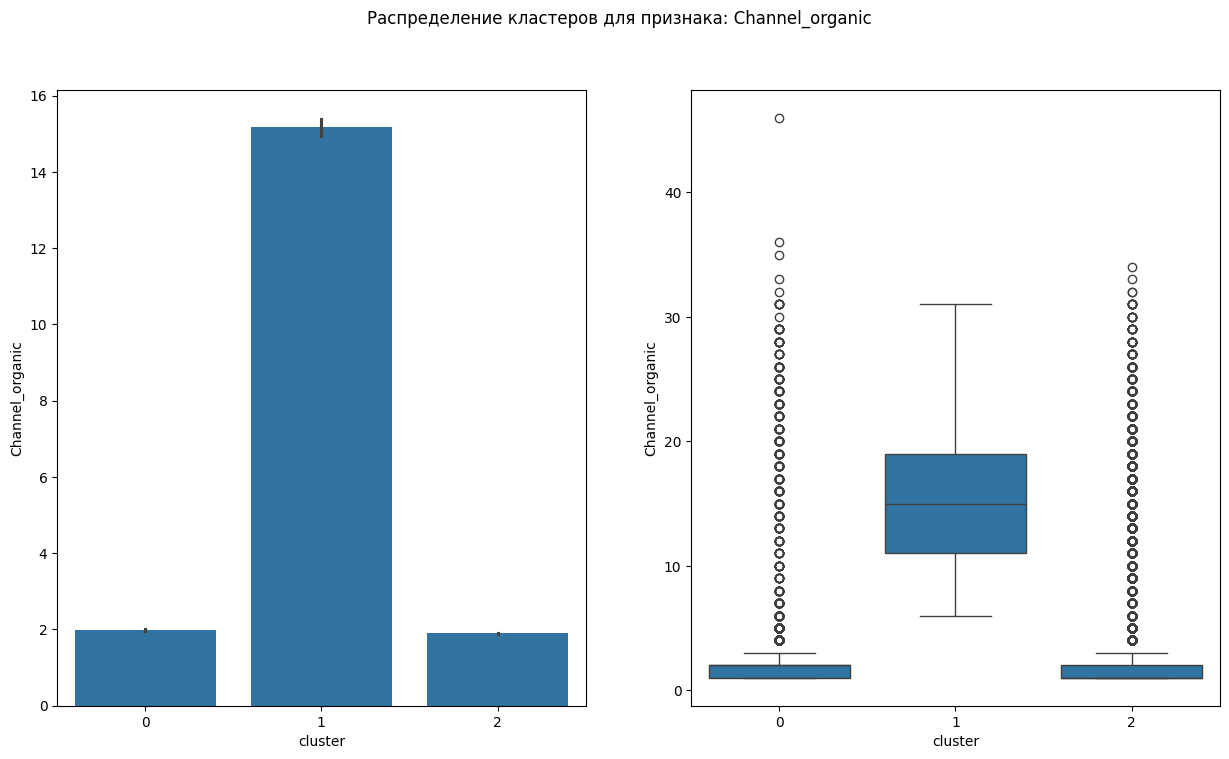

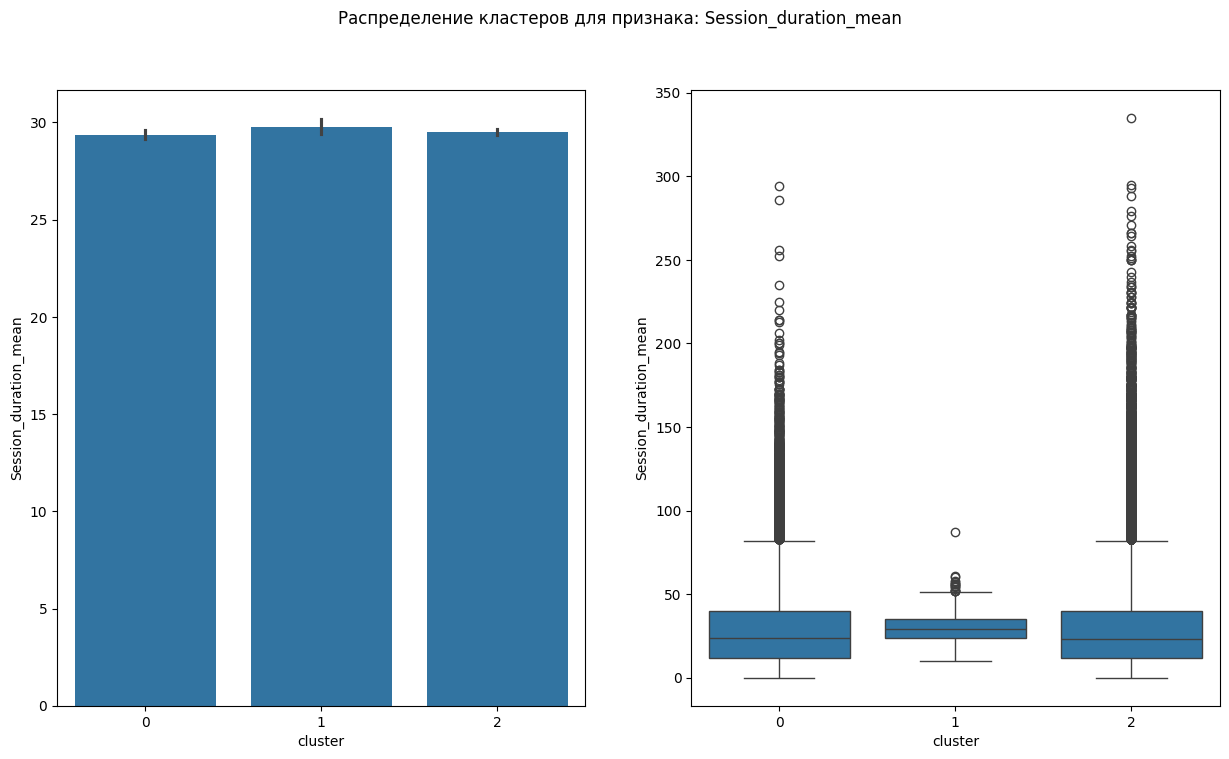

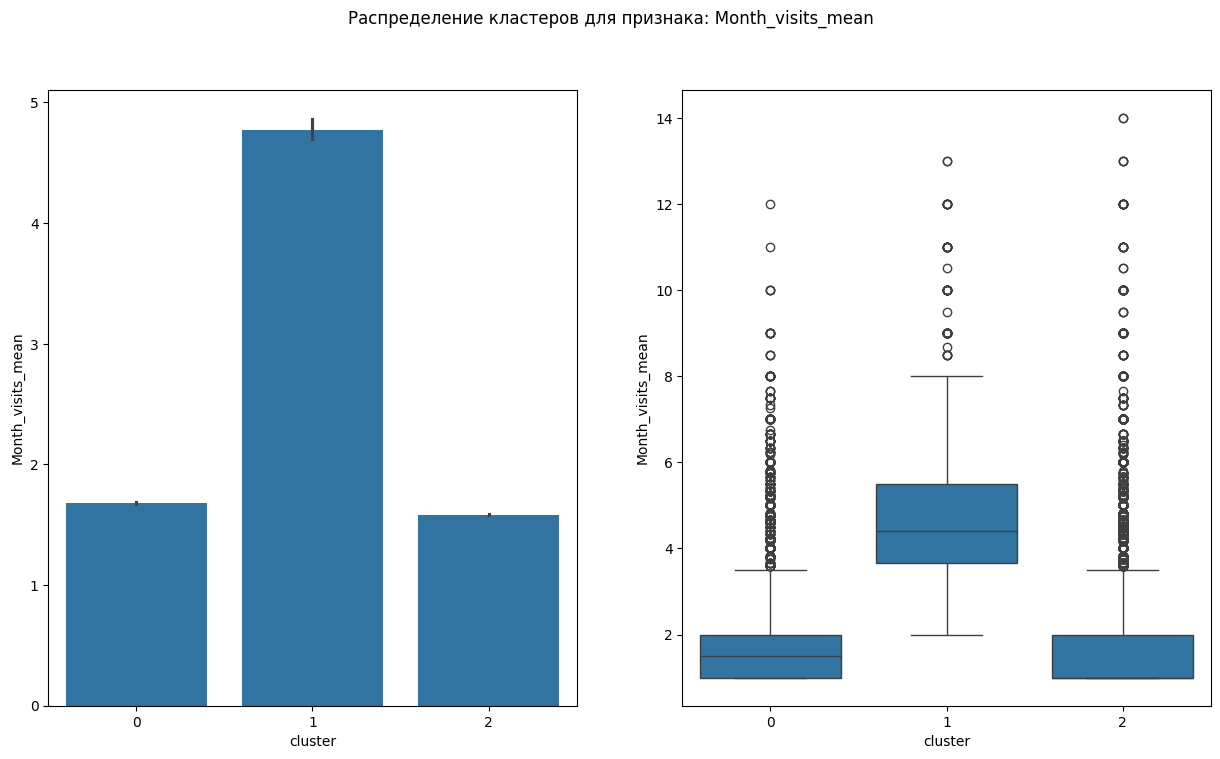

In [135]:
for col in user_data.columns[:-1]:
    get_plots(col)

<b>Описание кластеров</b>

* Кластер 0 - это средний по кол-ву клиентов сегмент, данный сегмент пользователей требует средние затраты на рекламу (по сравнению с другими сегментами), минимальные затраты на рекламу при этом выше чем у других сегментов, с этого сегмента небольшая прибыль, в остальном - особо не выделяется.

* Кластер 1 - данный сегмент пользователей самый немногочисленный, требует больше всего затрат на рекламу, скорее всего иностранцы (из Турции/Тайланда), скорее всего приходит за счёт иностранной рекламы (AdNonSense, LeapBob и других), приносит больше всего прибыли и посещает сайт больше всего за месяц.

* Кластер 2 - данный сегмент пользователей самый многочисленный, он почти не требует затраты на рекламу (происходит через самостоятельный поиск сайта), в остальном - ничем не отличается от кластера 0

<b>Вывод</b>

Большее внимание уделить сегменту 1, так как это самый прибыльный и активный сегмент среди всех, хотя и самый затратный.